# Module 1 Project

Please fill out:
* Student name: Jennifer Wadkins
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


## Project Overview

    1) Establish business questions to explore
    2) Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.
    3) Merge data sets into larger data sets as needed. Clean further until working with robust data.
    4) EDA on data sets including visualizations

## Other preparation work

Recommended to also install the nbextensions "Table of Contents 2" and "Collapsible Headings" for easier navigation through this notebook.

Gitbhub here: https://github.com/ipython-contrib/jupyter_contrib_nbextensions


Ensure seaborn is updated to recent version

## Importing our modules

Import our libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import json
import re
import seaborn as sns
from datetime import date
%matplotlib inline
sns.set(color_codes=True) 


## Notebook Functions

In [2]:
# function to convert strings to their simplest letter elements
def string_cleanup(text):
    '''takes in an object, converts to string, and removes all non-word characters'''
    text = str(text).lower()
    result = re.sub(r"[,@\'?\.$%_:â()-]", "", text, flags=re.I)
    result = re.sub(r"\s+"," ", result, flags = re.I)
    return result

In [3]:
# function to convert a list in string format into a true list
def convert_to_list(string):
    '''Takes a string that looks like a list but is actually a string. Turns it into an actual list.'''
    try:
        li = string.lstrip('[')
        li = li.rstrip(']')
        li = li.replace(" ", '')
        li = list(li.split(","))
        li = [int(x) for x in li]
        return li
    except:
        return None

In [4]:
# function to convert the cost/gross object entries into proper numbers that we can use in calculation
def convert_numbers(x):
    '''Takes in a string formatted number that starts with $ and may include commas, and returns that 
    number as a whole integer that can be used in calculations'''
    x = x[1:]
    x = x.replace(',', '')
    x = int(x)
    return x

### Price Index Functions

In [5]:
# loading in our consumer price index (CPI) for all items less food and energy. We will use this information
# to adjust our box office numbers for inflation. We're taking Month 12 of each of the years from 2000-2019
cpi_list = pd.read_csv('api_data/cpi.csv')
cpi_list.drop(columns=['Series ID', 'Label'], inplace=True)
cpi_list = cpi_list[(cpi_list['Period'] == 'M12')]
cpi_list.drop(columns=['Period'], inplace=True)
cpi_list

,Year,Value
11,2000,182.800
23,2001,187.800
35,2002,191.400
47,2003,193.600
59,2004,197.800
71,2005,202.100
83,2006,207.300
95,2007,212.356
107,2008,216.100
119,2009,220.025


Preparing our formula. To get our adjusted numbers, we take our actual $ number / the CPI for that year * the CPI for 2019. Doing this we will bring all of our financials up to 2019 numbers and properly adjust for inflation.

In [6]:
def cpi_adjuster(number, date, cpi_list):
    try:
        cpi = cpi_list.loc[cpi_list.Year == date,'Value']
        adjusted = (number/cpi)*260.122
        return float(adjusted)
    except:
        return None

In [7]:
test = cpi_adjuster(125000000, 2014, cpi_list)
test

136175269.60527694

# Business Exploration Questions

    * Should Microsoft focus on launching a franchise, or focus on single film IPs?
    * Which grade of writer, director and actors will give the best return on investment?
    * Should the company focus on a larger ensemble of lower-cost actors, or a small ensemble of large-name actors, and how does this depend on whether it is a franchise?
    * What audience should the company aim for (based on MPAA rating)?
    * What budget size of movie should the company aim for?
    * What genre(s) should the company aim for?
   

# Data Aquisition and Cleaning

Open, explore, and perform necessary cleaning on data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.

## Source 1 - The Movie Database

### Pulling Data from TMDB via API

We're going to pull the specific movie data that we want to use from TMDB using an API key. 

We're accessing the API documentation for TMDB at https://developers.themoviedb.org/3/getting-started/introduction, after registering for an API key.

We can see some interesting data set options with the TMDB API that want to add to our data including:
    * Movie genre list to match up with the tmdb genre-ids (under Genres)
    * Up-to-date movie data set, retrieved with some predetermined data refinement critera
    * A list of the IMDB movie ids, which will be incredibly helpful for us to join this TMDB info with our IMDB info later in the notebook (under Movies -> Get External IDs)

The big workhorse API for TMDB is in "Discover" located at https://developers.themoviedb.org/3/discover/movie-discover

Using this API, we can get back a data set that is, in some ways, be pre-screened. So we are going to determine how we plan to refine/clean our data set right now, and then figure out ways that we can pull data from TMDB that already fits the parameters we want to use, when possible.

Here are the data cleanup steps we are planning for our data set, some of which can be achieved while we grab the data:

    * Drop entries with fewer than 30 votes. Our client is looking for a blockbuster, not a bespoke production.
    * Drop entries with 1.0 or less popularity, for the same reasons as votes
    * Drop entries with no genre specified. We'll want to use the genre to make recommendations.
    * Only movies 2000 or newer. We want a relatively current dataset in order to make proper recommendations.
    * Remove foreign language films, for stronger relevance to our company which will be making movies in English
    
The Discover API lets us pass the following useful parameters to fulfill some of our data refinement goals:
    * primary_release_date.gte lets us include movies that have a primary release date greater or equal than the specified value
    * primary_release_date.lte lets us pass a primary release date lesser than or equal than the specified value. This will keep our scope in 2019 or older for purposes of our case study. We're looking at movie production in a pre-covid world.
    * vote_count.gte lets us filter for movies with a vote count greater than or equal to the specified value
    * with_original_language lets us pull english language films. Our client will be making films in english

This will take care of a few of the things we wanted to clean up in our dataset.
 
We're getting this and other API data in a separate notebook, because we don't want to make these API calls every time we run this notebook! We've pulled the data via the notebook called "tmdb_api_calls" and saved it as a JSON file, and will now import our JSON file here for further processing.

#### !!!!! STOP !!!!! Go to the notebook at tmdb_api_calls.ipynb and run the first section titled "Discover Data Set" now.

Alternatively, load in the provided csv below where we have already done this task.

In [8]:
# opening up our Discover dataset

f = open('api_data/tmdb_movies.json', encoding='utf-8')
discover = json.load(f)

type(discover) # we've loaded our Discover dataset and it's a dictionary

dict

In [9]:
discover.keys() # checking the keys
# we ran our function to paginate in the API and as a result, our keys are each of the 500 calls we made to the api. We'll
# need to go a level lower to hit our data.

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157'

In [10]:
# what does the first level of our dictionary look like?
discover['1']
# This is page 1 of the results

discover['1']['results']
# these are the entries on page 1. We write a loop to iterate through the pages, and concatenate the 
# results onto our dataframe tmdb_discover

[{'popularity': 520.621,
  'vote_count': 12639,
  'video': False,
  'poster_path': '/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg',
  'id': 354912,
  'adult': False,
  'backdrop_path': '/askg3SMvhqEl4OL52YuvdtY40Yb.jpg',
  'original_language': 'en',
  'original_title': 'Coco',
  'genre_ids': [16, 10751, 35, 12, 14, 10402],
  'title': 'Coco',
  'vote_average': 8.2,
  'overview': "Despite his family’s baffling generations-old ban on music, Miguel dreams of becoming an accomplished musician like his idol, Ernesto de la Cruz. Desperate to prove his talent, Miguel finds himself in the stunning and colorful Land of the Dead following a mysterious chain of events. Along the way, he meets charming trickster Hector, and together, they set off on an extraordinary journey to unlock the real story behind Miguel's family history.",
  'release_date': '2017-10-27'},
 {'popularity': 330.357,
  'vote_count': 15378,
  'video': False,
  'poster_path': '/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg',
  'id': 475557,
  'adult': Fal

In [11]:
tmdb_discover = pd.DataFrame() #start by making an empty dataframe to hold our results

# loop through each page of our response JSON, make it into a dataframe, and concatenate onto our big dataframe
for x in discover:
    df = pd.DataFrame.from_dict(discover[x]['results'])
    tmdb_discover = pd.concat([tmdb_discover, df])

tmdb_discover #finished dataframe

,popularity,vote_count,video,poster_path,id,adult,backdrop_path,original_language,original_title,genre_ids,title,vote_average,overview,release_date
0,520.621,12639,False,/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg,354912,False,/askg3SMvhqEl4OL52YuvdtY40Yb.jpg,en,Coco,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,Despite his family’s baffling generations-old ...,2017-10-27
1,330.357,15378,False,/udDclJoHjfjb8Ekgsd4FDteOkCU.jpg,475557,False,/n6bUvigpRFqSwmPp1m2YADdbRBc.jpg,en,Joker,"[80, 53, 18]",Joker,8.2,"During the 1980s, a failed stand-up comedian i...",2019-10-02
2,288.149,5133,False,/zfE0R94v1E8cuKAerbskfD3VfUt.jpg,474350,False,/8moTOzunF7p40oR5XhlDvJckOSW.jpg,en,It Chapter Two,"[27, 14]",It Chapter Two,6.9,27 years after overcoming the malevolent super...,2019-09-04
3,257.243,6344,False,/qXsndsv3WOoxszmdlvTWeY688eK.jpg,330457,False,/xJWPZIYOEFIjZpBL7SVBGnzRYXp.jpg,en,Frozen II,"[16, 10751, 12, 35, 14]",Frozen II,7.3,"Elsa, Anna, Kristoff and Olaf head far into th...",2019-11-20
4,216.184,4925,False,/jyw8VKYEiM1UDzPB7NsisUgBeJ8.jpg,512200,False,/zTxHf9iIOCqRbxvl8W5QYKrsMLq.jpg,en,Jumanji: The Next Level,"[12, 35, 14]",Jumanji: The Next Level,7.0,As the gang return to Jumanji to rescue one of...,2019-12-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,4.837,61,False,/aDEsuy1CsQrK2EZLeBRcD9IKIxZ.jpg,16048,False,None,en,All About Anna,"[35, 18, 10749]",All About Anna,3.2,"Anna is a young costume designer, focused on h...",2005-11-24
16,4.836,67,False,/2YyasmVeayH4DH0BfaeYsT06D6k.jpg,24959,False,None,en,Program,"[16, 878]",Program,6.9,Cis and Duo discuss leaving the real world whi...,2003-02-07
17,4.830,72,False,/kXBvc3wkK33ibj9HK7pF9X0Uiwe.jpg,127144,False,/emsrOarrzzjrPIJPpp53jzxqk3w.jpg,en,Don't Hug Me I'm Scared,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,A disturbing puppet short exploring the concep...,2011-07-25
18,4.830,40,False,/tLwDdvsgQecx6SopQM9XEp8J1fY.jpg,41488,False,/af1veNOoA5Mkxxh3EEOGoKdcWwF.jpg,en,The Statement,"[18, 53]",The Statement,5.7,"The film is set in France in the 1990s, the Fr...",2003-12-12


By pre-filtering for year 2000 or later, 31+ votes, and english language films, we hit the 10,000 results limit with the TMDB API. However we can see that the default sort on this data set is via popularity, so we will conclude that we have gotten the 10,000 most popular movies since 2000, and be happy with the quality of this data.

### Exploring the Data

When performing cleaning analysis on ALL datasets in this project, we initially want to know things like:

    * What is the shape of our imported data?
    * How many data entries?
    * What format is the data in?
    * How can we remove the most obvious redundancies (columns we just don't need, etc)
    * Are there missing/null values in the dataset that will need to be removed or imputed?

In [12]:
tmdb_discover.shape
# we have 10,000 entries

(10000, 14)

In [13]:
tmdb_discover.dtypes
# we'll take a look at fixing the release_date format and converting that to a proper datetime. Everything else looks correct.

popularity           float64
vote_count             int64
video                   bool
poster_path           object
id                     int64
adult                   bool
backdrop_path         object
original_language     object
original_title        object
genre_ids             object
title                 object
vote_average         float64
overview              object
release_date          object
dtype: object

In [14]:
tmdb_discover.describe()
# we can see that we have meaningful data with a reasonable vote_count per entry and high popularity

,popularity,vote_count,id,vote_average
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,16.046719,877.56510,182247.233400,6.119470
std,16.794699,2058.38094,181421.224833,0.943012
min,4.821000,31.00000,12.000000,1.500000
25%,8.810000,60.00000,17027.750000,5.500000
50%,11.624500,155.00000,91040.000000,6.200000
75%,16.853500,653.00000,339445.750000,6.800000
max,520.621000,27507.00000,704264.000000,9.000000


In [15]:
tmdb_discover[(tmdb_discover['genre_ids'] == '[]')].count()
# All of our entries have genre ids, so nothing we need to drop.

popularity           0
vote_count           0
video                0
poster_path          0
id                   0
adult                0
backdrop_path        0
original_language    0
original_title       0
genre_ids            0
title                0
vote_average         0
overview             0
release_date         0
dtype: int64

In [16]:
tmdb_discover.isnull().sum()
# we have no null or missing values in our dataset in the columns we need to use

popularity             0
vote_count             0
video                  0
poster_path           13
id                     0
adult                  0
backdrop_path        989
original_language      0
original_title         0
genre_ids              0
title                  0
vote_average           0
overview               0
release_date           0
dtype: int64

### Data Cleanup

What do we actually need to use from this data set?

We'll be using this data set as the basis for all further connections in this project, as the TMDB API allowed us to gather both the most up-to-date information as well as provides us with important details such as a specific release date and genres.

We're going to do the following work on this dataset to clean it up:
    
    a) change our release date to standard format
    b) Drop unneeded columns
        * video - we know all of these values are false, as it was part of our API parameters
        * poster_path - provides a path to an image for the movie, which we don't need
        * adult - we know all of these values are false, as it was part of our API parameters
        * backdrop_path - another set of images, which we don't need
        * original_titles - the original language title; we only need the english titles
        * overview - summary description of the movie, which we cannot use in visualization
        * original_language - we're only using english language movies, so this is a redundant field


In [17]:
tmdb_discover.columns
# show column names so I can see what to drop in the next section of code

Index(['popularity', 'vote_count', 'video', 'poster_path', 'id', 'adult',
       'backdrop_path', 'original_language', 'original_title', 'genre_ids',
       'title', 'vote_average', 'overview', 'release_date'],
      dtype='object')

In [18]:
#drop unneeded columns by name
tmdb_discover.drop(columns=['video', 'poster_path', 'adult', 'backdrop_path', 'original_title', 'overview', 'original_language'], inplace=True)

In [19]:
# using pandas datetime converter to change our release date column to standard format
tmdb_discover['release_date'] = pd.to_datetime(tmdb_discover['release_date'])

In [20]:
tmdb_discover.dtypes

popularity             float64
vote_count               int64
id                       int64
genre_ids               object
title                   object
vote_average           float64
release_date    datetime64[ns]
dtype: object

In [21]:
tmdb_discover # confirming that we have cleaned up our data and have only the information we need to use

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
0,520.621,12639,354912,"[16, 10751, 35, 12, 14, 10402]",Coco,8.2,2017-10-27
1,330.357,15378,475557,"[80, 53, 18]",Joker,8.2,2019-10-02
2,288.149,5133,474350,"[27, 14]",It Chapter Two,6.9,2019-09-04
3,257.243,6344,330457,"[16, 10751, 12, 35, 14]",Frozen II,7.3,2019-11-20
4,216.184,4925,512200,"[12, 35, 14]",Jumanji: The Next Level,7.0,2019-12-04
...,...,...,...,...,...,...,...
15,4.837,61,16048,"[35, 18, 10749]",All About Anna,3.2,2005-11-24
16,4.836,67,24959,"[16, 878]",Program,6.9,2003-02-07
17,4.830,72,127144,"[27, 14, 16]",Don't Hug Me I'm Scared,7.5,2011-07-25
18,4.830,40,41488,"[18, 53]",The Statement,5.7,2003-12-12


We need this data set in order to make our API calls for the IMDB ID matchup, so we're going to export it to a csv that we can then import into our API production file.

In [22]:
# Exporting our csv so that we can make our API calls to match up IMDB ID
#tmdb_discover.to_csv('api_data/tmdb_discover.csv', index=False)

### IMDB ID Matchup

Our next goal is to match up IMDB movie ids for each of the movie ids in our data set. TMDB has an API to do exactly this - submit the TMDB id, and get an IMDB id in return. Each TMDB movie id is a parameter that must be passed to an individual API call.

We move to the tmdb_api_calls notebook to do this process.

We've exported our Discover Data Set up above and will process it in our API notebook, and will then re-import it here with our TMDB ids replaced with IMDB ids!

#### !!! STOP !!! Go to the API notebook tmdb_api_calls.ipynb and run the second section titled "IMDB ID Matchup" now.
Alternatively, load in the provided csv below where we have already done this task.

In [23]:
tmdb_discover = pd.read_csv('api_data/tmdb_discover_converted.csv')

tmdb_discover.sort_values('id')
# we now have our original tmdb_discover dataset converted to IMDB ids instead of TMDB ids.
# We'll be able to cross reference this set later on with IMDB datasets.

,popularity,vote_count,id,genre_ids,title,vote_average,release_date
5292,11.247,920,tt0035423,"[35, 14, 10749]",Kate & Leopold,6.2,2001-12-25
7578,8.725,106,tt0069049,"[35, 18]",The Other Side of the Wind,6.8,2018-11-02
5740,10.757,93,tt0118589,"[18, 10749]",Glitter,4.4,2001-09-21
8438,7.791,36,tt0118926,"[80, 18, 10749, 53]",The Dancer Upstairs,6.6,2002-09-20
7842,8.418,48,tt0119004,[18],Don's Plum,5.7,2001-02-10
...,...,...,...,...,...,...,...
122,74.998,35,tt9896916,"[12, 16]",The Pilgrim's Progress,7.6,2019-04-18
717,33.075,400,NaN,"[28, 35]",Once Upon a Deadpool,6.9,2018-12-11
4532,12.272,141,NaN,"[28, 16, 14, 878]",Hulk vs. Thor,6.6,2009-01-27
5226,11.321,147,NaN,"[16, 28, 878, 12, 14]",Hulk vs. Wolverine,6.9,2009-01-27


In [24]:
tmdb_discover['id'].notna().sum() #checking for missing IMDB IDs
# We didn't find four IMDB IDs

9996

In [25]:
# Dropping the four missing IDs
tmdb_discover.dropna(subset=['id'], inplace=True)

In [26]:
# We hope to use the titles to match up to some other data later, 
# so we use the string cleanup function to remove all special characters from the titles

tmdb_discover['title'] = tmdb_discover['title'].map(lambda x: string_cleanup(x))

In [27]:
#Now that we have replaced our TMDB id with IMDB id, we'll set the IMDB id as our index
tmdb_discover.set_index('id', inplace=True)

In [28]:
# check our data types
tmdb_discover.dtypes

popularity      float64
vote_count        int64
genre_ids        object
title            object
vote_average    float64
release_date     object
dtype: object

In [29]:
# looks like the datetime type does not persist across exports and imports.
# We'll use the pandas built-in datetime converter to change our release date column to standard format (again)
tmdb_discover['release_date'] = pd.to_datetime(tmdb_discover['release_date'])

In [30]:
# we have 0 null values for genre
tmdb_discover['genre_ids'].isnull().sum()

0

In [31]:
# Converting our genre_ids string (which LOOK like lists) into actual lists of integers
tmdb_discover['genre_ids'] = tmdb_discover['genre_ids'].map(lambda x: convert_to_list(x))

In [32]:
# 5 rows could not be converted to a genre list and were probably empty
tmdb_discover['genre_ids'].isnull().sum()

5

In [33]:
# what were the rows that errored?
explore = tmdb_discover.loc[(tmdb_discover['genre_ids'].isnull())]
explore

,popularity,vote_count,genre_ids,title,vote_average,release_date
id,,,,,,
tt2084977,10.663,44,None,the scapegoat,6.6,2012-09-09
tt4901356,8.839,124,None,forever young,5.6,2016-03-10
tt1073655,7.021,169,None,amore bugie e calcetto,5.7,2008-04-04
tt11194634,6.815,32,None,forky asks a question what is money,6.1,2019-11-12
tt1056471,5.120,72,None,2061 un anno eccezionale,4.0,2007-10-26


In [34]:
# We could impute our own values here by looking the data up manually, or we can drop the rows.
# For now we will drop these rows
tmdb_discover.dropna(subset=['genre_ids'], inplace=True)

In [35]:
tmdb_discover

,popularity,vote_count,genre_ids,title,vote_average,release_date
id,,,,,,
tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27
tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02
tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04
tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20
tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04
...,...,...,...,...,...,...
tt0349080,4.837,61,"[35, 18, 10749]",all about anna,3.2,2005-11-24
tt0366178,4.836,67,"[16, 878]",program,6.9,2003-02-07
tt2501618,4.830,72,"[27, 14, 16]",dont hug me im scared,7.5,2011-07-25


### Export Web Scraper File

We now will export our completed tmdb_discover file in order to use it to scrape Box Office Mojo.

In [36]:
#exporting the dataframe to a csv to use with our web scraper
#tmdb_discover.to_csv('api_data/tmdb_imdb_ids.csv')

### Movie Genres Matchup

TMDB also allows for browser-based API calls, which works well for small simple calls. We used their browser system for this simple call to get the movie genre names to match the TMDB movie genre IDs. We copied the text results into our source code editor Notepad++, and saved as a JSON

We used https://developers.themoviedb.org/3/genres/get-movie-list to get a JSON dictionary of movie genres.

We'll want this list later when we need to identify genre numbers to actual genre names.

In [37]:
# We saved the resulting web-based text return as a JSON using our source code editor, and now we load it
f = open('api_data/tmdb_movie_genres.json')
data = json.load(f)
data

{'genres': [{'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 16, 'name': 'Animation'},
  {'id': 35, 'name': 'Comedy'},
  {'id': 80, 'name': 'Crime'},
  {'id': 99, 'name': 'Documentary'},
  {'id': 18, 'name': 'Drama'},
  {'id': 10751, 'name': 'Family'},
  {'id': 14, 'name': 'Fantasy'},
  {'id': 36, 'name': 'History'},
  {'id': 27, 'name': 'Horror'},
  {'id': 10402, 'name': 'Music'},
  {'id': 9648, 'name': 'Mystery'},
  {'id': 10749, 'name': 'Romance'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 10770, 'name': 'TV Movie'},
  {'id': 53, 'name': 'Thriller'},
  {'id': 10752, 'name': 'War'},
  {'id': 37, 'name': 'Western'}]}

In [38]:
# converting our nested dictionary into a mapping dictionary

genres = data['genres']

tmdb_genres = {}

for x in range(len(genres)):
    tmdb_genres[(genres[x]['id'])] = genres[x]['name']

# we're also making a list of just the genre names
genre_list = list(tmdb_genres.values())

tmdb_genres

{28: 'Action',
 12: 'Adventure',
 16: 'Animation',
 35: 'Comedy',
 80: 'Crime',
 99: 'Documentary',
 18: 'Drama',
 10751: 'Family',
 14: 'Fantasy',
 36: 'History',
 27: 'Horror',
 10402: 'Music',
 9648: 'Mystery',
 10749: 'Romance',
 878: 'Science Fiction',
 10770: 'TV Movie',
 53: 'Thriller',
 10752: 'War',
 37: 'Western'}

In [39]:
stuff = []

for item in tmdb_discover['genre_ids']:
    f = [tmdb_genres[key] for key in item]
    stuff.append(f)

tmdb_discover['genres'] = stuff

In [40]:
tmdb_discover

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres
id,,,,,,,
tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27,"[Animation, Family, Comedy, Adventure, Fantasy..."
tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02,"[Crime, Thriller, Drama]"
tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04,"[Horror, Fantasy]"
tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20,"[Animation, Family, Adventure, Comedy, Fantasy]"
tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04,"[Adventure, Comedy, Fantasy]"
...,...,...,...,...,...,...,...
tt0349080,4.837,61,"[35, 18, 10749]",all about anna,3.2,2005-11-24,"[Comedy, Drama, Romance]"
tt0366178,4.836,67,"[16, 878]",program,6.9,2003-02-07,"[Animation, Science Fiction]"
tt2501618,4.830,72,"[27, 14, 16]",dont hug me im scared,7.5,2011-07-25,"[Horror, Fantasy, Animation]"


## Source 2 - Box Office Mojo

Box Office Mojo is part of IMDB pro and does not offer a personal-use API. We started with our movie data of 10,000 entries from TMDB and used another TMDB API to obtain all of the IMDB IDs for 9,996 movies. Now, we will use our web scraper in our project called bom_scraper.ipynb to use the IMDB ID at Box Office Mojo/IMDB to find MPAA rating, studio, domestic gross, foreign gross and budget information for each movie, if available

#### !!! STOP !!! Go to the notebook bom_scraper.ipynb now and run the web scraper

Alternatively, load in the provided csv where we have already done this task.

### Exploring the Data

In [41]:
#Box Office Mojo movie grosses and IMDB MPAA ratings
bom = pd.read_csv('api_data/tmdb_bom_scraped.csv')

In [42]:
bom

,id,studio,rating,budget,dom_gross,world_gross
0,tt2380307,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08
1,tt7286456,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09
2,tt7349950,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08
3,tt4520988,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09
4,tt7975244,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08
...,...,...,...,...,...,...
9991,tt0349080,NaN,0,NaN,NaN,NaN
9992,tt0366178,NaN,0,NaN,NaN,NaN
9993,tt2501618,NaN,0,NaN,NaN,NaN
9994,tt0340376,Sony Pictures Classics,R,27000000.0,765637.0,1.079822e+06


In [43]:
# what is the shape of our data?
bom.shape
# this dataset has 9996 movie entries, exactly what we submitted

(9996, 6)

In [44]:
# what kind of data is stored?
bom.dtypes
# Most of this data is stored correctly. We'll be mapping our ratings to numbers, but we do expect to see objects right now

id              object
studio          object
rating          object
budget         float64
dom_gross      float64
world_gross    float64
dtype: object

In [45]:
# do we have any missing/null values?
bom.isnull().sum()
# This dataset is not missing any IMDB IDs. We have some missing data in other categories

id                0
studio         4498
rating            0
budget         7545
dom_gross      4703
world_gross    3267
dtype: int64

### Data Cleanup

We performed some of our data cleanup during our web scrape, but we'll be doing these additional tasks:

    * Map our MPAA rating to a number so we can use this categorical data
    * Set our IMDB ID as the index so we can join on this field later

In [46]:
#We're mapping our MPAA Rating to a number in a new column

ratings_map = {'G': 1, 'PG': 2, 'PG-13': 3, 'R': 4, 'NC-17': 5, 'NR': 6, '0': 0}

bom['rating_id'] = bom['rating'].map(ratings_map)

In [47]:
# no missing ratings

bom['rating_id'].isnull().sum()

0

In [48]:
# set IMDB id as the index

bom.set_index('id', inplace=True)

In [49]:
# Our rating_id is an integer field, as desired

bom.dtypes

studio          object
rating          object
budget         float64
dom_gross      float64
world_gross    float64
rating_id        int64
dtype: object

In [50]:
bom

,studio,rating,budget,dom_gross,world_gross,rating_id
id,,,,,,
tt2380307,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08,2
tt7286456,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4
tt7349950,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4
tt4520988,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2
tt7975244,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3
...,...,...,...,...,...,...
tt0349080,NaN,0,NaN,NaN,NaN,0
tt0366178,NaN,0,NaN,NaN,NaN,0
tt2501618,NaN,0,NaN,NaN,NaN,0


## Source 3 - IMDB
   
While we do our exploration and cleanup analysis on each of these IMDB data sets, we'll explore how they will interact with each other when we merge them. We'll determine what needs to be cleaned before vs after merging the datasets.

### IMDB1 - User user_ratings per movie ID

In [51]:
# import imdb user user_ratings per movie
imdb1 = pd.read_csv('zippedData/title.ratings.csv')

#### Exploring the Data

In [52]:
# taking a look at what we've imported
imdb1
# this dataset is using the movie id and showing the average user_rating, and the number of votes
# this dataset has 73,856 movie entries

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [53]:
# what kind of data is stored?
imdb1.dtypes
# The data in this set appears to be stored in the proper formats

tconst            object
averagerating    float64
numvotes           int64
dtype: object

In [54]:
# do we have any missing/null values?
imdb1.isnull().sum()
# This dataset has no missing values. That doesn't mean there aren't categorical placeholders, and we will look into that further

tconst           0
averagerating    0
numvotes         0
dtype: int64

In [55]:
round(imdb1.describe(), 2)

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


#### Data Cleanup

In [56]:
#We make the unique IMDB ID "tconst" into our index. We'll be joining on this id for many of our data sets.
imdb1.set_index('tconst', inplace=True)

In [57]:
imdb1

,averagerating,numvotes
tconst,,
tt10356526,8.3,31
tt10384606,8.9,559
tt1042974,6.4,20
tt1043726,4.2,50352
tt1060240,6.5,21
...,...,...
tt9805820,8.1,25
tt9844256,7.5,24
tt9851050,4.7,14


### IMDB2 - Cast and crew per movie ID

In [58]:
# import imdb primary cast and crew per movie
imdb2 = pd.read_csv('zippedData/title.principals.csv')

#### Exploring the Data

In [59]:
# taking a look at what we've imported
imdb2
# this dataset is using the movie id and showing the principal cast and crew for each movie, by the cast/crew id
# this dataset has 1,028,186 cast and crew entries

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [60]:
# do we have any missing/null values?
imdb2.isnull().sum()
# This dataset has large numbers of missing values. We will inspect the data itself to determine if this is important.

tconst             0
ordering           0
nconst             0
category           0
job           850502
characters    634826
dtype: int64

In [61]:
temp = imdb2.loc[(imdb2['job'].notnull())]
temp
# job seems very closely related to category. Only 177k (out of over 1mil) entries have this category filled
# and it's largely a duplicate or reword of category. We will drop this column.

,tconst,ordering,nconst,category,job,characters
2,tt0111414,3,nm3739909,producer,producer,NaN
9,tt0323808,6,nm0811056,producer,producer,NaN
10,tt0323808,7,nm0914939,producer,producer,NaN
19,tt0417610,6,nm0083201,writer,story,NaN
20,tt0417610,7,nm0147416,producer,producer,NaN
...,...,...,...,...,...,...
1028140,tt9670894,9,nm10480024,writer,dialogue,NaN
1028148,tt9672244,7,nm3279394,writer,poem,NaN
1028172,tt9681728,6,nm7442758,producer,producer,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [62]:
# What is the characters category for?
temp = imdb2.loc[(imdb2['characters'].notnull())]
temp
# it seems unimportant to know what character the actors and actresses play. We can't really use that information.
# we will drop this column

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,NaN,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,NaN,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,NaN,"[""Lady Delia Morrison""]"
...,...,...,...,...,...,...
1028170,tt9681728,4,nm10436662,actor,NaN,"[""Alexey""]"
1028174,tt9681728,8,nm10436663,actor,NaN,"[""Makar Petrovich""]"
1028175,tt9681728,9,nm10397910,actor,NaN,"[""Corpsman""]"
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"


After studying this dataset, we see that the movie id (tconst) is not unique. Because of this, we will not turn the tconst value into the index in this data set.

#### Data Cleanup

We will remove three unnecessary columns that are not needed for making recommendations.

In [63]:
# After inspecting the data, we can see that the "job" column is generally an extension of the "category" column 
# We will drop this column.
imdb2.drop(columns=['job'], inplace=True)

# We can also see that the "ordering" column is just for sorting the different jobs for each movie id
# We will drop this column.
imdb2.drop(columns=['ordering'], inplace=True)

# lastly, we want all of our data to contribute to a recommendation, and while the actors themselves may be important,
# the characters they play do not seem particularly important. We will drop this column.
imdb2.drop(columns=['characters'], inplace=True)

In [64]:
imdb2

,tconst,nconst,category
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress
...,...,...,...
1028181,tt9692684,nm0186469,actor
1028182,tt9692684,nm4929530,self
1028183,tt9692684,nm10441594,director
1028184,tt9692684,nm6009913,writer


### IMDB3 - Detailed crew info per person ID

In [65]:
# import imdb detailed crew information
imdb3 = pd.read_csv('zippedData/name.basics.csv')

#### Exploring the Data

In [66]:
# taking a look at what we've imported
imdb3
# this dataset has the information about the cast and crew ids that we saw earlier in imdb2 and imdb3
# this dataset has 606,648 people entries

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN


In [67]:
# what kind of data is stored?
imdb3.dtypes
# The data in this set appears to be stored in the proper formats

nconst                 object
primary_name           object
birth_year            float64
death_year            float64
primary_profession     object
known_for_titles       object
dtype: object

In [68]:
# what are our columns?
imdb3.columns

Index(['nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles'],
      dtype='object')

In [69]:
# do we have any missing/null values?
imdb3.isnull().sum()
# This dataset has a lot of missing values for birth year, death year, profession, and known for.
# We don't need some of this information, including birth year, profession and known for
# We will keep death year to make sure we don't make any recommendations for cast/crew that is deceased

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
known_for_titles       30204
dtype: int64

#### Data Cleanup

In [70]:
# the only info we need on people is if they are alive, so we will drop their year of birth
imdb3.drop(columns=['birth_year'], inplace=True)

# We don't need the specific professions of our players. We can see their role from dataset 5
imdb3.drop(columns=['primary_profession'], inplace=True)

# We're going to use other, more quantifiable metrics of popularity than the known for information
imdb3.drop(columns=['known_for_titles'], inplace=True)

# we will make the unique nconst the index
imdb3.set_index('nconst', inplace=True)

In [71]:
imdb3.head()
imdb3.sort_values('death_year').head()
# now we realize that we can have writers and composers that are long deceased.

,primary_name,death_year
nconst,,
nm0653992,Ovid,17.0
nm0613556,Shikibu Murasaki,1031.0
nm0019604,Dante Alighieri,1321.0
nm0090504,Giovanni Boccaccio,1375.0
nm1063158,Cheng'en Wu,1581.0


In [72]:
# We can't recommend someone who is dead. Some of these people died long ago, indicating they are the writers of 
# an adapted work, so there is probably another writer on the project. Either way we don't need any of the dead people.

imdb3.drop(imdb3[imdb3['death_year'].notnull()].index, inplace=True)

In [73]:
# now that we've sorted out the dead, we can drop this column
imdb3.drop(columns='death_year', inplace=True)

In [74]:
imdb3

,primary_name
nconst,
nm0061671,Mary Ellen Bauder
nm0061865,Joseph Bauer
nm0062070,Bruce Baum
nm0062195,Axel Baumann
nm0062798,Pete Baxter
...,...
nm9990381,Susan Grobes
nm9990690,Joo Yeon So
nm9991320,Madeline Smith


## Source 4 -  The Numbers

In [75]:
# import movie budgets dataset from file
thenum = pd.read_csv('zippedData/tn.movie_budgets.csv')

### Exploring the Data

In [76]:
# taking a look at what we've imported
thenum
# this data has 5782 entries

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [77]:
# what format is the data stored?
thenum.dtypes
# We have a lot of data format problems here. Everything but the id is stored as an object,
# including the monetary numbers and the date. We will fix these problems during data cleanup.

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [78]:
# do we have any missing/null values?
thenum.isnull().sum()
# since we know that all of our data is objects, we MAY actually have missing values. We won't be sure until later.
# for now let's look at the tail of the set and see if anything pops out.

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [79]:
thenum.tail()
# we do, in fact, see entries with a $0 for gross. These aren't showing up as null because
# they are string entries rather than null values.

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


### Data Cleanup 

On the movie budgets dataset, we find the following things to clean up and resolve:
    * all of the data in this set is objects. A lot of the data is numbers, so we need it to be in a numerical format
    * We have an id column, which can be used as our dataset index
    * Many entries with a $0 for gross. These aren't showing up as null in our initial EDA because they are actual entries of $0 not null values. We will need to deal with these entries after we convert these cells.

We're going to clean up this dataset in the following way before moving on:

    1) set the movie name as the index
    2) convert the release date into a standard datetime
    3) convert all cost/gross fields into integers
    4) use our string cleanup function to remove as many special characters from titles as possible, in hopes of matching this up with other data later
    5) drop the id column
    

In [80]:
# block of cleanup actions performing actions 1-5 listed above

# using our cleanup function to remove non-word characters from our titles    
thenum['movie'] = thenum['movie'].map(lambda x: string_cleanup(x))

# sets the id as the index, removing a redundant column (former index)
thenum.set_index('movie', inplace=True)

# drop the id column
thenum.drop(columns=['id'], inplace=True)

# using pandas built-in datetime converter to change our release date column to standard format
thenum['release_date'] = pd.to_datetime(thenum['release_date'])

# run the function on each of our three cost/gross entries
thenum['production_budget'] = thenum['production_budget'].map(lambda x: convert_numbers(x))
thenum['domestic_gross'] = thenum['domestic_gross'].map(lambda x: convert_numbers(x))
thenum['worldwide_gross'] = thenum['worldwide_gross'].map(lambda x: convert_numbers(x))

In [81]:
# check that the data now looks the way we want it
thenum.sort_values('domestic_gross', ascending=False).head(10)

,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,
star wars ep vii the force awakens,2015-12-18,306000000,936662225,2053311220
avatar,2009-12-18,425000000,760507625,2776345279
black panther,2018-02-16,200000000,700059566,1348258224
avengers infinity war,2018-04-27,300000000,678815482,2048134200
titanic,1997-12-19,200000000,659363944,2208208395
jurassic world,2015-06-12,215000000,652270625,1648854864
the avengers,2012-05-04,225000000,623279547,1517935897
star wars ep viii the last jedi,2017-12-15,317000000,620181382,1316721747
incredibles 2,2018-06-15,200000000,608581744,1242520711


With this data set cleaned up, we plan to join it to our tmdb_discover dataset in hopes of filling in any missing data that our Box Office Mojo scraper was unable to scrape. We won't worry right now about any missing values.

### Getting Franchise information from The Numbers

There's one more type of data we'd like to add to our end data set, which is whether a movie is from a franchise. To obtain this information, we found this handy page on The Numbers: https://www.the-numbers.com/movies/franchises

We will scrape this page for movie inclusion in franchises.

#### !!! STOP !!! Go to the notebook bom_scraper.ipynb now and run the web scraper

Alternatively, load in the provided csv where we have already done this task.

In [82]:
#The Numbers franchise scrape
franchises = pd.read_csv('api_data/franchises_scraped.csv')

In [83]:
franchises

,movie,franchise
0,"May 6, 2022",Marvel Cinematic Universe
1,Black Panther II,Marvel Cinematic Universe
2,"Nov 5, 2021",Marvel Cinematic Universe
3,Untitled Spider-Man: Far Fr…,Marvel Cinematic Universe
4,"Nov 5, 2021",Marvel Cinematic Universe
...,...,...
4448,Vacanze di Natale a Cortina,Vacanze
4449,"Dec 31, 2014",Torrente
4450,Torrente 5. OperaciÃ³n Eurov…,Torrente
4451,"Dec 31, 2010",Torrente


### Data Cleanup

There's a fair amount of garbage data in our movie column (it has dates as well as movie names), but that is ok. We are going to clean up all of our titles in this column and then left join it to our large tmdb_discover dataset by movie name, so any superfluous date rows (and any movies that didn't make our top 10,000 list) will be dropped.

At this time our only need is to clean up the movie titles. We will do this using our string cleanup function. Then we will set the movie name as our index.

In [84]:
# block of cleanup actions 

# using our cleanup function to remove non-word characters from our titles    
franchises['movie'] = franchises['movie'].map(lambda x: string_cleanup(x))

# sets a field with only the first 20 characters of the string, because the titles from The Numbers are shortened
franchises['short'] = franchises['movie'].str[:20]

# sets the movie name as the index, removing a redundant column (former index)
franchises.set_index('movie', inplace=True)


In [85]:
franchises.head(50)

,franchise,short
movie,,
may 6 2022,Marvel Cinematic Universe,may 6 2022
black panther ii,Marvel Cinematic Universe,black panther ii
nov 5 2021,Marvel Cinematic Universe,nov 5 2021
untitled spiderman far fr…,Marvel Cinematic Universe,untitled spiderman f
nov 5 2021,Marvel Cinematic Universe,nov 5 2021
eternals,Marvel Cinematic Universe,eternals
jul 9 2021,Marvel Cinematic Universe,jul 9 2021
shang chi and the legend of…,Marvel Cinematic Universe,shang chi and the le
may 7 2021,Marvel Cinematic Universe,may 7 2021


We are ready to join this to our larger dataset, using the movie name. Again, it looks bad with the dates in the list, but those will disappear when we do the larger join, so there's really no need to do that unnecessary work right now.

# Data Joins and Summary

After our data pulls and initial cleanup, we have the following data sets to use:


    tmdb_discover - TMDB movie information, join on 'id' on imdb data's 'tconst'. This is our "master" data set onto which we will be joining all of our other data.

    tmdb_genres - list of genres to go with the genre ids in tmdb_discover

    bom - Box Office Mojo box office numbers, join with tmdb_discover on id

    imdb1 - IMDB User user_ratings and votes for each movie id. Join to tmdb_discover on id (tconst).

    imdb2 - IMDB Cast and crew for each movie id. Join on movie id tconst and/or person id nconst
    
    imdb3 - IMDB Cast and crew info. Join to imdb2 on nconst.

    thenum - Box office numbers with 'movie' by name as the unique key, joining to tmdb_discover on name and release date
    
    franchises - Movie names and franchises they belong to

## Data Join Plan

We will combine our various data sets into a smaller number of data-rich sets that we'll use for our EDA

   ##### master_movies = tmdb_discover + imdb1 + bom + thenum + franchises
        * Sets imdb1 and bom will be left joined on IMDB ID with tmdb_discover as the base data set
        * thenum will be joined on movie title, discarding anything from thenum that we cannot match up
        * franchises will be joined on movie title, discarding anything from franchises that we cannot match up
   ##### imdb_crew = imdb2 + imdb3
        * This data set will reference cast/crew members by their unique id, as well as specify IMDB IDs that they have worked on, and the job they performed

   ##### full_financialss
       * This data set will be a modified master_movies dropping all movies without a full set of financials (budgets and gross)

## Dataframe Join - master_movies

tmdb_discover + imdb1 + bom + thenum + franchises


In [86]:
# We are joining our imdb3 with bom and tmdb_discover on the tconst which is the IMDB id
first_join = tmdb_discover.join(imdb1, how="left")
first_join.sort_values('vote_count', ascending=False)
# We are using tmdb_discover which is our primary movie set as the basis for the join. We want all records from this dataset,
# and any of records from the other datasets which match.

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,averagerating,numvotes
id,,,,,,,,,
tt1375666,46.070,27507,"[28, 878, 12]",inception,8.3,2010-07-15,"[Action, Science Fiction, Adventure]",8.8,1841066.0
tt0816692,82.546,24098,"[12, 18, 878]",interstellar,8.3,2014-11-05,"[Adventure, Drama, Science Fiction]",8.6,1299334.0
tt1431045,95.637,23807,"[28, 12, 35]",deadpool,7.6,2016-02-09,"[Action, Adventure, Comedy]",8.0,820847.0
tt0468569,61.787,23590,"[18, 28, 80, 53]",the dark knight,8.5,2008-07-16,"[Drama, Action, Crime, Thriller]",NaN,NaN
tt0848228,86.260,23381,"[878, 28, 12]",the avengers,7.7,2012-04-25,"[Science Fiction, Action, Adventure]",8.1,1183655.0
...,...,...,...,...,...,...,...,...,...
tt1790867,6.859,31,"[35, 99, 18, 10402]",the other f word,6.6,2011-11-02,"[Comedy, Documentary, Drama, Music]",7.3,1766.0
tt1161404,6.861,31,"[27, 53]",blood night the legend of mary hatchet,4.8,2009-10-10,"[Horror, Thriller]",NaN,NaN
tt2396701,6.875,31,[27],the haunting of whaley house,4.2,2012-07-31,[Horror],3.9,2056.0


In [87]:
# Joining our Box Office Mojo data set, joining on the index which is the IMDB id
second_join = first_join.join(bom, how="left")
second_join.sort_values('vote_count', ascending=False)

,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,rating_id
id,,,,,,,,,,,,,,,
tt1375666,46.070,27507,"[28, 878, 12]",inception,8.3,2010-07-15,"[Action, Science Fiction, Adventure]",8.8,1841066.0,Warner Bros.,PG-13,160000000.0,292576195.0,8.368370e+08,3
tt0816692,82.546,24098,"[12, 18, 878]",interstellar,8.3,2014-11-05,"[Adventure, Drama, Science Fiction]",8.6,1299334.0,Paramount Pictures,PG-13,165000000.0,188020017.0,6.962641e+08,3
tt1431045,95.637,23807,"[28, 12, 35]",deadpool,7.6,2016-02-09,"[Action, Adventure, Comedy]",8.0,820847.0,Twentieth Century Fox,R,58000000.0,363070709.0,7.826122e+08,4
tt0468569,61.787,23590,"[18, 28, 80, 53]",the dark knight,8.5,2008-07-16,"[Drama, Action, Crime, Thriller]",NaN,NaN,Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3
tt0848228,86.260,23381,"[878, 28, 12]",the avengers,7.7,2012-04-25,"[Science Fiction, Action, Adventure]",8.1,1183655.0,Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1790867,6.859,31,"[35, 99, 18, 10402]",the other f word,6.6,2011-11-02,"[Comedy, Documentary, Drama, Music]",7.3,1766.0,Oscilloscope,0,NaN,53714.0,5.371400e+04,0
tt1161404,6.861,31,"[27, 53]",blood night the legend of mary hatchet,4.8,2009-10-10,"[Horror, Thriller]",NaN,NaN,NaN,R,NaN,NaN,NaN,4
tt2396701,6.875,31,[27],the haunting of whaley house,4.2,2012-07-31,[Horror],3.9,2056.0,NaN,0,NaN,NaN,NaN,0


In [88]:
# Now we are bringing in our thenum data set, attempting to join on both title string and release date for a correct match.
# We're dropping entries from thenum where we cannot make a match
second_join.reset_index(inplace=True) # We reset our index first so that we don't lose our IMDB id index from our data set
third_join = second_join.merge(thenum, left_on=['title', 'release_date'], right_on=['movie', 'release_date'], how='left')
third_join.sort_values('vote_count', ascending=False)


,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross
357,tt1375666,46.070,27507,"[28, 878, 12]",inception,8.3,2010-07-15,"[Action, Science Fiction, Adventure]",8.8,1841066.0,Warner Bros.,PG-13,160000000.0,292576195.0,8.368370e+08,3,NaN,NaN,NaN
98,tt0816692,82.546,24098,"[12, 18, 878]",interstellar,8.3,2014-11-05,"[Adventure, Drama, Science Fiction]",8.6,1299334.0,Paramount Pictures,PG-13,165000000.0,188020017.0,6.962641e+08,3,165000000.0,188017894.0,666379375.0
70,tt1431045,95.637,23807,"[28, 12, 35]",deadpool,7.6,2016-02-09,"[Action, Adventure, Comedy]",8.0,820847.0,Twentieth Century Fox,R,58000000.0,363070709.0,7.826122e+08,4,NaN,NaN,NaN
186,tt0468569,61.787,23590,"[18, 28, 80, 53]",the dark knight,8.5,2008-07-16,"[Drama, Action, Crime, Thriller]",NaN,NaN,Warner Bros.,PG-13,185000000.0,535234033.0,1.005457e+09,3,NaN,NaN,NaN
89,tt0848228,86.260,23381,"[878, 28, 12]",the avengers,7.7,2012-04-25,"[Science Fiction, Action, Adventure]",8.1,1183655.0,Walt Disney Studios Motion Pictures,PG-13,220000000.0,623357910.0,1.518816e+09,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9161,tt1790867,6.859,31,"[35, 99, 18, 10402]",the other f word,6.6,2011-11-02,"[Comedy, Documentary, Drama, Music]",7.3,1766.0,Oscilloscope,0,NaN,53714.0,5.371400e+04,0,NaN,NaN,NaN
9159,tt1161404,6.861,31,"[27, 53]",blood night the legend of mary hatchet,4.8,2009-10-10,"[Horror, Thriller]",NaN,NaN,NaN,R,NaN,NaN,NaN,4,NaN,NaN,NaN
9146,tt2396701,6.875,31,[27],the haunting of whaley house,4.2,2012-07-31,[Horror],3.9,2056.0,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
9114,tt0396190,6.918,31,[18],return to sender,5.9,2004-09-17,[Drama],NaN,NaN,NaN,R,NaN,NaN,3.265630e+05,4,NaN,NaN,NaN


In [89]:
# Now we are bringing in our franchises data set, attempting to join on title string.
# We're dropping entries from franchises where we cannot make a match
# prepping master_movies with a special field on which to match our franchises data set
third_join['short_title'] = third_join['title'].str[:20]
master_movies = third_join.merge(franchises, left_on=['short_title'], right_on=['short'], how='left')
master_movies.sort_values('vote_count', ascending=False)
master_movies.drop(columns=['short_title', 'short'], inplace=True)
master_movies

,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross,franchise
0,tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27,"[Animation, Family, Comedy, Adventure, Fantasy...",8.4,277194.0,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08,2,NaN,NaN,NaN,NaN
1,tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02,"[Crime, Thriller, Drama]",NaN,NaN,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4,NaN,NaN,NaN,Batman
2,tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04,"[Horror, Fantasy]",NaN,NaN,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4,NaN,NaN,NaN,It
3,tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20,"[Animation, Family, Adventure, Comedy, Fantasy]",NaN,NaN,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2,NaN,NaN,NaN,Frozen
4,tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04,"[Adventure, Comedy, Fantasy]",NaN,NaN,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3,NaN,NaN,NaN,Jumanji
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,tt0349080,4.837,61,"[35, 18, 10749]",all about anna,3.2,2005-11-24,"[Comedy, Drama, Romance]",NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10427,tt0366178,4.836,67,"[16, 878]",program,6.9,2003-02-07,"[Animation, Science Fiction]",NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10428,tt2501618,4.830,72,"[27, 14, 16]",dont hug me im scared,7.5,2011-07-25,"[Horror, Fantasy, Animation]",NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10429,tt0340376,4.830,40,"[18, 53]",the statement,5.7,2003-12-12,"[Drama, Thriller]",NaN,NaN,Sony Pictures Classics,R,27000000.0,765637.0,1.079822e+06,4,27000000.0,765637.0,1545064.0,NaN


We made extra entries with this join, indicating there were duplicates in the franchises data set.

In [90]:
# Showing our duplicated IDs. These are all franchise returns,
# but we don't care that much which franchise they belonged to, so we only need one of the entries.

master_movies[master_movies.duplicated(['id'], keep=False)]



,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross,franchise
5,tt4154756,214.301,20054,"[12, 28, 878]",avengers infinity war,8.3,2018-04-25,"[Adventure, Action, Science Fiction]",8.5,670926.0,Walt Disney Studios Motion Pictures,PG-13,NaN,678815482.0,2.048360e+09,3,NaN,NaN,NaN,Marvel Cinematic Universe
6,tt4154756,214.301,20054,"[12, 28, 878]",avengers infinity war,8.3,2018-04-25,"[Adventure, Action, Science Fiction]",8.5,670926.0,Walt Disney Studios Motion Pictures,PG-13,NaN,678815482.0,2.048360e+09,3,NaN,NaN,NaN,Avengers
13,tt6105098,177.499,6985,"[12, 10751, 10402, 16]",the lion king,7.2,2019-07-12,"[Adventure, Family, Music, Animation]",NaN,NaN,Walt Disney Studios Motion Pictures,PG,260000000.0,543638043.0,1.657139e+09,2,NaN,NaN,NaN,The Lion King
14,tt6105098,177.499,6985,"[12, 10751, 10402, 16]",the lion king,7.2,2019-07-12,"[Adventure, Family, Music, Animation]",NaN,NaN,Walt Disney Studios Motion Pictures,PG,260000000.0,543638043.0,1.657139e+09,2,NaN,NaN,NaN,The Lion King
15,tt4154796,177.346,15532,"[12, 878, 28]",avengers endgame,8.3,2019-04-24,"[Adventure, Science Fiction, Action]",8.8,441135.0,Walt Disney Studios Motion Pictures,PG-13,356000000.0,858373000.0,2.797801e+09,3,NaN,NaN,NaN,Marvel Cinematic Universe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,tt1260581,7.206,91,"[53, 80, 18, 9648]",red riding the year of our lord 1980,7.1,2009-02-28,"[Thriller, Crime, Drama, Mystery]",NaN,NaN,IFC Films,0,NaN,NaN,NaN,0,NaN,NaN,NaN,The Red Riding Trilogy
9349,tt1260581,7.206,91,"[53, 80, 18, 9648]",red riding the year of our lord 1980,7.1,2009-02-28,"[Thriller, Crime, Drama, Mystery]",NaN,NaN,IFC Films,0,NaN,NaN,NaN,0,NaN,NaN,NaN,The Red Riding Trilogy
9350,tt1260581,7.206,91,"[53, 80, 18, 9648]",red riding the year of our lord 1980,7.1,2009-02-28,"[Thriller, Crime, Drama, Mystery]",NaN,NaN,IFC Films,0,NaN,NaN,NaN,0,NaN,NaN,NaN,The Red Riding Trilogy
10416,tt0463985,4.911,4283,"[28, 80, 18, 53]",the fast and the furious tokyo drift,6.3,2006-06-03,"[Action, Crime, Drama, Thriller]",NaN,NaN,Universal Pictures,PG-13,NaN,62514415.0,1.589646e+08,3,NaN,NaN,NaN,Fast and the Furious


In [91]:
# dropping our duplicate rows and keeping only one. Again, it doesn't really matter which Franchise assignment is correct,
# we only care that it was tagged as a franchise entry.
master_movies.drop_duplicates(subset='id', keep = 'first', inplace = True) 

In [92]:
master_movies
# our combined dataset with 9991 entries

,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,averagerating,numvotes,studio,rating,budget,dom_gross,world_gross,rating_id,production_budget,domestic_gross,worldwide_gross,franchise
0,tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27,"[Animation, Family, Comedy, Adventure, Fantasy...",8.4,277194.0,Walt Disney Studios Motion Pictures,PG,NaN,210460015.0,8.078179e+08,2,NaN,NaN,NaN,NaN
1,tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02,"[Crime, Thriller, Drama]",NaN,NaN,Warner Bros.,R,55000000.0,335451311.0,1.074251e+09,4,NaN,NaN,NaN,Batman
2,tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04,"[Horror, Fantasy]",NaN,NaN,Warner Bros.,R,79000000.0,211593228.0,4.730932e+08,4,NaN,NaN,NaN,It
3,tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20,"[Animation, Family, Adventure, Comedy, Fantasy]",NaN,NaN,Walt Disney Studios Motion Pictures,PG,150000000.0,477373578.0,1.450027e+09,2,NaN,NaN,NaN,Frozen
4,tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04,"[Adventure, Comedy, Fantasy]",NaN,NaN,Sony Pictures Entertainment (SPE),PG-13,125000000.0,320314960.0,8.000597e+08,3,NaN,NaN,NaN,Jumanji
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10426,tt0349080,4.837,61,"[35, 18, 10749]",all about anna,3.2,2005-11-24,"[Comedy, Drama, Romance]",NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10427,tt0366178,4.836,67,"[16, 878]",program,6.9,2003-02-07,"[Animation, Science Fiction]",NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10428,tt2501618,4.830,72,"[27, 14, 16]",dont hug me im scared,7.5,2011-07-25,"[Horror, Fantasy, Animation]",NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
10429,tt0340376,4.830,40,"[18, 53]",the statement,5.7,2003-12-12,"[Drama, Thriller]",NaN,NaN,Sony Pictures Classics,R,27000000.0,765637.0,1.079822e+06,4,27000000.0,765637.0,1545064.0,NaN


### Data Cleanup

We have a lot of columns now and cleanup work to do!



First up, we have multiple columns about movie votes and user_ratings. We will combine these into some master user_rating information.

In [93]:
# We make a new column that takes the average user_rating of our two user_rating entries. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['user_rating'] = master_movies[['averagerating', 'vote_average']].mean(axis=1)

In [94]:
# We make a new column that takes the sum of our two vote counts. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['total_votes'] = master_movies[['numvotes', 'vote_count']].sum(axis=1)

In [95]:
# Drop NC-17 and unrated movies. Our client has a theater release goal, so these entries add nothing to our data.
master_movies.drop(master_movies[master_movies['rating_id'] == 0].index, inplace=True)
master_movies.drop(master_movies[master_movies['rating_id'] == 5].index, inplace=True)

Some of our data comes from Box Office Mojo, and some of it comes from The Numbers. To ensure that we are using the max data possible, we will incorporate both of these sources into our financials

In [96]:
# We make a new column that takes the average of our budgets. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['original_budget'] = master_movies[['budget', 'production_budget']].mean(axis=1)

In [97]:
# We make a new column that takes the average of our domestic grosses. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['original_dom_gross'] = master_movies[['dom_gross', 'domestic_gross']].mean(axis=1)

In [98]:
# We make a new column that takes the average of our foreign grosses. This ignores any NaN and won't use them
# in the resulting calculation
master_movies['original_world_gross'] = master_movies[['world_gross', 'worldwide_gross']].mean(axis=1)

In [99]:
# Now we are going to adjust all of our financials up to 2019 dollars, making sure that all of our financial
# comparisons are on the same scale
master_movies['dom_gross'] = master_movies.apply(lambda x: cpi_adjuster(x['original_dom_gross'], x['release_date'].year, cpi_list), axis=1)
master_movies['world_gross'] = master_movies.apply(lambda x: cpi_adjuster(x['original_world_gross'], x['release_date'].year, cpi_list), axis=1)
master_movies['budget'] = master_movies.apply(lambda x: cpi_adjuster(x['original_budget'], x['release_date'].year, cpi_list), axis=1)

In [100]:
# reducing all of our numbers for better readability
master_movies['dom_gross'] = round(master_movies['dom_gross']/1000000, 3)
master_movies['world_gross'] = round(master_movies['world_gross']/1000000, 3)
master_movies['budget'] = round(master_movies['budget']/1000000, 3)

In [101]:
# movies without any domestic gross financials are direct-to-video or never released. 
# We don't want to use those in our study, and we will drop them.

master_movies.dropna(subset=['dom_gross'], inplace=True)

In [102]:
master_movies

,id,popularity,vote_count,genre_ids,title,vote_average,release_date,genres,averagerating,numvotes,...,rating_id,production_budget,domestic_gross,worldwide_gross,franchise,user_rating,total_votes,original_budget,original_dom_gross,original_world_gross
0,tt2380307,520.621,12639,"[16, 10751, 35, 12, 14, 10402]",coco,8.2,2017-10-27,"[Animation, Family, Comedy, Adventure, Fantasy...",8.4,277194.0,...,2,NaN,NaN,NaN,NaN,8.30,289833.0,NaN,210460015.0,8.078179e+08
1,tt7286456,330.357,15378,"[80, 53, 18]",joker,8.2,2019-10-02,"[Crime, Thriller, Drama]",NaN,NaN,...,4,NaN,NaN,NaN,Batman,8.20,15378.0,55000000.0,335451311.0,1.074251e+09
2,tt7349950,288.149,5133,"[27, 14]",it chapter two,6.9,2019-09-04,"[Horror, Fantasy]",NaN,NaN,...,4,NaN,NaN,NaN,It,6.90,5133.0,79000000.0,211593228.0,4.730932e+08
3,tt4520988,257.243,6344,"[16, 10751, 12, 35, 14]",frozen ii,7.3,2019-11-20,"[Animation, Family, Adventure, Comedy, Fantasy]",NaN,NaN,...,2,NaN,NaN,NaN,Frozen,7.30,6344.0,150000000.0,477373578.0,1.450027e+09
4,tt7975244,216.184,4925,"[12, 35, 14]",jumanji the next level,7.0,2019-12-04,"[Adventure, Comedy, Fantasy]",NaN,NaN,...,3,NaN,NaN,NaN,Jumanji,7.00,4925.0,125000000.0,320314960.0,8.000597e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10410,tt0382765,4.971,39,"[80, 18, 9648, 53]",jindabyne,5.8,2006-07-20,"[Crime, Drama, Mystery, Thriller]",NaN,NaN,...,4,NaN,NaN,NaN,NaN,5.80,39.0,NaN,400438.0,6.044112e+06
10416,tt0463985,4.911,4283,"[28, 80, 18, 53]",the fast and the furious tokyo drift,6.3,2006-06-03,"[Action, Crime, Drama, Thriller]",NaN,NaN,...,3,NaN,NaN,NaN,Fast and the Furious,6.30,4283.0,NaN,62514415.0,1.589646e+08
10419,tt1103273,4.878,32,[35],peep world,5.1,2010-09-15,[Comedy],5.6,3476.0,...,4,NaN,NaN,NaN,NaN,5.35,3508.0,NaN,14351.0,1.435100e+04
10422,tt2336960,4.868,31,[18],inchallah,6.7,2012-09-08,[Drama],6.9,2334.0,...,4,NaN,NaN,NaN,NaN,6.80,2365.0,NaN,9840.0,3.176560e+05


In [103]:
master_movies.shape
# there are 5,333 movies with grosses information. We need this info to make proper recommendations.

(4880, 25)

In [104]:
# We make a new column for the domestic net for the movie
master_movies['dom_net'] = (master_movies['dom_gross'] - master_movies['budget']).astype(int, errors='ignore')

In [105]:
# We make a new column for the worldwide net net for the movie
master_movies['world_net'] = (master_movies['world_gross'] - master_movies['budget']).astype(int, errors='ignore')

In [106]:
# reducing our new numbers for better readability
master_movies['world_net'] = round(master_movies['world_net'], 3)
master_movies['dom_net'] = round(master_movies['dom_net'], 3)

In [107]:
# We're going to rename our mpaa rating column to make a little more sense
master_movies.rename(columns={"rating": "mpaa_rating"}, inplace=True)

In [108]:
# We want a boolean column about whether the movie is part of a franchise
master_movies['is_franchise'] = master_movies['franchise'].notnull()

In [109]:
# setting our IMDB ID as our index once again
master_movies.set_index('id', inplace=True)

In [110]:
master_movies.columns

Index(['popularity', 'vote_count', 'genre_ids', 'title', 'vote_average',
       'release_date', 'genres', 'averagerating', 'numvotes', 'studio',
       'mpaa_rating', 'budget', 'dom_gross', 'world_gross', 'rating_id',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'franchise',
       'user_rating', 'total_votes', 'original_budget', 'original_dom_gross',
       'original_world_gross', 'dom_net', 'world_net', 'is_franchise'],
      dtype='object')

In [111]:
# We're now ready to clean up all of the superfluous columns. We can get rid of our original sources for vote counts and user_ratings.
# We'll also get rid of our original financial information and use our new combined columns.

master_movies.drop(['vote_count', 'genre_ids', 'vote_average', 'averagerating', 'numvotes', 'production_budget', 'domestic_gross', 'worldwide_gross'], axis=1, inplace=True)

In [112]:
# double checking that we have a full and robust set of information.
master_movies.isnull().sum()
# The only unexpected thing here is we are missing a few studios. Our scrape must not have found that information.
# Otherwise, we have full entries.
# we won't worry too much about these few missing studios

popularity                 0
title                      0
release_date               0
genres                     0
studio                    56
mpaa_rating                0
budget                  2071
dom_gross                  0
world_gross                0
rating_id                  0
franchise               4114
user_rating                0
total_votes                0
original_budget         2071
original_dom_gross         0
original_world_gross       0
dom_net                 2071
world_net               2071
is_franchise               0
dtype: int64

In [113]:
# looking for studio info
temp = master_movies[(master_movies['studio'].isnull()) & (master_movies['total_votes'] >= 10000)]
temp.sort_values('total_votes', ascending = False).head()
# Manually looked up Get Out on BOM and IMDB and no studio is listed, same for Knight and Day. 
# We will just continue on without the studio entries

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,original_budget,original_dom_gross,original_world_gross,dom_net,world_net,is_franchise
id,,,,,,,,,,,,,,,,,,,
tt5052448,42.190,get out,2017-02-24,"[Mystery, Thriller, Horror]",NaN,R,5.129,180.598,262.010,4,NaN,7.65,412400.0,5000000.0,176040665.0,255398673.0,175.469,256.881,False
tt1013743,21.895,knight and day,2010-06-15,"[Action, Comedy]",NaN,PG-13,NaN,89.629,307.263,3,NaN,6.20,172927.0,NaN,76423035.0,261989769.0,NaN,NaN,False
tt1175709,14.183,all good things,2010-12-03,"[Crime, Drama, Mystery, Thriller, Romance]",NaN,R,23.456,0.683,1.541,4,NaN,6.15,50296.0,20000000.0,582024.0,1314003.0,-22.773,-21.915,False
tt1068242,21.347,footloose,2011-10-06,"[Drama, Music, Romance]",NaN,PG-13,NaN,59.429,72.899,3,NaN,6.25,44445.0,NaN,51802742.0,63543328.0,NaN,NaN,False
tt7043012,17.284,velvet buzzsaw,2019-02-01,"[Thriller, Mystery, Horror]",NaN,R,20.618,0.000,0.000,4,NaN,5.55,41558.0,21000000.0,0.0,0.0,-20.618,-20.618,False


In [114]:
master_movies.dtypes

popularity                     float64
title                           object
release_date            datetime64[ns]
genres                          object
studio                          object
mpaa_rating                     object
budget                         float64
dom_gross                      float64
world_gross                    float64
rating_id                        int64
franchise                       object
user_rating                    float64
total_votes                    float64
original_budget                float64
original_dom_gross             float64
original_world_gross           float64
dom_net                        float64
world_net                      float64
is_franchise                      bool
dtype: object

In [115]:
# check that we got all of the obvious franchise movies
master_movies.loc[(master_movies['is_franchise'] == False)].sort_values('dom_gross', ascending=False).head(50)
# missed some very obvious franchises!!

,popularity,title,release_date,genres,studio,mpaa_rating,budget,dom_gross,world_gross,rating_id,franchise,user_rating,total_votes,original_budget,original_dom_gross,original_world_gross,dom_net,world_net,is_franchise
id,,,,,,,,,,,,,,,,,,,
tt2488496,52.273,star wars the force awakens,2015-12-15,"[Action, Adventure, Science Fiction, Fantasy]",Walt Disney Studios Motion Pictures,PG-13,261.425,999.456,2207.124,3,NaN,7.70,799850.0,245000000.0,936662225.0,2.068454e+09,738.031,1945.699,False
tt2527336,65.624,star wars the last jedi,2017-12-13,"[Action, Adventure, Science Fiction]",Walt Disney Studios Motion Pictures,PG-13,325.206,636.236,1367.198,3,NaN,7.00,474088.0,317000000.0,620181382.0,1.332697e+09,311.030,1041.992,False
tt2771200,56.161,beauty and the beast,2017-03-16,"[Family, Fantasy, Romance]",Walt Disney Studios Motion Pictures,PG,164.142,517.541,1296.788,2,NaN,7.10,251238.0,160000000.0,504481165.0,1.264064e+09,353.399,1132.646,False
tt0121766,28.312,star wars episode iii revenge of the sith,2005-05-17,"[Science Fiction, Adventure, Action]",Twentieth Century Fox,PG-13,145.442,489.445,1117.702,3,NaN,7.30,9605.0,113000000.0,380270577.0,8.683906e+08,344.003,972.260,False
tt0335345,38.615,the passion of the christ,2004-02-25,[Drama],Newmarket Films,R,36.165,487.608,811.662,4,NaN,7.30,2652.0,27500000.0,370782930.0,6.171982e+08,451.443,775.497,False
tt0121765,31.728,star wars episode ii attack of the clones,2002-05-15,"[Adventure, Action, Science Fiction]",Twentieth Century Fox,PG,156.291,422.225,888.519,2,NaN,6.50,9263.0,115000000.0,310676740.0,6.537800e+08,265.934,732.228,False
tt2179136,42.917,american sniper,2014-12-11,"[War, Action]",Warner Bros.,R,64.057,381.428,596.367,4,NaN,7.35,411536.0,58800000.0,350126372.0,5.474264e+08,317.371,532.310,False
tt2096673,52.890,inside out,2015-06-09,"[Drama, Comedy, Animation, Family]",Walt Disney Studios Motion Pictures,PG,186.732,380.850,915.597,2,NaN,8.05,551785.0,175000000.0,356921711.0,8.580714e+08,194.118,728.865,False
tt3040964,37.139,the jungle book,2016-04-07,"[Adventure, Drama, Family, Fantasy]",Walt Disney Studios Motion Pictures,PG,182.718,380.055,1009.184,2,NaN,7.10,247157.0,175000000.0,364001123.0,9.665539e+08,197.337,826.466,False


In [116]:
# we see some obvious movies that are franchises. We will just update those manually and do our best.
# our Numbers dataset clearly didn't use the same title formatting, as we have several to update (including several
# star wars movies!!)

master_movies.loc[(master_movies['title'] == 'abcs of death 2'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'john wick chapter 2'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mission impossible fallout'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mary poppins returns'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'oceans eight'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars the last jedi'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars the force awakens'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars episode iii revenge of the sith'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'star wars episode ii attack of the clones'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'fast & furious 6'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mission impossible ghost protocol'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'mission impossible rogue nation'), 'is_franchise'] = True
master_movies.loc[(master_movies['title'] == 'men in black ii'), 'is_franchise'] = True

In [117]:
# reorder our data frame the way we prefer
master_movies = master_movies[['title', 'mpaa_rating', 'genres', 'studio', 'franchise', 'budget', 'dom_gross', 'world_gross', 'dom_net', 'world_net', 'popularity', 'user_rating', 'total_votes', 'rating_id', 'release_date', 'is_franchise']]

In [118]:
# At last we are going to create and add our genre map to our data frame.
# We could have done this earlier, but it makes the data frame
# a lot bigger, so it was easier to complete all of the rest of our cleanup first.

# create a new data frame with columns for each genre and whether the movie is True or False for that genre
genre_map = master_movies['genres'].str.join(',').str.get_dummies(sep=',').astype(bool)

In [119]:
# join our newly created genre map data frame to our master data
master_movies = master_movies.join(genre_map, how="left")

In [120]:
# drop our original genres column, which we don't need anymore
master_movies.drop(columns='genres', inplace=True)

In [121]:
# re-format our movie titles back to pretty    
master_movies['title'] = master_movies['title'].map(lambda x: str(x).title())

In [122]:
master_movies.dtypes

title                      object
mpaa_rating                object
studio                     object
franchise                  object
budget                    float64
dom_gross                 float64
world_gross               float64
dom_net                   float64
world_net                 float64
popularity                float64
user_rating               float64
total_votes               float64
rating_id                   int64
release_date       datetime64[ns]
is_franchise                 bool
Action                       bool
Adventure                    bool
Animation                    bool
Comedy                       bool
Crime                        bool
Documentary                  bool
Drama                        bool
Family                       bool
Fantasy                      bool
History                      bool
Horror                       bool
Music                        bool
Mystery                      bool
Romance                      bool
Science Fictio

In [123]:
# Our completed and formatted master_movies data set of 4880 movies
master_movies

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt2380307,Coco,PG,Walt Disney Studios Motion Pictures,NaN,NaN,215.908,828.730,NaN,NaN,520.621,...,True,False,False,True,False,False,False,False,False,False
tt7286456,Joker,R,Warner Bros.,Batman,54.001,329.357,1054.736,275.356,1000.735,330.357,...,False,False,False,False,False,False,False,True,False,False
tt7349950,It Chapter Two,R,Warner Bros.,It,77.565,207.749,464.499,130.184,386.934,288.149,...,True,False,True,False,False,False,False,False,False,False
tt4520988,Frozen Ii,PG,Walt Disney Studios Motion Pictures,Frozen,147.275,468.701,1423.685,321.426,1276.410,257.243,...,True,False,False,False,False,False,False,False,False,False
tt7975244,Jumanji The Next Level,PG-13,Sony Pictures Entertainment (SPE),Jumanji,122.729,314.496,785.525,191.767,662.796,216.184,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0382765,Jindabyne,R,Sony Pictures Classics,NaN,NaN,0.502,7.584,NaN,NaN,4.971,...,False,False,False,False,True,False,False,True,False,False
tt0463985,The Fast And The Furious Tokyo Drift,PG-13,Universal Pictures,Fast and the Furious,NaN,78.444,199.470,NaN,NaN,4.911,...,False,False,False,False,False,False,False,True,False,False
tt1103273,Peep World,R,IFC Films,NaN,NaN,0.017,0.017,NaN,NaN,4.878,...,False,False,False,False,False,False,False,False,False,False


In [124]:
#exporting the dataframe to a csv
#master_movies.to_csv('api_data/imdb_masterlist.csv')

## Dataframe Join - imdb_crew

imdb2 to imdb3 - Movie cast/crew assignments + cast/crew info

In [125]:
# we are joining our imdb2 and imdb3 to move the cast and crew names with where they have performed

imdb_crew = imdb2.join(imdb3, on='nconst', how='inner')
# we lost a few hundred entries (out of over a million) for people listed in IMDB who have never worked on a movie

imdb_crew

,tconst,nconst,category,primary_name
0,tt0111414,nm0246005,actor,Tommy Dysart
1,tt0111414,nm0398271,director,Frank Howson
763031,tt5573596,nm0398271,director,Frank Howson
2,tt0111414,nm3739909,producer,Barry Porter-Robinson
3,tt0323808,nm0059247,editor,Sean Barton
...,...,...,...,...
1028178,tt9689618,nm10439724,actor,Phillippe Warner
1028180,tt9689618,nm10439725,director,Xavi Herrero
1028183,tt9692684,nm10441594,director,Guy Jones
1028184,tt9692684,nm6009913,writer,Sabrina Mahfouz


In [126]:
# setting our crew set index to the imdb id so we can join it to our bigger data set
imdb_crew.set_index('tconst', inplace=True)

In [127]:
# creating a master data set with all of the cast and crew for each film
cast_crew = master_movies.join(imdb_crew, how='left')

In [128]:
# our full cast and crew data set with 30,385 entries
cast_crew

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,nconst,category,primary_name
tt0035423,Kate & Leopold,PG-13,Miramax,NaN,NaN,65.269,105.294,NaN,NaN,11.247,...,False,False,True,False,False,False,False,NaN,NaN,NaN
tt0118589,Glitter,PG-13,Twentieth Century Fox,NaN,21.123,5.920,6.610,-15.203,-14.513,10.757,...,False,False,True,False,False,False,False,NaN,NaN,NaN
tt0118926,The Dancer Upstairs,R,Fox Searchlight Pictures,NaN,NaN,3.231,7.104,NaN,NaN,7.791,...,False,False,True,False,True,False,False,NaN,NaN,NaN
tt0120202,State And Main,R,Fine Line Features,NaN,NaN,9.882,13.100,NaN,NaN,9.783,...,False,False,False,False,False,False,False,NaN,NaN,NaN
tt0120467,Vulgar,R,Lionsgate,NaN,NaN,0.022,0.022,NaN,NaN,7.028,...,False,False,False,False,True,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9896916,The Pilgrims Progress,PG,Fathom Events,NaN,NaN,1.271,3.116,NaN,NaN,74.998,...,False,False,False,False,False,False,False,nm0861657,actor,David Thorpe
tt9896916,The Pilgrims Progress,PG,Fathom Events,NaN,NaN,1.271,3.116,NaN,NaN,74.998,...,False,False,False,False,False,False,False,nm6717788,actress,Kristyn Getty
tt9896916,The Pilgrims Progress,PG,Fathom Events,NaN,NaN,1.271,3.116,NaN,NaN,74.998,...,False,False,False,False,False,False,False,nm10567937,writer,John Bunyan
tt9896916,The Pilgrims Progress,PG,Fathom Events,NaN,NaN,1.271,3.116,NaN,NaN,74.998,...,False,False,False,False,False,False,False,nm9526002,producer,Steve Cleary


In [129]:
# with the imdb id as the index, the index is not unique. We'll reset the index.
cast_crew.reset_index(inplace=True)

## Data Condense - full_financials

We are going to study all of our data, but for some of our comparisons, we'll need only data that has a FULL set of financials. For this data we'll make a specific dataset that drops all movies for which we have no budget information (and therefore cannot get a true net income number)

In [130]:
# we want a data set that we can use with full financial infomation, meaning we have a budget along with our grosses

full_financials = master_movies[(master_movies['budget'].notna())]
full_financials

# 2809 movies with full financials

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt7286456,Joker,R,Warner Bros.,Batman,54.001,329.357,1054.736,275.356,1000.735,330.357,...,False,False,False,False,False,False,False,True,False,False
tt7349950,It Chapter Two,R,Warner Bros.,It,77.565,207.749,464.499,130.184,386.934,288.149,...,True,False,True,False,False,False,False,False,False,False
tt4520988,Frozen Ii,PG,Walt Disney Studios Motion Pictures,Frozen,147.275,468.701,1423.685,321.426,1276.410,257.243,...,True,False,False,False,False,False,False,False,False,False
tt7975244,Jumanji The Next Level,PG-13,Sony Pictures Entertainment (SPE),Jumanji,122.729,314.496,785.525,191.767,662.796,216.184,...,True,False,False,False,False,False,False,False,False,False
tt0414982,Final Destination 3,R,New Line Cinema,Final Destination,31.370,67.883,149.185,36.513,117.815,202.062,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0406158,The Prize Winner Of Defiance Ohio,PG-13,DreamWorks Distribution,NaN,15.445,0.808,0.966,-14.637,-14.479,5.574,...,False,False,False,False,False,False,False,False,False,False
tt1541995,Snow Flower And The Secret Fan,PG-13,Fox Searchlight Pictures,NaN,6.883,1.547,13.019,-5.336,6.136,5.432,...,False,True,False,False,False,False,False,False,False,False
tt1905041,Fast & Furious 6,PG-13,Universal Pictures,NaN,177.104,264.195,872.993,87.091,695.889,5.191,...,False,False,False,False,False,False,False,True,False,False


## Data Summary

master_movies has all movie titles, genres, user_ratings, mpaa ratings, franchise information, and available financials.

imdb_crew is our cast and crew listings for each title in the master_movies data set

full_financials is our master_movies with only entries that have full financials available.

# EDA

We need to ensure that we use the correct data sets for our sorts from here out. Any time we talk about GROSS, we can use our master_movies data set which has domestic and foreign gross for all entries. However any time we need to reference BUDGET and/or NET, we must use our data set full_financials, which is much smaller but has a full set of financials.

Obviously anytime we are looking at people, we will need to use our cast_crew data set.

### IMPORTANT Reminder

It's incredibly important to remember that we have adjusted all of our financials for inflation and brought them to 2019 levels, so that all of the numbers are being compared on the same scale!

In [131]:
master_movies.describe()

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id
count,2809.000000,4880.000000,4880.000000,2809.000000,2809.000000,4880.000000,4880.000000,4.880000e+03,4880.000000
mean,55.120851,46.671793,105.840323,17.314037,107.891786,19.744673,6.303084,4.447927e+04,3.345287
std,55.652200,81.086241,211.722166,68.210408,209.405947,20.819356,0.821182,1.106373e+05,0.769525
min,0.001000,0.000000,0.000000,-199.198000,-127.074000,4.830000,1.500000,3.100000e+01,1.000000
25%,16.604000,0.939750,2.985250,-14.120000,0.332000,10.621750,5.800000,4.167500e+02,3.000000
50%,35.575000,16.211500,26.943000,2.866000,36.248000,13.970000,6.300000,3.459500e+03,4.000000
75%,74.748000,56.085000,108.742750,33.757000,125.584000,20.969250,6.900000,3.367525e+04,4.000000
max,367.480000,999.456000,3298.964000,738.031000,3018.774000,520.621000,8.600000,1.868573e+06,4.000000


There is a bottom quartile of films that doesn't manage a positive gross/net, and the entire bottom quartile does not achieve a net profit. We'll definitely be looking more into that later.

## Studying Correlations

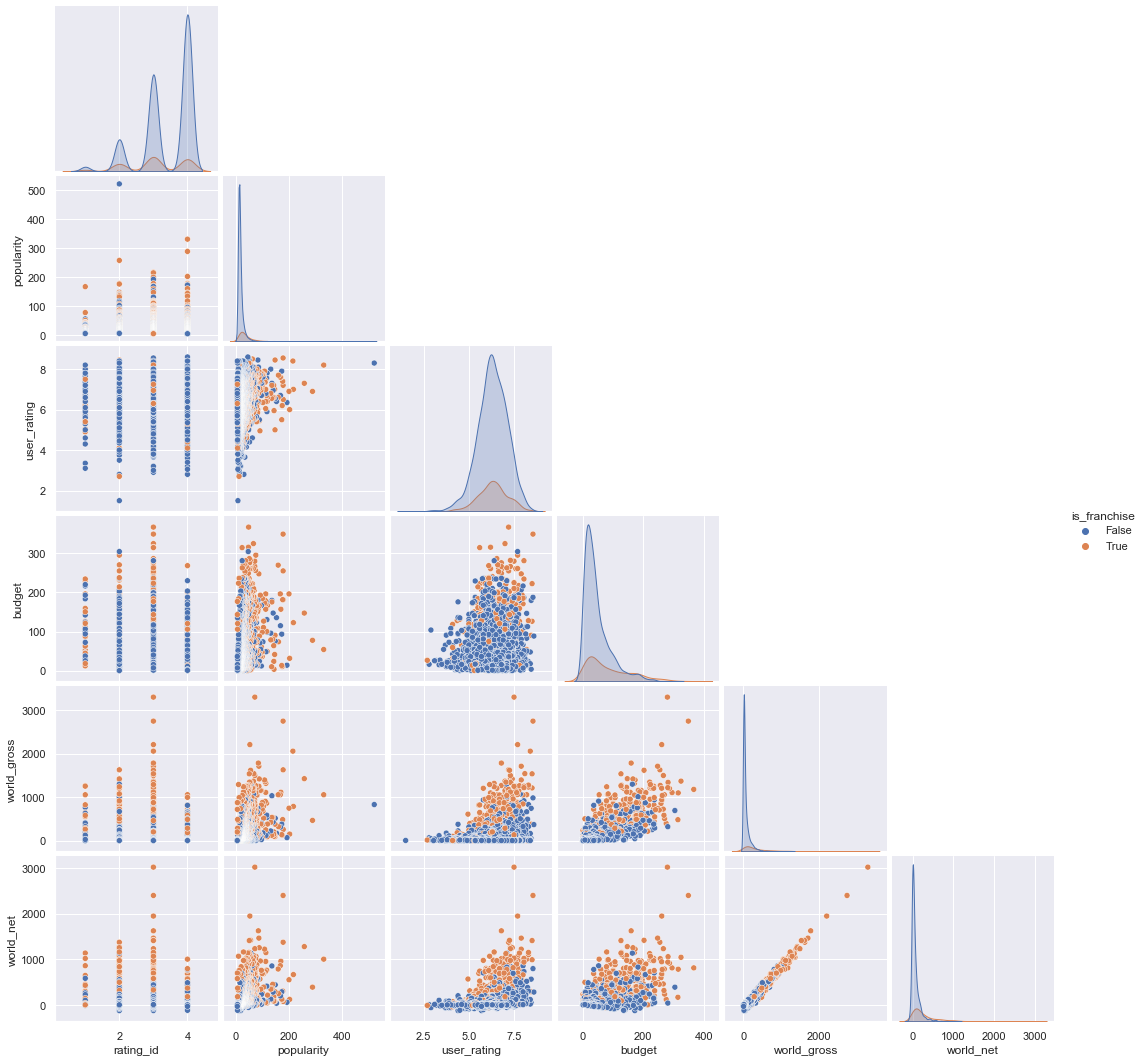

In [132]:
# visually inspect correlation pairs for some of our variables
sns.pairplot(
    master_movies,
    x_vars=['rating_id', 'popularity', 'user_rating', 'budget', 'world_gross', 'world_net'],
    y_vars=['rating_id', 'popularity', 'user_rating', 'budget', 'world_gross', 'world_net'],
    hue="is_franchise", diag_kind="kde", corner=True
);

We can see a good number of outliers in our scatters above. There are definitely some blockbuster hits that will affect our data. Worth noting that these dots are orange, marking them as franchises. In fact there don't seem to be any blue(non-franchise) outliers.

In [133]:
# preparing a correlation grid to make a heat map
master_movies_c = master_movies.corr()
master_movies_c

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
budget,1.000000,0.680745,0.732204,0.107993,0.596828,0.363577,0.141462,0.328610,-0.295343,0.307540,...,0.321025,0.022078,-0.171692,-0.080502,-0.058668,-0.128678,0.285366,-0.024631,0.058697,0.038922
dom_gross,0.680745,1.000000,0.948523,0.801752,0.928161,0.508870,0.254274,0.473102,-0.288141,0.485594,...,0.250933,-0.037373,-0.066710,-0.023595,-0.028039,-0.067398,0.190858,-0.054849,-0.009623,-0.012488
world_gross,0.732204,0.948523,1.000000,0.680281,0.983482,0.552029,0.256985,0.507523,-0.267217,0.488751,...,0.271737,-0.035575,-0.068877,-0.024916,-0.027229,-0.074192,0.204597,-0.043551,-0.010812,-0.017128
dom_net,0.107993,0.801752,0.680281,1.000000,0.772721,0.330204,0.318119,0.292649,-0.108205,0.353380,...,0.055670,-0.066687,0.009485,0.016510,-0.019540,-0.000186,0.012217,-0.084563,-0.060015,-0.043855
world_net,0.596828,0.928161,0.983482,0.772721,1.000000,0.508687,0.329941,0.440158,-0.208349,0.452087,...,0.219827,-0.047372,-0.066213,-0.023817,-0.040905,-0.067944,0.164711,-0.061794,-0.028150,-0.029337
popularity,0.363577,0.508870,0.552029,0.330204,0.508687,1.000000,0.200229,0.315657,-0.146785,0.382203,...,0.222417,-0.033511,0.070276,0.006198,0.006320,-0.096702,0.168513,0.014522,-0.003057,-0.019004
user_rating,0.141462,0.254274,0.256985,0.318119,0.329941,0.200229,1.000000,0.299948,-0.035807,0.012067,...,-0.017915,0.120713,-0.241735,0.058953,-0.036707,-0.010246,-0.048797,-0.123538,0.072136,0.025253
total_votes,0.328610,0.473102,0.507523,0.292649,0.440158,0.315657,0.299948,1.000000,-0.020514,0.237751,...,0.097124,-0.006049,-0.036803,-0.035723,-0.000279,-0.077584,0.217524,0.014335,-0.007038,0.037037
rating_id,-0.295343,-0.288141,-0.267217,-0.108205,-0.208349,-0.146785,-0.035807,-0.020514,1.000000,-0.163421,...,-0.226802,0.008148,0.177619,-0.065525,0.097942,-0.019976,-0.059701,0.246083,0.055358,0.036430
is_franchise,0.307540,0.485594,0.488751,0.353380,0.452087,0.382203,0.012067,0.237751,-0.163421,1.000000,...,0.150737,-0.080807,0.127235,-0.023270,0.008912,-0.129330,0.120450,0.023390,-0.035178,-0.034293


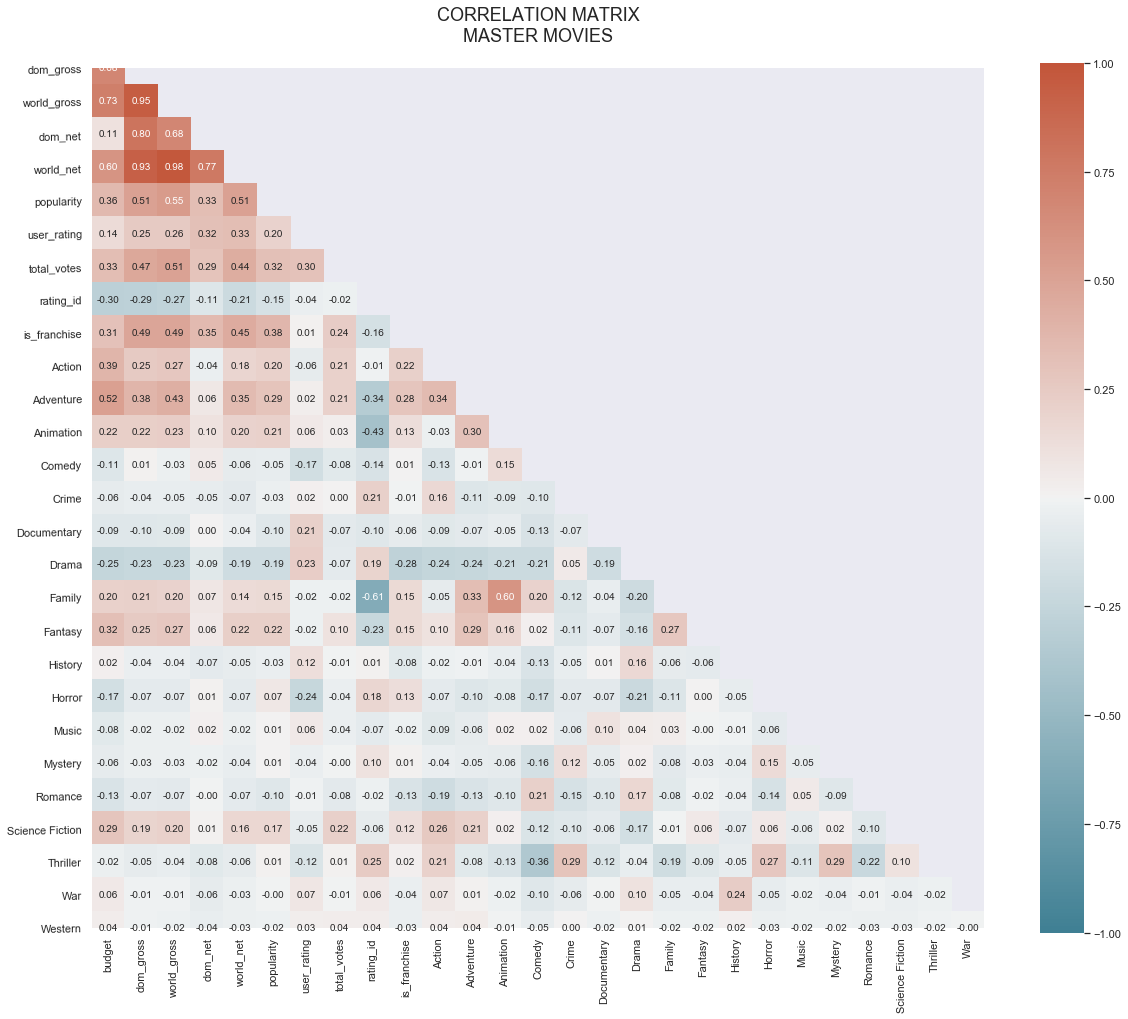

In [134]:
# plot a heat map for all correlations in our data set
fig, ax = plt.subplots(figsize=(20, 20))

# we want our heatmap to not show the upper triangle, which is redundant data
master_movies_c_mask = np.triu(np.ones_like(master_movies_c, dtype=np.bool))

# adjust mask and df
master_movies_c_mask = master_movies_c_mask[1:, :-1]
corr = master_movies_c.iloc[1:,:-1].copy()

# color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=master_movies_c_mask, annot=True, fmt=".2f", cmap=cmap,
           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)
# yticks
plt.yticks(rotation=1)

# title
title = 'CORRELATION MATRIX\nMASTER MOVIES\n'
plt.title(title, fontsize=18)

plt.show()

### Correlation Observtions
Observations from scatter plot and heat map

* financials have a positive correlation with whether a movie is a franchise
* user rating has only minor correlation with how well the movie does. It's more important to be popular.
* budget has high correlation with world net, but very low correlation with domestic net. That seems weird.
* a movie's popularity has positive correlation with gross/net
* There's a slight correlation between budget and the Science Fiction, Action, Adventure, and Fantasy genres. This is as expected - special effects aren't cheap!
* Documentaries and Dramas tend to be rated slightly higher
* Action/Adventure/Fantasy/Animation are the most popular genres
* A movie's popularity and total votes definitely relates to its gross/net
* A movie with higher MPAA rating has a negative correlation with grosses and net, until it hits worldwide where the correlation is only slightly negative


### Genre Correlation Combos

We can see from the heatmap where there are common genre combinations. We'll be able to break out and study those combinations in detail.

    * Action - teams with Adventure, Science Fiction, Thriller
    * Adventure - teams with Action, Animation, Family, Fantasy and Science Fiction. Most matches.
    * Comedy - teams slightly with Animation, Family and Romance
    * Crime - with Thriller
    * Documentary - no strong genre correlations
    * Drama - very slight teams with History and Romance
    * Family - teams with Adventure, Animation, and Fantasy
    * Fantasy - teams with Adventure and Family
    * History - teams slighty with Drama and War
    * Music - no strong genre correlations
    * Sci-Fi - teams with Action and Adventure
    * TV Movie - no strong genre correlations
    * Thriller - teams with Action, Crime, Horror, and Mystery
    * War - teams with History
    * Western - no strong genre correlations
    

## Franchises

In [135]:
# We'll be comparing some full financials in this section, so we use our full_financials data set as our basis
franchiseinfo = full_financials.groupby('is_franchise') # make a slice grouped by franchise vs non-franchise
isfranchise = full_financials.loc[full_financials['is_franchise'] == True] # dataframe copy with only franchises
notfranchise = full_financials.loc[full_financials['is_franchise'] == False] # dataframe copy with only non-franchises

franchiseinfo.count()
# 665 franchise films on the list, 2184 non-franchises

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
is_franchise,,,,,,,,,,,,,,,,,,,,,
False,2145,2145,2126,0,2145,2145,2145,2145,2145,2145,...,2145,2145,2145,2145,2145,2145,2145,2145,2145,2145
True,664,664,662,653,664,664,664,664,664,664,...,664,664,664,664,664,664,664,664,664,664


In [136]:
franchiseinfo.mean()

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,Action,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
is_franchise,,,,,,,,,,,,,,,,,,,,,
False,45.599982,49.505344,100.828899,3.905362,55.228917,19.322715,6.313986,48977.638228,3.286247,0.220979,...,0.087646,0.048951,0.089977,0.040093,0.081119,0.211189,0.099301,0.262005,0.030769,0.012587
True,85.877273,146.506986,363.892333,60.629714,278.015060,39.517529,6.347364,108881.817771,3.040663,0.408133,...,0.192771,0.003012,0.192771,0.027108,0.090361,0.073795,0.182229,0.268072,0.010542,0.003012


Looking at our averages for franchise vs non-franchise. As expected we see larger financials everywhere with franchises, in cost, gross and net. User rating averages out the same. Franchises are clearly more popular. Rating_id refers to a categorized MPAA rating; franchises are around PG-13 which is the 3. Non-franchises skew slightly higher which indicates that R-rated movies may be more likely to be one-off IPs.

Important things from the mean info:

* While franchises are twice as popular as non-franchises, the average user ratings are nearly identical.
* The budgets of franchise films roughly double, on average, the budgets of non-franchise films
* the worldwide net income of franchise roughly quintuples the worldwide net of non-franchise films, on average

It's important to note that these are averages and include massively popular outliers. Star Wars, Harry Potter, Marvel Cinematic Universe - all of these mega-franchises pull up the entire franchise category as a whole. We'll take a look at our budget and net income spreads without these outliers. 

First, we'll check out our data distribution for net income for franchise and non-franchise films.

In [137]:
isfranchise.describe()

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id
count,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,664.000000,6.640000e+02,664.000000
mean,85.877273,146.506986,363.892333,60.629714,278.015060,39.517529,6.347364,1.088818e+05,3.040663
std,74.353648,137.477381,385.165080,100.254295,332.370699,35.762377,0.804384,1.805607e+05,0.827417
min,0.263000,0.000000,0.000000,-131.717000,-57.205000,5.109000,2.700000,3.900000e+01,1.000000
25%,25.068500,52.853250,91.681000,0.957500,63.141750,18.381500,5.850000,2.315750e+03,2.750000
50%,62.249000,102.087000,225.326500,35.309000,154.323000,28.596000,6.300000,1.514000e+04,3.000000
75%,135.217000,197.265500,503.585500,89.436250,369.158750,46.468000,6.800000,1.435000e+05,4.000000
max,367.480000,999.456000,3298.964000,738.031000,3018.774000,330.357000,8.550000,1.404611e+06,4.000000


Franchise films have a middle 50% budget range of 25-135mil and a middle 50% worldwide net income range of 62-368mil.

In [138]:
notfranchise.describe()

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id
count,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2145.000000,2.145000e+03,2145.000000
mean,45.599982,49.505344,100.828899,3.905362,55.228917,19.322715,6.313986,4.897764e+04,3.286247
std,44.307062,56.160379,132.156159,47.165072,107.388122,14.593883,0.838558,1.140057e+05,0.735001
min,0.001000,0.000000,0.000000,-199.198000,-127.074000,4.830000,2.800000,3.100000e+01,1.000000
25%,14.914000,11.788000,19.159000,-16.419000,-2.560000,11.898000,5.800000,4.860000e+02,3.000000
50%,32.011000,32.222000,53.848000,-0.722000,20.603000,15.444000,6.300000,2.650000e+03,3.000000
75%,61.247000,66.077000,130.504000,20.891000,75.601000,21.424000,6.900000,4.874400e+04,4.000000
max,304.929000,517.541000,1296.788000,451.443000,1132.646000,191.929000,8.600000,1.868573e+06,4.000000


Non-franchise films have a middle 50% budget range of 14-60mil and a middle 50% worldwide net income range of -2.7-73mil.

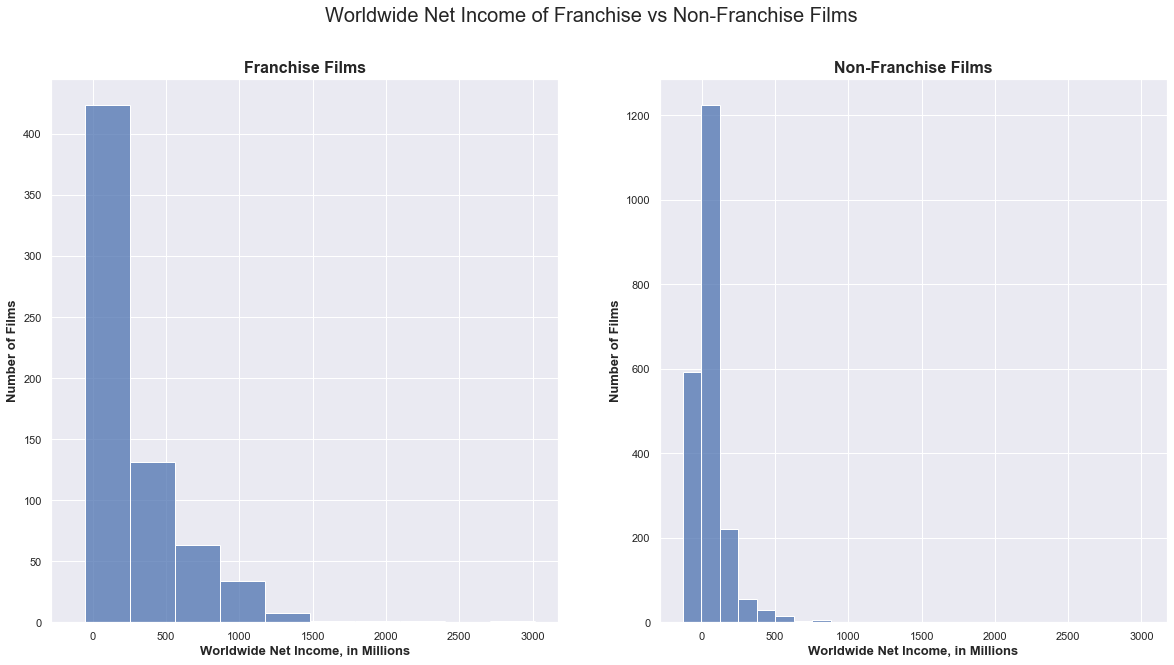

In [139]:
#histogram showing the domestic net of franchise films
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10), sharex=True)
fig.suptitle('Worldwide Net Income of Franchise vs Non-Franchise Films', fontsize=20)

isfranchisehist = sns.histplot(data=isfranchise, x="world_net", bins=10, ax=ax1)
isfranchisehist.set_ylabel('Number of Films',weight='bold',fontsize=13)
isfranchisehist.set_xlabel('Worldwide Net Income, in Millions', weight='bold',fontsize=13)
isfranchisehist.set_title('Franchise Films',weight='bold',fontsize=16)


notfranchisehist = sns.histplot(data=notfranchise, x="world_net", bins=10, ax=ax2)
notfranchisehist.set_ylabel('Number of Films',weight='bold',fontsize=13)
notfranchisehist.set_xlabel('Worldwide Net Income, in Millions', weight='bold',fontsize=13)
notfranchisehist.set_title('Non-Franchise Films',weight='bold',fontsize=16);

As we suspected, movie income distribution is not a normal distribution. Almost all releases fall within a lower net income range, and a breakout hit is the exception, not the norm.

Franchises are, at least, more likely to net into the positive. Quite a few non-franchise films lose money, netting less than 0 worldwide!

With this in mind, we will study budgets and world net from franchise vs. non-franchise films without including our mega-hit outliers for either category.

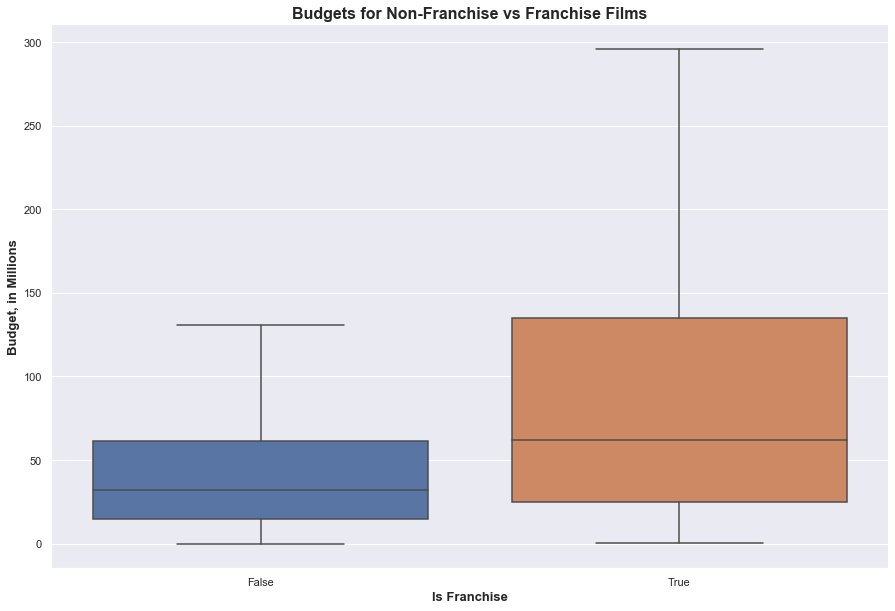

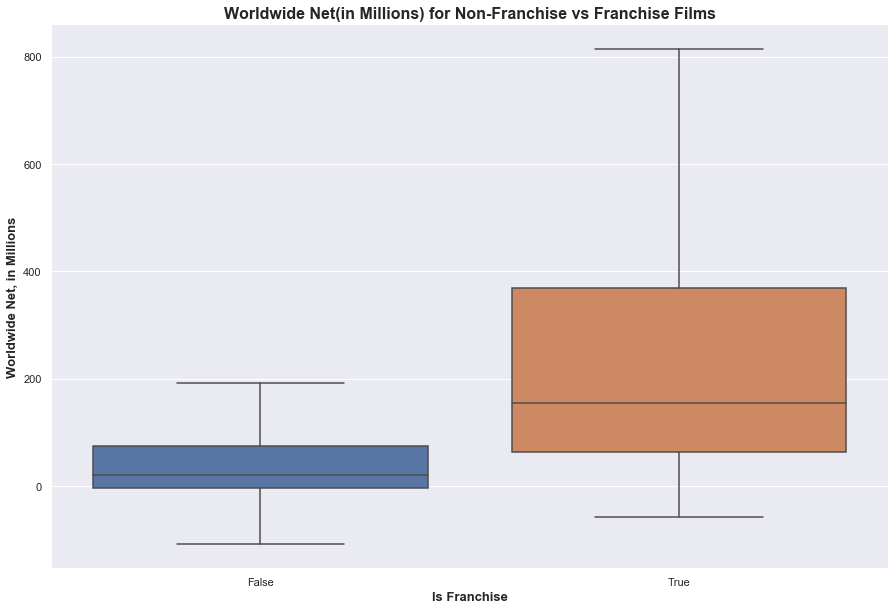

In [140]:
fig, ax=plt.subplots(figsize=(15,10))
data = full_financials
budgets = sns.boxplot(x='is_franchise', y='budget', data=full_financials, showfliers=False)
budgets.set_ylabel('Budget, in Millions',weight='bold',fontsize=13)
budgets.set_xlabel('Is Franchise', weight='bold',fontsize=13)
budgets.set_title('Budgets for Non-Franchise vs Franchise Films',weight='bold',fontsize=16)
sns.despine()

fig, ax=plt.subplots(figsize=(15,10))
data = full_financials
budgets = sns.boxplot(x='is_franchise', y='world_net', data=full_financials, showfliers=False)
budgets.set_ylabel('Worldwide Net, in Millions',weight='bold',fontsize=13)
budgets.set_xlabel('Is Franchise', weight='bold',fontsize=13)
budgets.set_title('Worldwide Net(in Millions) for Non-Franchise vs Franchise Films',weight='bold',fontsize=16)
sns.despine();

# in this plot we specifically remove our outliers, which takes our mega-hit franchises off of the graph.

When we ignore the outliers, most non-franchise films have a budget of around 30 mil, and a worldwide net 50% range of 0-75mil profit. Franchise films have a budget around 60mil, and a worldwide net 50% range of 70-350mil. Franchise films are clearly higher risk, budget wise, but have far greater reward potential, and are overall more likely to turn a profit.

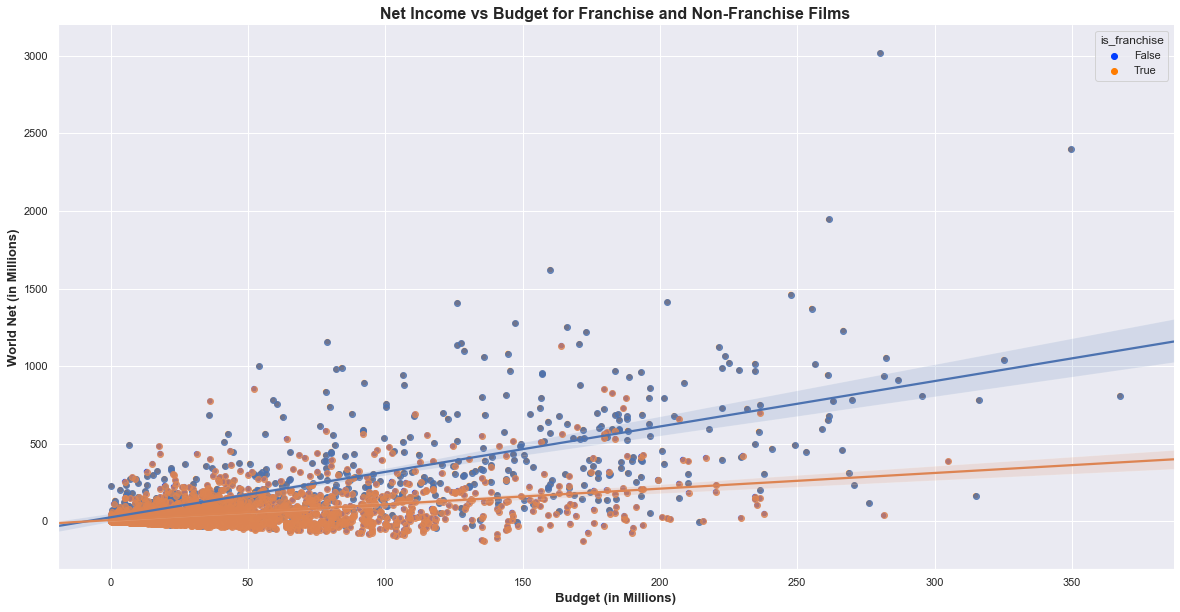

In [141]:
# scatter our world net vs budget and add regression lines for franchise vs non franchise

fig, ax=plt.subplots(figsize=(20,10))
data = full_financials
scatter2 = sns.scatterplot(x='budget', y='world_net', hue='is_franchise', data=full_financials, palette='bright')

ax = sns.regplot(x="budget", y="world_net", data=isfranchise, truncate=False)
ax = sns.regplot(x="budget", y="world_net", data=notfranchise, truncate=False)

scatter2.set_ylabel('World Net (in Millions)',weight='bold',fontsize=13)
scatter2.set_xlabel('Budget (in Millions)', weight='bold',fontsize=13)
scatter2.set_title('Net Income vs Budget for Franchise and Non-Franchise Films',weight='bold',fontsize=16)
sns.despine()

Above, we have a linear regression line drawn onto our respective franchise and non-franchise worldwide net income vs budget. These are far from a perfect fit, but they still allow us to see a distinct difference between franchise and non-franchise films. The flatter slope of the non-franchise line shows us that spending more on a non-franchise film only results in a moderate increase in net income.

In [142]:
# checking our variance for budget and gross on franchise films
isfranchise.var()[['budget', 'world_gross']]

budget           5528.464919
world_gross    148352.139138
dtype: float64

In [143]:
# checking our variance for budget and gross on non-franchise films
notfranchise.var()[['budget', 'world_gross']]

budget          1963.115765
world_gross    17465.250460
dtype: float64

We can see in the two calculations above that non-franchise films have a much smaller variance for both budget and worldwide gross.  Overall return on investment for franchise films is greater, but also comes with a greater variance, and therefore a greater risk.

In [144]:
isfranchise.sort_values('world_net', ascending=False).head(30)
# top 30 netting movies, worldwide, franchise
# important to note that not all movies had full budget info, so other movies may have netted more

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt0499549,Avatar,PG-13,Twentieth Century Fox,Avatar,280.190,899.101,3298.964,618.911,3018.774,70.878,...,True,False,False,False,False,False,True,False,False,False
tt4154796,Avengers Endgame,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,349.533,842.779,2746.974,493.246,2397.441,177.346,...,False,False,False,False,False,False,True,False,False,False
tt2488496,Star Wars The Force Awakens,PG-13,Walt Disney Studios Motion Pictures,NaN,261.425,999.456,2207.124,738.031,1945.699,52.273,...,True,False,False,False,False,False,True,False,False,False
tt0369610,Jurassic World,PG-13,Universal Pictures,Jurassic Park,160.056,695.999,1782.386,535.943,1622.330,84.240,...,False,False,False,False,False,False,True,True,False,False
tt0848228,The Avengers,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,247.700,701.844,1710.047,454.144,1462.347,86.260,...,False,False,False,False,False,False,True,False,False,False
tt2820852,Furious 7,PG-13,Universal Pictures,Fast and the Furious,202.738,376.673,1616.836,173.935,1414.098,55.008,...,False,False,False,False,False,False,False,True,False,False
tt0167260,The Lord Of The Rings The Return Of The King,PG-13,New Line Cinema,Peter Jackson's Lord of the Rings,126.299,507.676,1535.011,381.377,1408.712,50.027,...,True,False,False,False,False,False,False,False,False,False
tt6105098,The Lion King,PG,Walt Disney Studios Motion Pictures,The Lion King,255.277,533.762,1627.034,278.485,1371.757,177.499,...,False,False,False,True,False,False,False,False,False,False
tt4520988,Frozen Ii,PG,Walt Disney Studios Motion Pictures,Frozen,147.275,468.701,1423.685,321.426,1276.410,257.243,...,True,False,False,False,False,False,False,False,False,False


In [145]:
notfranchise.sort_values('world_net', ascending=False).head(30)
# top 30 netting NON franchise films, worldwide
# important to note that not all movies had full budget info, so other movies may have netted more

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt2771200,Beauty And The Beast,PG,Walt Disney Studios Motion Pictures,NaN,164.142,517.541,1296.788,353.399,1132.646,56.161,...,True,False,False,False,False,True,False,False,False,False
tt1727824,Bohemian Rhapsody,PG-13,Twentieth Century Fox,NaN,52.209,217.537,907.601,165.328,855.392,60.813,...,False,False,False,True,False,False,False,False,False,False
tt6139732,Aladdin,PG,Walt Disney Studios Motion Pictures,NaN,179.675,349.100,1031.606,169.425,851.931,135.195,...,True,False,False,False,False,True,False,False,False,False
tt3040964,The Jungle Book,PG,Walt Disney Studios Motion Pictures,NaN,182.718,380.055,1009.184,197.337,826.466,37.139,...,True,False,False,False,False,False,False,False,False,False
tt1375666,Inception,PG-13,Warner Bros.,NaN,187.649,343.134,981.446,155.485,793.797,46.070,...,False,False,False,False,False,False,True,False,False,False
tt0335345,The Passion Of The Christ,R,Newmarket Films,NaN,36.165,487.608,811.662,451.443,775.497,38.615,...,False,False,False,False,False,False,False,False,False,False
tt2096673,Inside Out,PG,Walt Disney Studios Motion Pictures,NaN,186.732,380.850,915.597,194.118,728.865,52.890,...,False,False,False,False,False,False,False,False,False,False
tt1190080,2012,PG-13,Sony Pictures Entertainment (SPE),NaN,236.448,196.384,935.408,-40.064,698.960,35.166,...,False,False,False,False,False,False,True,False,False,False
tt1454468,Gravity,PG-13,Warner Bros.,NaN,110.690,303.394,800.504,192.704,689.814,21.193,...,False,False,False,False,False,False,True,True,False,False


Let's run some correlation maps on our separated franchise and non-franchise movies, and see if we get some different information.

In [146]:
franchcorr = isfranchise.corr()
franchcorr

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
budget,1.000000,0.703270,0.757903,0.222734,0.654583,0.268534,0.356194,0.409021,-0.264200,NaN,...,0.350778,-0.035561,-0.397338,-0.082166,-0.134530,-0.123354,0.347968,-0.128054,-0.014129,-0.009732
dom_gross,0.703270,1.000000,0.934777,0.849706,0.925932,0.348999,0.524547,0.439701,-0.228501,NaN,...,0.278102,-0.054804,-0.299312,-0.030887,-0.136158,-0.027187,0.250566,-0.171070,-0.032564,-0.026155
world_gross,0.757903,0.934777,1.000000,0.719747,0.989294,0.403148,0.510941,0.451268,-0.229961,NaN,...,0.296065,-0.050603,-0.298466,-0.040167,-0.125514,-0.041321,0.245021,-0.133734,-0.040084,-0.034834
dom_net,0.222734,0.849706,0.719747,1.000000,0.784246,0.279420,0.455133,0.299606,-0.117396,NaN,...,0.121203,-0.048778,-0.115756,0.018583,-0.086938,0.054204,0.085526,-0.139615,-0.034176,-0.028648
world_net,0.654583,0.925932,0.989294,0.784246,1.000000,0.407112,0.512417,0.431447,-0.207385,NaN,...,0.264620,-0.050685,-0.256987,-0.028166,-0.115355,-0.020289,0.206097,-0.126330,-0.043291,-0.038190
popularity,0.268534,0.348999,0.403148,0.279420,0.407112,1.000000,0.351333,0.161192,0.008171,NaN,...,0.173436,-0.042033,0.012890,-0.018691,-0.064323,-0.085986,0.147475,-0.031214,-0.050392,-0.034747
user_rating,0.356194,0.524547,0.510941,0.455133,0.512417,0.351333,1.000000,0.405113,-0.089014,NaN,...,0.068100,-0.006658,-0.280774,0.044390,-0.098631,-0.087585,0.095467,-0.074789,0.049872,-0.010077
total_votes,0.409021,0.439701,0.451268,0.299606,0.431447,0.161192,0.405113,1.000000,0.041544,NaN,...,0.076595,-0.033129,-0.163666,-0.064200,-0.100267,-0.090705,0.326161,-0.016786,-0.033338,-0.032674
rating_id,-0.264200,-0.228501,-0.229961,-0.117396,-0.207385,0.008171,-0.089014,0.041544,1.000000,NaN,...,-0.250296,-0.002703,0.405402,-0.142805,0.162395,-0.027817,0.056999,0.327998,0.030593,-0.002703
is_franchise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


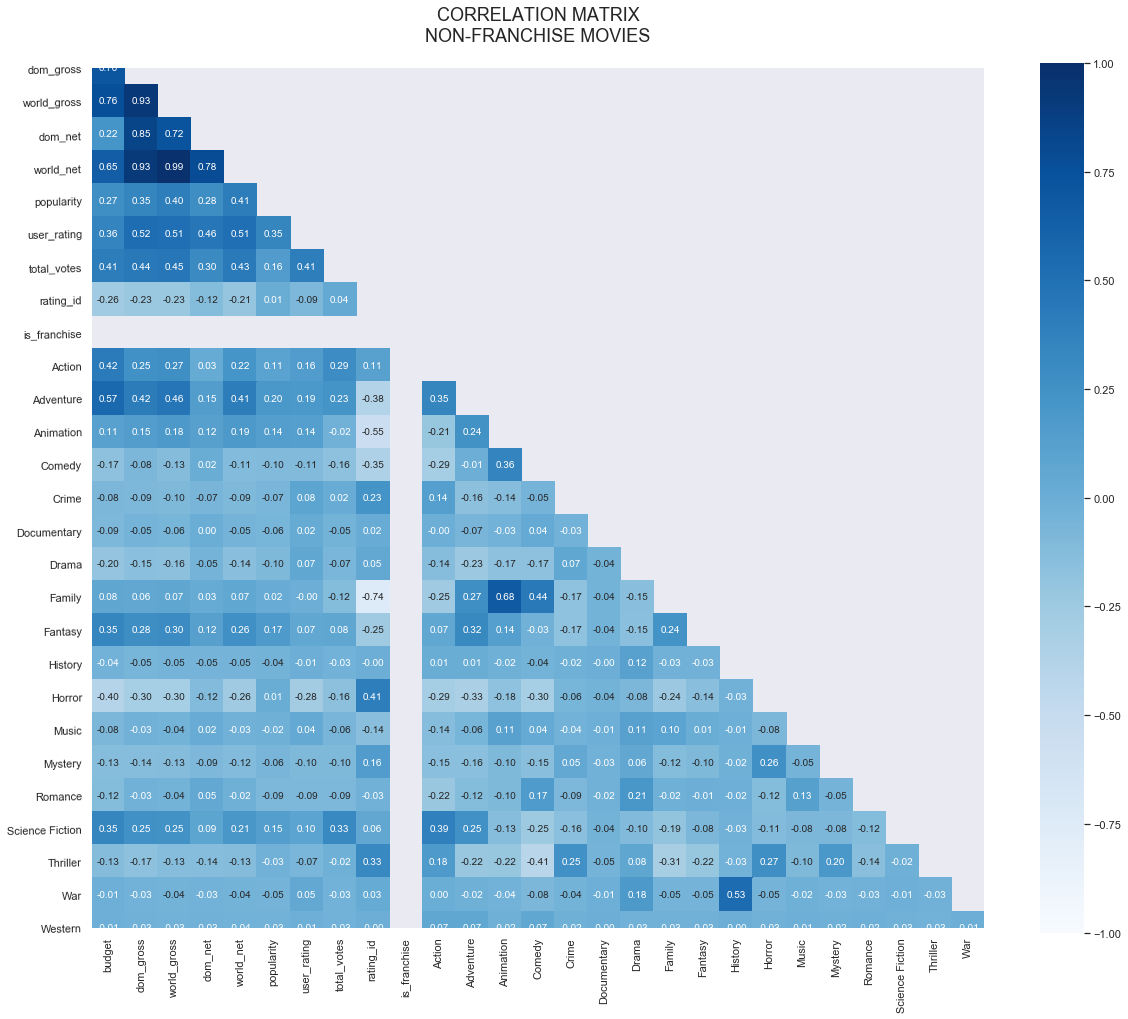

In [147]:
# plot a heat map for all correlations in our data set
fig, ax = plt.subplots(figsize=(20, 20))

# we want our heatmap to not show the upper triangle, which is redundant data
franchcorr_mask = np.triu(np.ones_like(franchcorr, dtype=np.bool))

# adjust mask and df
franchcorr_mask = franchcorr_mask[1:, :-1]
franchcorr = franchcorr.iloc[1:,:-1].copy()

# plot heatmap
sns.heatmap(franchcorr, mask=franchcorr_mask, annot=True, fmt=".2f", cmap="Blues",
           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)
# yticks
plt.yticks(rotation=1)

# title
title = 'CORRELATION MATRIX\nNON-FRANCHISE MOVIES\n'
plt.title(title, fontsize=18)

plt.show()

Franchise profits favor Adventure movies, with elements of Sci-Fi, Fantasy, Animation and Action.

User rating is positively correlated with succesful profit on franchise movies. It's not enough to have a franchise - it needs to be done well.

In [148]:
# correlation grid for non-franchise films
nonfranchcorr = notfranchise.corr()
nonfranchcorr

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
budget,1.000000,0.581232,0.674257,-0.247320,0.417180,0.311829,0.044632,0.191781,-0.279421,NaN,...,0.256098,0.082671,-0.106819,-0.077914,-0.031609,-0.085308,0.215238,0.023421,0.118469,0.078995
dom_gross,0.581232,1.000000,0.918507,0.644708,0.890543,0.372493,0.285924,0.315768,-0.246795,NaN,...,0.118826,0.028806,-0.065151,-0.028882,-0.014057,-0.006367,0.063647,-0.041884,0.044652,0.027364
world_gross,0.674257,0.918507,1.000000,0.460285,0.952450,0.455168,0.295024,0.406360,-0.228851,NaN,...,0.160169,0.035384,-0.056094,-0.029167,-0.015748,-0.016659,0.124560,-0.027081,0.052507,0.020127
dom_net,-0.247320,0.644708,0.460285,1.000000,0.668487,0.150601,0.298527,0.195832,-0.031374,NaN,...,-0.099091,-0.043362,0.022769,0.038802,0.012955,0.072557,-0.126410,-0.071874,-0.058122,-0.041625
world_net,0.417180,0.890543,0.952450,0.668487,1.000000,0.431491,0.344654,0.420957,-0.166347,NaN,...,0.091448,0.009436,-0.024960,-0.003748,-0.006339,0.014696,0.064484,-0.042990,0.015739,-0.007823
popularity,0.311829,0.372493,0.455168,0.150601,0.431491,1.000000,0.230253,0.254118,-0.123060,NaN,...,0.162023,0.001120,0.059786,-0.016306,0.004615,-0.078801,0.131778,0.014333,0.052230,-0.002841
user_rating,0.044632,0.285924,0.295024,0.298527,0.344654,0.230253,1.000000,0.330665,0.075420,NaN,...,-0.071147,0.148660,-0.212406,0.040810,0.006857,0.027609,-0.060020,-0.081834,0.065938,0.045752
total_votes,0.191781,0.315768,0.406360,0.195832,0.420957,0.254118,0.330665,1.000000,0.067142,NaN,...,-0.002156,0.024906,-0.026733,-0.030346,0.030207,-0.060068,0.141612,0.022363,0.003306,0.100521
rating_id,-0.279421,-0.246795,-0.228851,-0.031374,-0.166347,-0.123060,0.075420,0.067142,1.000000,NaN,...,-0.257594,0.023359,0.112530,-0.044038,0.086428,-0.046119,-0.069944,0.235362,0.081219,0.012926
is_franchise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


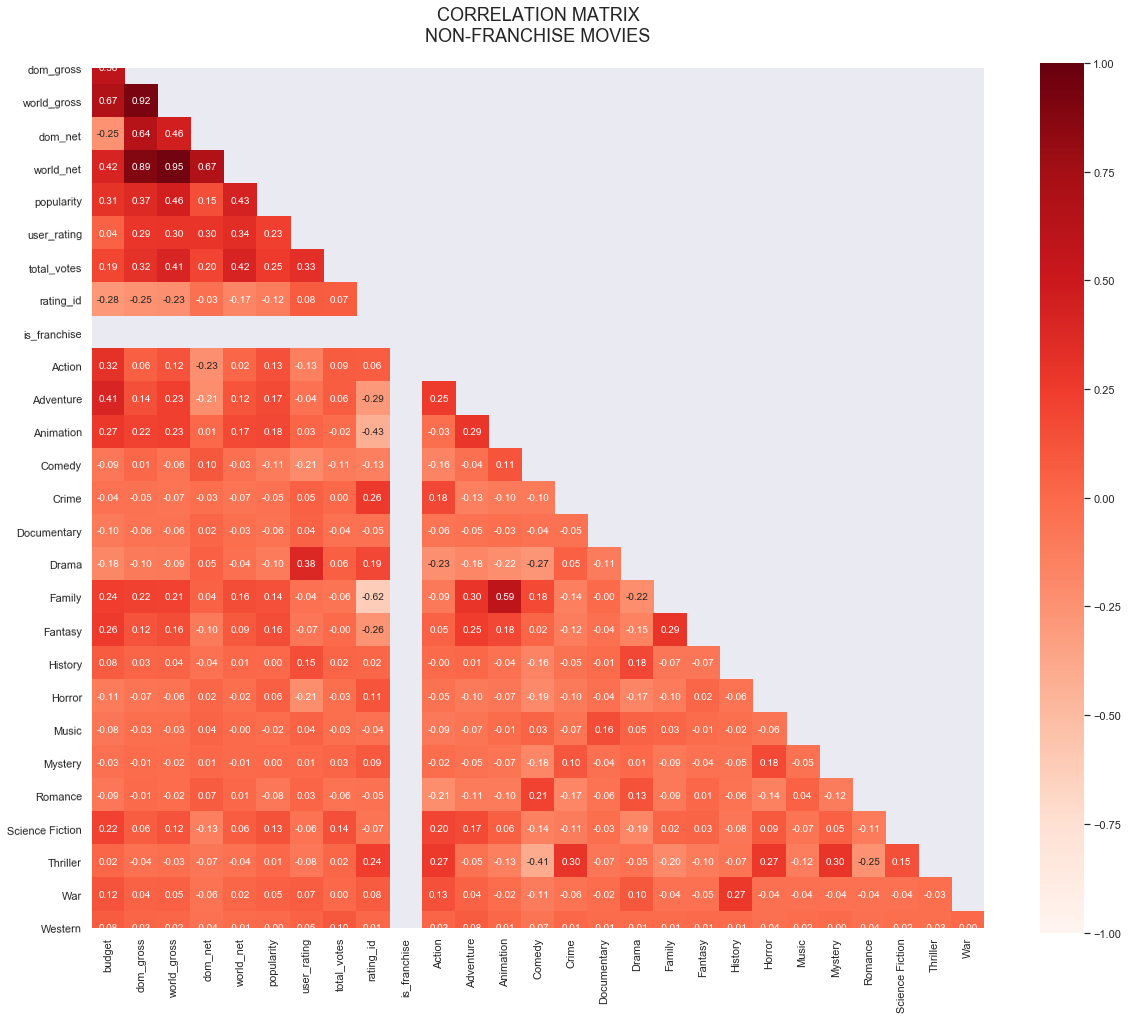

In [149]:
# plot a heat map for all correlations in our data set
fig, ax = plt.subplots(figsize=(20, 20))

# we want our heatmap to not show the upper triangle, which is redundant data
nonfranchcorr_mask = np.triu(np.ones_like(nonfranchcorr, dtype=np.bool))

# adjust mask and df
nonfranchcorr_mask = nonfranchcorr_mask[1:, :-1]
nonfranchcorr = nonfranchcorr.iloc[1:,:-1].copy()

# plot heatmap
sns.heatmap(nonfranchcorr, mask=nonfranchcorr_mask, annot=True, fmt=".2f", cmap="Reds",
           vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True)
# yticks
plt.yticks(rotation=1)

# title
title = 'CORRELATION MATRIX\nNON-FRANCHISE MOVIES\n'
plt.title(title, fontsize=18)

plt.show()

Non-franchise profits don't favor any particular genre. Correlation with user rating is only moderate.

Our last work in the Franchises category is to take a look at how a franchise's domestic gross changes over its lifespan. To do this we are going to indentify our biggest franchises, and visualize these.

In [150]:
howmany = 15 # variable to change how many franchise sets we want to look at

# Identifying our biggest franchises by sum domestic gross
biggestfranch = master_movies.groupby('franchise').sum().nlargest(howmany, 'dom_gross')
biggestfranch

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
franchise,,,,,,,,,,,,,,,,,,,,,
Marvel Cinematic Universe,4015.848,9016.622,23713.569,3398.483,15663.110,1896.849,170.30,12217544.0,69,23,...,5,0,0,0,0,0,20,0,0,0
Harry Potter,1541.108,3404.988,11242.286,1078.759,7015.517,738.420,76.75,1786405.0,26,10,...,10,0,0,0,1,0,0,0,0,0
Spider-Man,1249.854,2379.209,6118.537,908.365,4096.316,527.581,54.35,1471275.0,24,8,...,5,0,1,0,0,0,2,1,0,0
Batman,1225.834,2326.468,5308.045,1096.693,4077.552,612.596,56.95,2215993.0,25,8,...,3,0,0,0,1,0,0,3,0,0
Peter Jackson's Lord of the Rings,382.864,2315.349,7288.774,1027.416,3658.549,321.402,47.75,1807552.0,18,6,...,6,0,0,0,0,0,0,0,0,0
Transformers,1230.830,1799.345,5441.026,568.515,4210.196,211.569,37.10,897048.0,18,6,...,1,0,0,0,0,0,6,0,0,0
Shrek,759.480,1797.520,4430.120,1038.040,3670.640,272.511,33.65,333729.0,10,5,...,5,0,0,0,0,0,0,0,0,0
DC Extended Universe,682.811,1794.023,4549.744,539.853,2038.882,456.947,40.70,2437605.0,18,6,...,6,0,0,0,0,0,3,0,0,0
Pirates of the Caribbean,1360.677,1774.144,5396.238,413.467,4035.561,260.564,35.35,732287.0,15,5,...,5,0,0,0,0,0,0,0,0,0


In [151]:
# new dataframe copy with just the biggest franchises

biggestfranchises = master_movies[master_movies['franchise'].isin(biggestfranch.index)]
biggestfranchises['year'] = pd.DatetimeIndex(biggestfranchises['release_date']).year.astype(int)
biggestfranchises


C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,year
id,,,,,,,,,,,,,,,,,,,,,
tt7286456,Joker,R,Warner Bros.,Batman,54.001,329.357,1054.736,275.356,1000.735,330.357,...,False,False,False,False,False,False,True,False,False,2019
tt4154756,Avengers Infinity War,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,NaN,681.538,2056.574,NaN,NaN,214.301,...,False,False,False,False,False,True,False,False,False,2018
tt4154796,Avengers Endgame,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,349.533,842.779,2746.974,493.246,2397.441,177.346,...,False,False,False,False,False,True,False,False,False,2019
tt6320628,Spiderman Far From Home,PG-13,Sony Pictures Entertainment (SPE),Marvel Cinematic Universe,157.093,383.437,1111.365,226.344,954.272,169.038,...,False,False,False,False,False,True,False,False,False,2019
tt2527338,Star Wars The Rise Of Skywalker,PG-13,Walt Disney Studios Motion Pictures,Star Wars,270.004,505.843,1054.631,235.839,784.627,158.920,...,False,False,False,False,False,True,False,False,False,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0428251,Venom,R,Dimension Films,Spider-Man,32.177,1.135,1.135,-31.042,-31.042,13.798,...,False,True,False,False,False,False,True,False,False,2005
tt1055369,Transformers Revenge Of The Fallen,PG-13,DreamWorks,Transformers,236.448,475.392,988.710,238.944,752.262,12.049,...,False,False,False,False,False,True,False,False,False,2009
tt0418279,Transformers,PG-13,DreamWorks,Transformers,183.740,391.055,869.347,207.315,685.607,9.693,...,False,False,False,False,False,True,False,False,False,2007


''

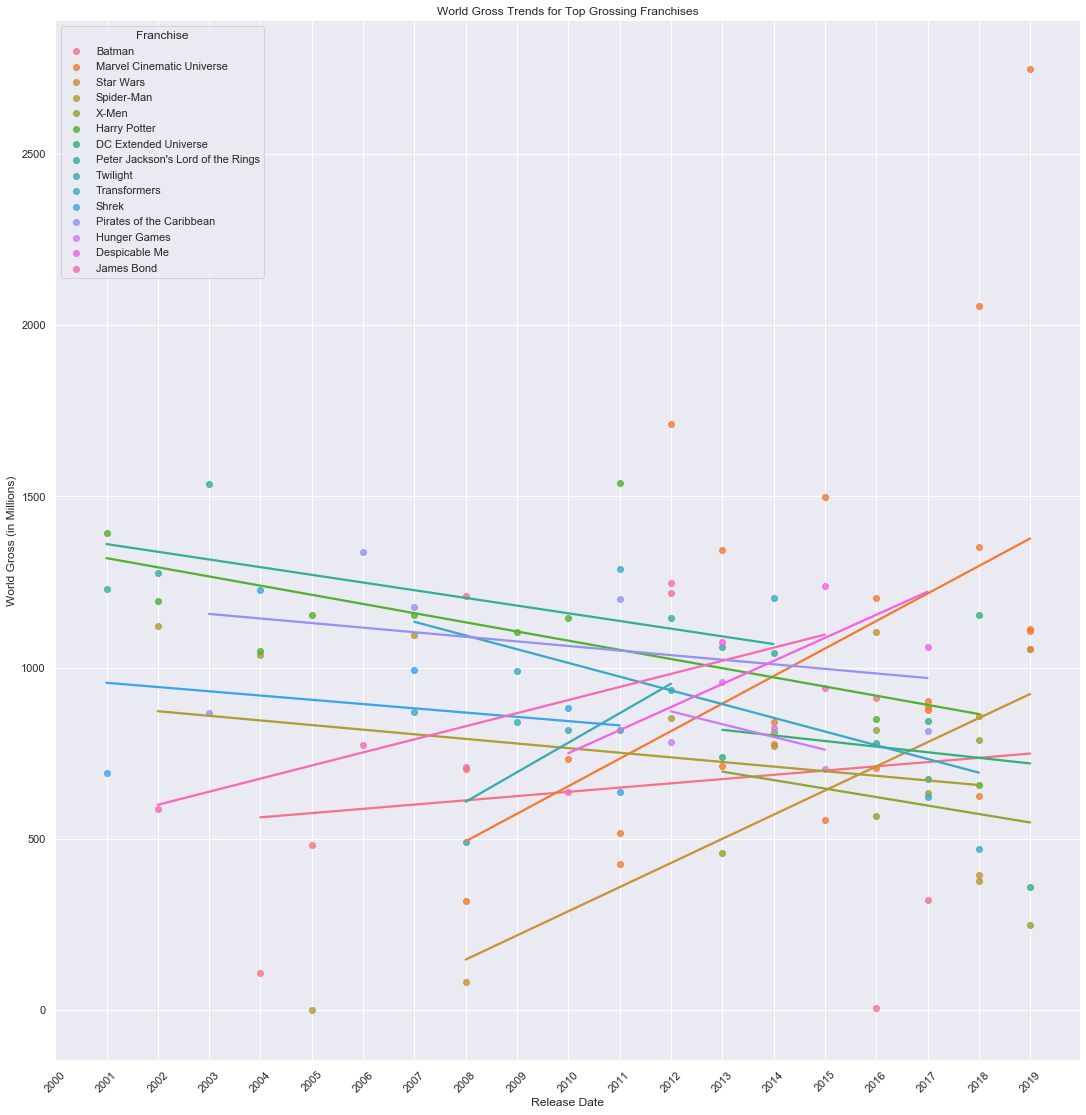

In [152]:
franchisehistory = sns.lmplot(x="year", 
               y="world_gross", 
               data=biggestfranchises,
               hue='franchise',
               ci=None,
               height=15,
                legend=False)

plt.xticks(np.arange(2000, 2020, step=1), rotation=45)
plt.legend(title='Franchise')
plt.xlabel('Release Date')
plt.ylabel('World Gross (in Millions)')
plt.title('World Gross Trends for Top Grossing Franchises')

;

We can clearly see, in an interesting visual trend, that many franchises trend downward in performance  as they age.

### Visualization
Franchise trends for FAMILY FRIENDLY

### Franchise observations

Franchises carry a clear risk/reward of higher cost and potential higher profit, and investing in a franchise for max net income is a committment to a specific genre set. However, consumers will punish a movie that is poorly done, regardless of whether it is a franchise.

While franchises cost more to produce, they are more likely to turn a positive net income, likely due to an in-built fanbase.

Franchises perform well in the categories of Adventure first and foremost, and also may include elements of Action, Sci-fi, Animation, and Fantasy.

Most franchises seem to be PG-13; we'll study that more shortly.

## Genres

In [153]:
# Making sets of our five most popular genres for further study
adventure = master_movies.loc[(master_movies['Adventure'] == True)]
action = master_movies.loc[(master_movies['Action'] == True)]
animation = master_movies.loc[(master_movies['Animation'] == True)]
fantasy = master_movies.loc[(master_movies['Fantasy'] == True)]
scifi = master_movies.loc[(master_movies['Science Fiction'] == True)]

''

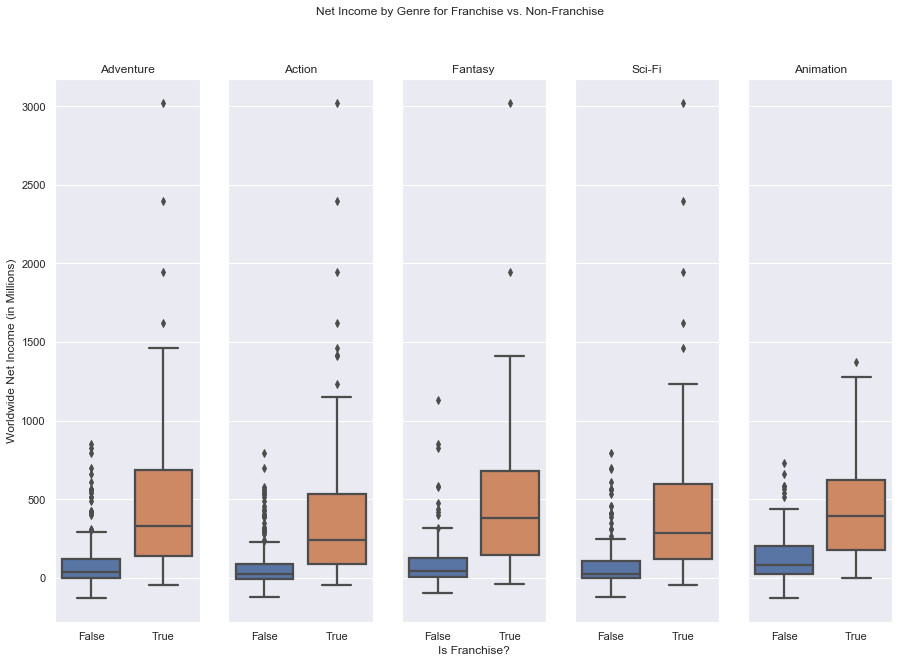

In [154]:
# plotting our five genres in a set of box plots, separating by franchise vs non-franchise

fig, axes = plt.subplots(1, 5, sharey=True, figsize=(15,10))
fig.suptitle('Net Income by Genre for Franchise vs. Non-Franchise')
axes[0].set_title('Adventure')
axes[1].set_title('Action')
axes[2].set_title('Fantasy')
axes[3].set_title('Sci-Fi')
axes[4].set_title('Animation')

sns.despine
sns.set_context('talk')

ax.set(xlabel='common label', ylabel='common label')

g1 = sns.boxplot(y='world_net', x='is_franchise', data=adventure, orient='v', ax=axes[0])
g2 = sns.boxplot(y='world_net', x='is_franchise', data=action, orient='v', ax=axes[1])
g3 = sns.boxplot(y='world_net', x='is_franchise', data=fantasy, orient='v', ax=axes[2])
g4 = sns.boxplot(y='world_net', x='is_franchise', data=scifi, orient='v', ax=axes[3])
g5 = sns.boxplot(y='world_net', x='is_franchise', data=animation, orient='v', ax=axes[4])

g1.set(ylabel='Worldwide Net Income (in Millions)', xlabel=None)
g2.set(ylabel=None, xlabel=None)
g3.set(ylabel=None, xlabel='Is Franchise?')
g4.set(ylabel=None, xlabel=None)
g5.set(ylabel=None, xlabel=None)

;

As per our observations so far, net income range for non-franchise is far smaller, and we don't see any outrageous outliers coming off of the bar plots. We're very unlikely to have a superstar  breakout non-franchise hit. Franchises once again show their liklihood of big net income, with a few big blockbusters per genre category.

We see evidence that animation is a very steady category, with very few outliers.

''

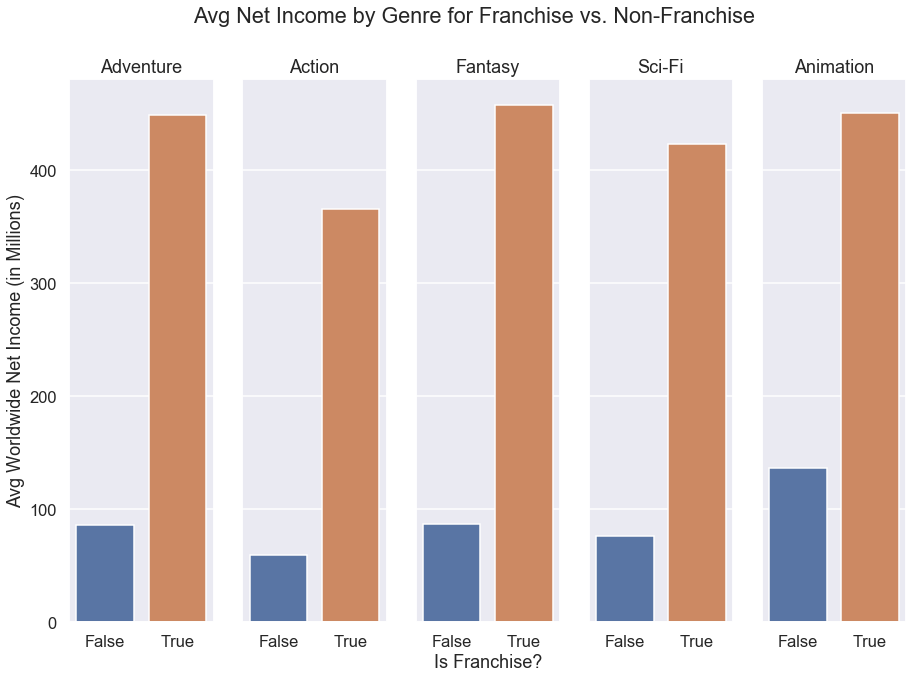

In [155]:
# simple histogram of average net income per genre, for franchise and non-franchise

fig, axes = plt.subplots(1, 5, sharey=True, figsize=(15,10))
fig.suptitle('Avg Net Income by Genre for Franchise vs. Non-Franchise')
axes[0].set_title('Adventure')
axes[1].set_title('Action')
axes[2].set_title('Fantasy')
axes[3].set_title('Sci-Fi')
axes[4].set_title('Animation')

sns.despine
sns.set_context('talk')

ax.set(xlabel='common label', ylabel='common label')

g1 = sns.barplot(y='world_net', x='is_franchise', data=adventure, orient='v', ax=axes[0], ci=None)
g2 = sns.barplot(y='world_net', x='is_franchise', data=action, orient='v', ax=axes[1], ci=None)
g3 = sns.barplot(y='world_net', x='is_franchise', data=fantasy, orient='v', ax=axes[2], ci=None)
g4 = sns.barplot(y='world_net', x='is_franchise', data=scifi, orient='v', ax=axes[3], ci=None)
g5 = sns.barplot(y='world_net', x='is_franchise', data=animation, orient='v', ax=axes[4], ci=None)

g1.set(ylabel='Avg Worldwide Net Income (in Millions)', xlabel=None)
g2.set(ylabel=None, xlabel=None)
g3.set(ylabel=None, xlabel='Is Franchise?')
g4.set(ylabel=None, xlabel=None)
g5.set(ylabel=None, xlabel=None)

;

When viewing a simple bar chart of averages, we can see how an Animation genre film is a relible income producer for either franchise or non-franchise films.

In [156]:
adventure.var()[['budget', 'world_gross']] # variance for Adventure genre

budget           5129.048464
world_gross    159273.546607
dtype: float64

In [157]:
action.var()[['budget', 'world_gross']] # variance for Action genre

budget           4677.859512
world_gross    111254.571404
dtype: float64

In [158]:
fantasy.var()[['budget', 'world_gross']] # variance for Fantasy genre

budget           4856.982824
world_gross    148785.102673
dtype: float64

In [159]:
scifi.var()[['budget', 'world_gross']] # variance for Sci-Fi genre

budget           5636.933611
world_gross    147633.531630
dtype: float64

In [160]:
animation.var()[['budget', 'world_gross']] # variance for Animation genre

budget           3586.094021
world_gross    109629.949819
dtype: float64

Animation movies have the lowest variance in both budget and world gross, implying they are the least risky type of movie to invest in.

## User Ratings

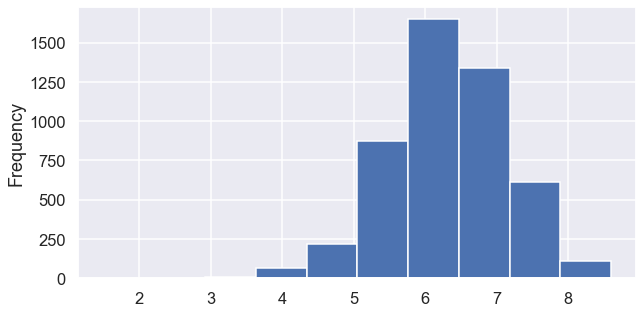

In [161]:
master_movies['user_rating'].plot(kind='hist', figsize=(10,5));
# the user ratings for movies look like a fairly normal distribution

### User Rating observations

User rating is fairly normally distributed over all movies. Because of this, we won't look much further at this.

## MPAA Rating

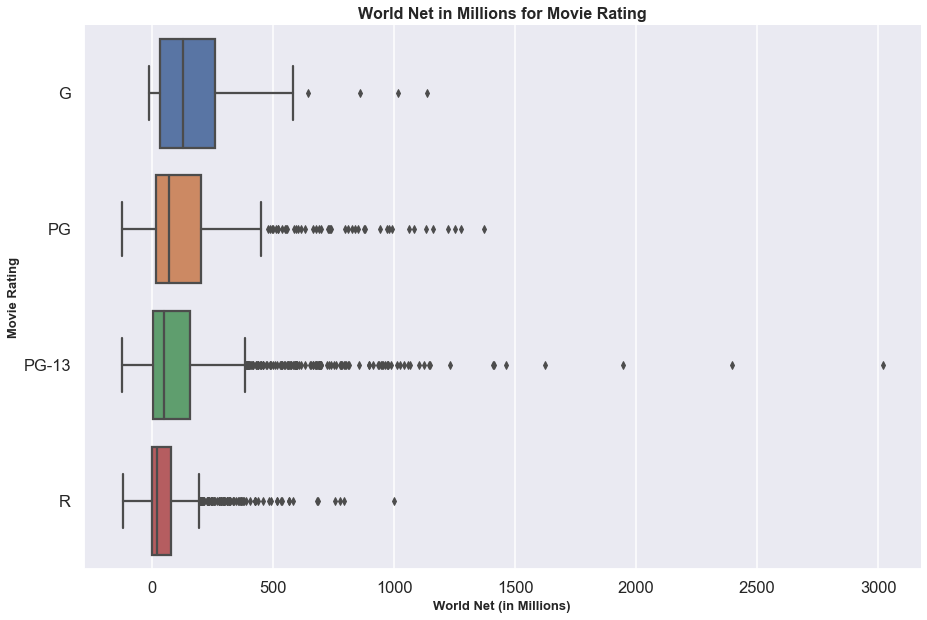

In [162]:
# we're making a boxplot to study world net income based on MPAA rating.

x_values = full_financials['world_net']

fig, ax=plt.subplots(figsize=(15,10))
budgets = sns.boxplot(x=x_values, y='mpaa_rating', data=full_financials, order=['G', 'PG', 'PG-13', 'R'])
budgets.set_ylabel('Movie Rating',weight='bold',fontsize=13)
budgets.set_xlabel('World Net (in Millions)', weight='bold',fontsize=13)
budgets.set_title('World Net in Millions for Movie Rating',weight='bold',fontsize=16)
sns.despine();

As rating increases, net income becomes less guaranteed. Movies rated G have the most consistent income range, while movies rated PG-13 seem to have great variance.

In [163]:
# checking out our average numbers for mpaa_rating based on franchise vs non-franchise
stuff = full_financials.groupby(['is_franchise', 'mpaa_rating']).mean()
stuff

budget   dom_gross  world_gross    dom_net  \
is_franchise mpaa_rating                                                   
False        G             80.103741   99.422519   206.311000  19.318778   
             PG            64.581366   72.630326   149.324036   8.048961   
             PG-13         52.464371   54.992243   114.343989   2.527872   
             R             32.558333   36.100964    70.803958   3.542631   
True         G             89.094750  168.654833   393.043333  79.560083   
             PG            93.839225  157.101782   407.942113  63.262556   
             PG-13        115.355975  191.451021   484.817883  76.095046   
             R             42.138415   78.925037   175.252829  36.786622   

                           world_net  popularity  user_rating    total_votes  \
is_franchise mpaa_rating                                                       
False        G            126.207259   21.612370     6.164815    6269.518519   
             PG            84.742670   23.691301     6.313799   31617.964158   
             PG-13         61.879618   19.554716     6.215919   50192.474215   
             R             38.245625   17.751857     6.410665   54165.425554   
True         G            303.948583   31.103500     6.466667   51533.000000   
             PG           314.102887   41.204866     6.375352   64763.985915   
             PG-13        369.461907   39.397616     6.428292  153520.953737   
             R            133.114415   39.499235     6.211060   86289.682028   

                          rating_id    Action  ...   Fantasy   History  \
is_franchise mpaa_rating                       ...                       
False        G                    1  0.037037  ...  0.296296  0.000000   
             PG                   2  0.114695  ...  0.261649  0.032258   
             PG-13                3  0.257848  ...  0.088565  0.054933   
             R                    4  0.222809  ...  0.029567  0.049630   
True         G                    1  0.000000  ...  0.208333  0.000000   
             PG                   2  0.225352  ...  0.359155  0.000000   
             PG-13                3  0.587189  ...  0.213523  0.007117   
             R                    4  0.341014  ...  0.055300  0.000000   

                            Horror     Music   Mystery   Romance  \
is_franchise mpaa_rating                                           
False        G            0.000000  0.074074  0.000000  0.074074   
             PG           0.010753  0.060932  0.017921  0.154122   
             PG-13        0.090807  0.039238  0.086323  0.292601   
             R            0.115100  0.033791  0.097149  0.155227   
True         G            0.000000  0.125000  0.000000  0.166667   
             PG           0.014085  0.042254  0.042254  0.042254   
             PG-13        0.110320  0.032028  0.071174  0.096085   
             R            0.437788  0.000000  0.156682  0.055300   

                          Science Fiction  Thriller       War   Western  
is_franchise mpaa_rating                                                 
False        G                   0.111111  0.000000  0.037037  0.037037  
             PG                  0.103943  0.021505  0.003584  0.007168  
             PG-13               0.132287  0.253363  0.022422  0.011211  
             R                   0.066526  0.348469  0.046463  0.014784  
True         G                   0.083333  0.000000  0.000000  0.000000  
             PG                  0.042254  0.021127  0.000000  0.000000  
             PG-13               0.306050  0.302491  0.017794  0.007117  
             R                   0.124424  0.414747  0.009217  0.000000  

[8 rows x 27 columns]

We see once again here that franchise films carry both a higher cost and a higher potential reward, but we also see that for non-franchise films, more family-friendly MPAA ratings carry a smaller disparity between franchise and non-franchise. This might indicate a recommendation for family-friendly fare if a franchise is not pursued.

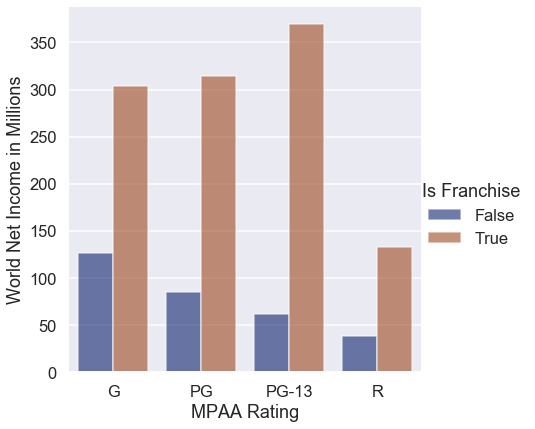

In [164]:
# visual representation of average world net income per MPAA rating, for franchises vs non-franchises

g = sns.catplot(
    data=full_financials, kind="bar",
    x="mpaa_rating", y="world_net", hue="is_franchise",
    ci=None, palette="dark", alpha=.6, height=6, order=['G', 'PG', 'PG-13', 'R']
)
g.despine(left=True)
g.set_axis_labels("MPAA Rating", "World Net Income in Millions")
g.legend.set_title("Is Franchise")


For non-franchises, as rating increases, average net income goes down. The safest non-franchise films lie in the family friendly ratings. For franchises, all ratings perform well except R rating. There is no reason we would recommend an R-rated film.

In [165]:
# a few final questions on "family friendly" ratings (G and PG) - how many lost money?

kidmoviesprofit = full_financials.loc[((full_financials['mpaa_rating'] == 'G') | (full_financials['mpaa_rating'] == 'PG')) & (full_financials['world_net'] > 0)]
kidmoviesprofit.sort_values('world_net')

# 402 family friendly films turned a profit

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt0406375,Zathura A Space Adventure,PG,Sony Pictures Entertainment (SPE),NaN,83.661,37.659,83.763,-46.002,0.102,25.015,...,True,False,False,False,False,False,True,False,False,False
tt0307109,The Lost Skeleton Of Cadavra,PG,Sony Pictures Repertory,NaN,0.055,0.198,0.198,0.143,0.143,7.695,...,False,False,True,False,False,False,True,False,False,False
tt0378407,My Date With Drew,PG,Slowhand Cinema Releasing,NaN,0.001,0.233,0.286,0.232,0.285,6.494,...,False,False,False,False,False,False,False,False,False,False
tt1462054,Letters To God,PG,Vivendi Entertainment,NaN,3.518,3.341,3.816,-0.177,0.298,10.465,...,False,False,False,False,False,False,False,False,False,False
tt2349460,Grace Unplugged,PG,Roadside Attractions,NaN,1.882,2.775,2.775,0.893,0.893,17.565,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2293640,Minions,PG,Universal Pictures,Despicable Me,78.961,358.574,1237.174,279.613,1158.213,28.207,...,False,False,False,False,False,False,False,False,False,False
tt0241527,Harry Potter And The Philosophers Stone,PG,Warner Bros.,Harry Potter,173.138,440.584,1394.081,267.446,1220.943,107.489,...,True,False,False,False,False,False,False,False,False,False
tt2294629,Frozen,PG,Walt Disney Studios Motion Pictures,Frozen,166.035,443.578,1417.724,277.543,1251.689,87.606,...,False,False,False,False,False,False,False,False,False,False


In [166]:
kidmoviesprofit.describe()
# profitable family friendly movies have an average user rating of 6.4

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,78.678507,119.071015,278.867351,40.392507,200.188843,31.720269,6.408458,47462.587065,1.878109
std,62.532516,105.800344,297.450613,79.175703,256.471780,29.808416,0.830176,96399.527315,0.327567
min,0.001000,0.198000,0.198000,-105.824000,0.102000,6.494000,3.100000,37.000000,1.000000
25%,29.492500,46.612750,75.663750,-0.099750,35.281250,15.770250,5.900000,1203.500000,2.000000
50%,61.894000,85.237500,171.422000,23.232000,98.666000,21.768500,6.400000,5759.500000,2.000000
75%,114.088500,157.547250,375.035500,64.273500,252.051500,35.089500,6.950000,47003.250000,2.000000
max,304.929000,580.246000,1627.034000,435.588000,1371.757000,257.243000,8.450000,692990.000000,2.000000


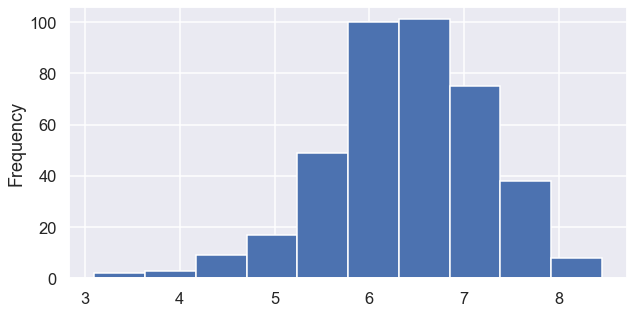

In [167]:
kidmoviesprofit['user_rating'].plot(kind='hist', figsize=(10,5));
# the user ratings for profitable family-friendly movies look like a fairly normal distribution

In [168]:
kidmoviesloss = full_financials.loc[((full_financials['mpaa_rating'] == 'G') | (full_financials['mpaa_rating'] == 'PG')) & (full_financials['world_net'] <= 0)]
kidmoviesloss.sort_values('world_net')

# 70 family-friendly movies netted a loss from 2000-2019

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt1305591,Mars Needs Moms,PG,Walt Disney Studios Motion Pictures,NaN,172.084,24.542,45.010,-147.542,-127.074,17.464,...,False,False,False,False,False,False,False,False,False,False
tt1041804,The Nutcracker In 3D,PG,Freestyle Releasing,NaN,105.552,0.229,22.075,-105.323,-83.477,16.814,...,True,False,False,True,False,False,False,False,False,False
tt0131704,The Adventures Of Rocky & Bullwinkle,PG,Universal Pictures,NaN,108.147,37.002,49.993,-71.145,-58.154,13.687,...,True,False,False,False,False,False,False,False,False,False
tt0120913,Titan Ae,PG,Twentieth Century Fox,NaN,106.724,32.377,52.299,-74.347,-54.425,15.698,...,False,False,False,False,False,False,True,False,False,False
tt0884726,Legends Of Oz Dorothys Return,PG,Clarius Entertainment,NaN,76.258,9.219,23.700,-67.039,-52.558,15.321,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0273799,Max Keebles Big Move,PG,Walt Disney Studios Motion Pictures,NaN,25.624,23.953,24.881,-1.671,-0.743,9.537,...,False,False,False,False,False,False,False,False,False,False
tt0413099,Evan Almighty,PG,Universal Pictures,Bruce Almighty,214.363,123.060,213.678,-91.303,-0.685,20.102,...,True,False,False,False,False,False,False,False,False,False
tt0386117,Where The Wild Things Are,PG,Warner Bros.,NaN,118.224,91.308,117.789,-26.916,-0.435,25.186,...,True,False,False,False,False,False,True,False,False,False


In [169]:
kidmoviesloss.describe()
# average user rating on loss family-friendly movies is 5.9

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,57.366943,20.541286,35.542114,-36.825657,-21.824829,14.849057,5.890000,4914.385714,1.971429
std,48.227184,21.295016,40.525792,34.989358,21.198463,7.119133,0.976967,12877.897252,0.167802
min,2.346000,0.000000,0.000000,-147.542000,-127.074000,6.520000,2.700000,31.000000,1.000000
25%,21.673500,7.892250,9.618250,-55.978000,-29.323000,10.573500,5.325000,199.250000,2.000000
50%,43.658000,14.626000,22.294500,-24.142000,-16.453000,12.787500,5.900000,592.500000,2.000000
75%,76.698250,24.394750,47.005250,-11.812250,-7.606250,16.808500,6.500000,2455.500000,2.000000
max,214.363000,123.060000,213.678000,-0.760000,-0.174000,45.683000,7.700000,76417.000000,2.000000


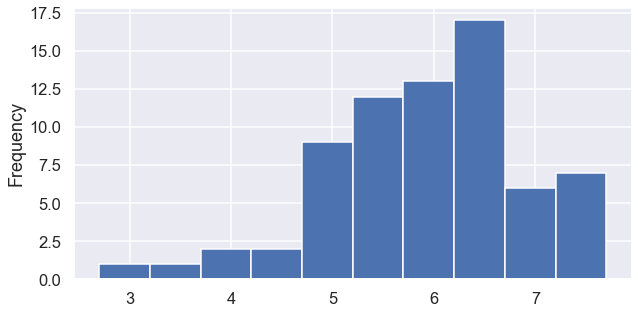

In [170]:
kidmoviesloss['user_rating'].plot(kind='hist', figsize=(10,5));
# the user ratings for family-friendly movies that took a loss are skewed to the left

Moral: Take the time and cost to make your movie good. It won't do well simply by being family-friendly.

### MPAA Observations

* R Movies are the least profitable overall
* PG-13 movies are the most unpredictable in profitability, with a lower range and a lot of blockbuster outliers.
* G movies have the most consistent profit with very few outliers

## Studios

In [171]:
master_movies.groupby('studio').sum().sort_values('world_gross', ascending=False).head(10)
# sorting on world gross as a sum, we see which studios bring in the most overall gross

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
studio,,,,,,,,,,,,,,,,,,,,,
Walt Disney Studios Motion Pictures,21949.559,38271.391,90990.086,10103.471,54919.939,8553.595,1704.80,24577703.0,596,75,...,59,9,2,14,12,41,38,29,6,6
Warner Bros.,25870.766,36013.259,84711.165,5233.753,45680.026,11487.915,2632.40,35024021.0,1324,106,...,64,15,38,9,47,63,46,116,12,4
Twentieth Century Fox,17871.749,24899.351,63314.759,5671.790,42226.364,8152.973,1828.45,20931413.0,852,85,...,50,6,19,9,21,52,60,76,6,1
Universal Pictures,18479.642,26825.554,61572.064,7587.366,41190.351,8420.933,1954.75,20561158.0,1009,98,...,39,16,41,14,25,69,32,85,9,2
Sony Pictures Entertainment (SPE),16833.206,21456.100,50221.955,3889.133,31472.531,6622.769,1466.20,15934201.0,733,70,...,27,9,16,6,23,39,25,59,3,1
Paramount Pictures,14204.168,17812.585,38033.062,3093.077,22575.920,5346.932,1358.20,18024484.0,698,59,...,18,8,20,10,20,27,42,59,11,2
Lionsgate,5780.561,10394.996,21357.251,2604.671,11147.500,5896.334,1724.70,15070492.0,949,67,...,17,5,49,8,24,49,24,98,6,4
DreamWorks,4010.783,5637.092,14022.794,1198.203,9146.038,900.536,252.95,2254177.0,111,11,...,8,1,3,2,2,4,5,2,2,0
New Line Cinema,3565.527,5777.751,11423.054,1747.033,7027.637,1702.284,531.40,141190.0,286,21,...,11,1,15,3,5,15,8,21,0,0


In [172]:
full_financials.groupby('studio').mean().sort_values('dom_net', ascending=False).head(10)
# sorting on average domestic net income per film. Interesting to see some of our biggest studios netting a lower 
# domestic net income when looking at the average, although they tend to outstrip the smaller competitors
# on a worldwide level

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
studio,,,,,,,,,,,,,,,,,,,,,
Newmarket Films,23.766375,75.599000,136.533875,51.832625,112.767500,18.527375,7.200000,15902.375000,3.750000,0.000000,...,0.125000,0.250000,0.000000,0.000000,0.250000,0.000000,0.125000,0.125000,0.000000,0.000000
Walt Disney Studios Motion Pictures,108.125906,157.896700,378.667478,49.770793,270.541571,32.343665,6.659852,103306.369458,2.384236,0.310345,...,0.246305,0.039409,0.009852,0.049261,0.039409,0.177340,0.152709,0.108374,0.029557,0.029557
Pantelion Films,12.048000,50.518000,91.611000,38.470000,79.563000,35.810000,6.250000,26525.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
DreamWorks,121.538879,157.848061,398.691545,36.309182,277.152667,24.194152,6.513636,68103.000000,2.757576,0.333333,...,0.242424,0.030303,0.030303,0.030303,0.060606,0.090909,0.151515,0.060606,0.060606,0.000000
Summit Entertainment,43.494125,79.266833,187.403250,35.772708,143.909125,27.516375,6.241667,89435.875000,2.958333,0.250000,...,0.208333,0.000000,0.083333,0.000000,0.166667,0.291667,0.208333,0.333333,0.041667,0.000000
United Artists Releasing,14.972750,46.152250,90.517750,31.179500,75.545000,62.209250,6.450000,7368.500000,3.250000,0.500000,...,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DreamWorks Distribution,68.758643,96.774952,195.749810,28.016310,126.991167,20.930500,6.661905,2467.190476,3.000000,0.142857,...,0.119048,0.000000,0.071429,0.023810,0.047619,0.142857,0.095238,0.214286,0.000000,0.023810
Universal Pictures,64.614133,91.143385,208.636339,26.529252,144.022206,28.204689,6.300000,69011.800699,3.244755,0.325175,...,0.132867,0.041958,0.136364,0.048951,0.080420,0.209790,0.111888,0.258741,0.027972,0.006993
New Line Cinema,51.674304,76.993623,153.524116,25.319319,101.849812,21.453203,6.294203,1900.710145,3.405797,0.304348,...,0.159420,0.014493,0.202899,0.028986,0.072464,0.159420,0.086957,0.246377,0.000000,0.000000


In [173]:
greaterthanthree = full_financials[full_financials.groupby('studio')['studio'].transform('size') >= 3]
greaterthanthree.groupby('studio').mean().sort_values('world_net').head(30)
# Here we check out the average world net per film of studios that have produced at least 3 films.
# We see that almost all studios out there make at least SOME money per film, all said and done.
# only eight of these studios manage to average a negative world net income by their third film.

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
studio,,,,,,,,,,,,,,,,,,,,,
First Look International,13.390800,1.784200,4.680600,-11.606600,-8.710200,9.843800,5.620000,231.200000,3.800000,0.200000,...,0.000000,0.000000,0.200000,0.000000,0.200000,0.200000,0.000000,0.400000,0.000000,0.000000
THINKFilm,10.973667,1.420333,2.523833,-9.553333,-8.449833,15.180667,6.266667,393.500000,3.833333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.166667,0.500000,0.000000,0.000000
Anchor Bay Films,9.121250,1.822750,2.623125,-7.298500,-6.498125,15.262500,5.568750,15667.625000,3.875000,0.125000,...,0.000000,0.000000,0.375000,0.000000,0.000000,0.125000,0.000000,0.500000,0.125000,0.000000
Freestyle Releasing,18.572500,9.861786,14.247786,-8.710714,-4.324714,13.587714,5.514286,12096.571429,3.000000,0.142857,...,0.142857,0.000000,0.214286,0.071429,0.071429,0.142857,0.142857,0.214286,0.000000,0.000000
Magnolia Pictures,6.179667,1.044833,3.085500,-5.134833,-3.094167,10.264000,6.080556,13916.444444,3.777778,0.055556,...,0.000000,0.000000,0.055556,0.000000,0.111111,0.166667,0.222222,0.166667,0.000000,0.000000
The Samuel Goldwyn Company,9.553800,5.707800,7.187700,-3.846000,-2.366100,14.546000,6.455000,11470.600000,3.200000,0.000000,...,0.000000,0.000000,0.000000,0.100000,0.000000,0.300000,0.000000,0.100000,0.100000,0.000000
Broad Green Pictures,21.479000,14.766833,20.102667,-6.712167,-1.376333,13.534667,5.883333,25661.333333,3.666667,0.166667,...,0.166667,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.333333,0.000000,0.000000
Apparition,18.080000,8.649250,17.479500,-9.430750,-0.600500,14.281750,6.587500,11459.000000,3.000000,0.250000,...,0.000000,0.250000,0.000000,0.250000,0.000000,0.500000,0.000000,0.250000,0.000000,0.000000
Annapurna Pictures,23.883600,19.866200,28.198600,-4.017400,4.315000,15.395600,6.930000,39604.600000,4.000000,0.000000,...,0.200000,0.400000,0.000000,0.000000,0.000000,0.200000,0.200000,0.400000,0.000000,0.000000


In [174]:
greaterthanthree.groupby(['studio', 'is_franchise']).mean().sort_values('world_net').head(20)
# we look into this a little further by checking out franchise status and see that 
# MOST (but not ALL) net income misses are NOT franchise films

,,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,Action,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
studio,is_franchise,,,,,,,,,,,,,,,,,,,,,
Rocky Mountain Pictures,True,22.945000,5.309000,5.309000,-17.636000,-17.636000,10.563000,5.450000,12643.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
First Look International,True,13.590000,0.056000,0.940000,-13.534000,-12.650000,6.707000,5.200000,39.000000,4.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Freestyle Releasing,False,21.023333,4.635583,9.250083,-16.387750,-11.773250,13.165667,5.625000,10879.833333,3.083333,0.250000,...,0.166667,0.000000,0.166667,0.083333,0.083333,0.166667,0.166667,0.250000,0.000000,0.000000
THINKFilm,False,10.973667,1.420333,2.523833,-9.553333,-8.449833,15.180667,6.266667,393.500000,3.833333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.166667,0.500000,0.000000,0.000000
First Look International,False,13.341000,2.216250,5.615750,-11.124750,-7.725250,10.628000,5.725000,279.250000,3.750000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000
Anchor Bay Films,False,10.089143,2.067571,2.783571,-8.021571,-7.305571,11.515429,5.450000,7906.857143,3.857143,0.000000,...,0.000000,0.000000,0.285714,0.000000,0.000000,0.142857,0.000000,0.428571,0.142857,0.000000
Magnolia Pictures,False,6.508706,1.089941,2.917882,-5.418765,-3.590824,9.980824,6.067647,9712.058824,3.764706,0.176471,...,0.000000,0.000000,0.058824,0.000000,0.117647,0.176471,0.176471,0.117647,0.000000,0.000000
The Samuel Goldwyn Company,False,9.553800,5.707800,7.187700,-3.846000,-2.366100,14.546000,6.455000,11470.600000,3.200000,0.100000,...,0.000000,0.000000,0.000000,0.100000,0.000000,0.300000,0.000000,0.100000,0.100000,0.000000
Artisan Entertainment,False,17.055125,9.049000,14.717500,-8.006125,-2.337625,11.283500,5.487500,1004.000000,3.875000,0.250000,...,0.000000,0.000000,0.250000,0.000000,0.125000,0.125000,0.000000,0.625000,0.000000,0.000000


Sorting on domestic net on average, we get some interesting results. Our big flashy studios are still there, but there are some smaller studios that have a very respectable domestic net income per. For example, film Pantelion films spent 12mil on a single film that ultimately netted 38mil domestic, which is only about 11mil less than the average Disney film nets domestically. Now, the WORLDWIDE net differs greatly (79mil vs Disney's 270mil), but overall we can understand that we can get respectable results on a smaller budget if we do it right.

We also see further evidence that most studios manage a worldwide net income on films, at least after their first few. We can have reasonably high confidence that if we hit the marks on rating, genre, and franchiseability, we will probably make a profit on our film even as a first outing.

There's a real chance for Microsoft to do well on a first film!

## Bottom Quartile Negative Net 

The final thing we need is to identify the commonalities in our bottom quartile of movies that resulted in no net income at all.

In [175]:
negative_income = master_movies.loc[(master_movies['world_net'] < 0)]
negative_income.sort_values('world_net')
# 714 movies from our master movies list of 9991 movies resulted in a negative net income

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt1305591,Mars Needs Moms,PG,Walt Disney Studios Motion Pictures,NaN,172.084,24.542,45.010,-147.542,-127.074,17.464,...,False,False,False,False,False,False,False,False,False,False
tt0180052,The Adventures Of Pluto Nash,PG-13,Warner Bros.,NaN,135.905,6.007,9.655,-129.898,-126.250,10.766,...,False,False,False,False,False,False,True,False,False,False
tt0141907,Town & Country,R,New Line Cinema,NaN,135.047,9.303,14.361,-125.744,-120.686,5.812,...,False,False,False,False,False,True,False,False,False,False
tt0318974,The Alamo,PG-13,Walt Disney Studios Motion Pictures,NaN,140.713,29.477,33.955,-111.236,-106.758,12.139,...,False,True,False,False,False,False,False,False,True,True
tt0166276,Monkeybone,PG-13,Twentieth Century Fox,NaN,103.883,7.494,9.025,-96.389,-94.858,13.611,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0252501,Hearts In Atlantis,PG-13,Warner Bros.,NaN,42.938,33.500,42.827,-9.438,-0.111,12.945,...,False,False,False,False,True,False,False,False,False,False
tt2265398,Drinking Buddies,R,Magnolia Pictures,NaN,0.553,0.380,0.448,-0.173,-0.105,9.039,...,False,False,False,False,False,True,False,False,False,False
tt1230168,Same Kind Of Different As Me,PG-13,Pure Flix Entertainment,NaN,6.668,6.590,6.590,-0.078,-0.078,13.464,...,False,False,False,False,False,False,False,False,False,False


In [176]:
negative_income.groupby('is_franchise').count()
# the first thing to check is franchise status. Consistent with other data we have seen, non-franchises
# are far more likely to bomb.

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
is_franchise,,,,,,,,,,,,,,,,,,,,,
False,647,647,630,0,647,647,647,647,647,647,...,647,647,647,647,647,647,647,647,647,647
True,33,33,31,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33


One thing that our data does not account for is the inherent *survivor bias* when a movie is INTENDED to begin a franchise, but bombs so badly that the franchise does not continue. *These movies do not get flagged as franchises in our data set*. Accordingly, we cannot be certain that the ratio of franchise to non-franchise bombs is accurate.

OTHER data in our exploration lends enough weight to our belief in the value of franchises, but we must take this information on "bombs" with a grain of salt.

In [177]:
negative_income.groupby('studio').count().sort_values('title').head(20)
# tons of studios have only one bomb.

,title,mpaa_rating,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
studio,,,,,,,,,,,,,,,,,,,,,
Neverland Films,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Peninsula Films,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Paramount Insurge,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Paladin,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Odeon,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Ocean Avenue Entertainment,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
New Films Cinema,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Yari Film Group Releasing,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Phase 4 Films,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [178]:
# We want to look at all entries for studios that have more than one bomb.
twobombs = negative_income[negative_income.groupby('studio')['studio'].transform('size') > 1]
twobombs.sort_values('world_net').head(25)

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
tt1305591,Mars Needs Moms,PG,Walt Disney Studios Motion Pictures,NaN,172.084,24.542,45.010,-147.542,-127.074,17.464,...,False,False,False,False,False,False,False,False,False,False
tt0180052,The Adventures Of Pluto Nash,PG-13,Warner Bros.,NaN,135.905,6.007,9.655,-129.898,-126.250,10.766,...,False,False,False,False,False,False,True,False,False,False
tt0141907,Town & Country,R,New Line Cinema,NaN,135.047,9.303,14.361,-125.744,-120.686,5.812,...,False,False,False,False,False,True,False,False,False,False
tt0318974,The Alamo,PG-13,Walt Disney Studios Motion Pictures,NaN,140.713,29.477,33.955,-111.236,-106.758,12.139,...,False,True,False,False,False,False,False,False,True,True
tt0166276,Monkeybone,PG-13,Twentieth Century Fox,NaN,103.883,7.494,9.025,-96.389,-94.858,13.611,...,True,False,False,False,False,False,True,False,False,False
tt0318081,A Sound Of Thunder,PG-13,Warner Bros.,NaN,102.968,2.446,15.015,-100.522,-87.953,10.736,...,False,False,False,False,False,False,True,True,False,False
tt0134983,Supernova,PG-13,Metro-Goldwyn-Mayer (MGM),NaN,106.724,20.242,21.092,-86.482,-85.632,12.448,...,False,False,True,False,False,False,True,True,False,False
tt1041804,The Nutcracker In 3D,PG,Freestyle Releasing,NaN,105.552,0.229,22.075,-105.323,-83.477,16.814,...,True,False,False,True,False,False,False,False,False,False
tt1341188,How Do You Know,PG-13,Sony Pictures Entertainment (SPE),NaN,140.736,35.433,57.642,-105.303,-83.094,11.509,...,False,False,False,False,False,True,False,False,False,False


In [179]:
twobombs.groupby(['studio', 'is_franchise']).count().sort_values(['title', 'studio'], ascending=False).head(30)
# we check franchise status. The largest number of studio misses are NOT franchises.

,,title,mpaa_rating,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
studio,is_franchise,,,,,,,,,,,,,,,,,,,,,
Warner Bros.,False,63,63,0,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
Universal Pictures,False,44,44,0,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
Paramount Pictures,False,37,37,0,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37
Twentieth Century Fox,False,35,35,0,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
Sony Pictures Entertainment (SPE),False,35,35,0,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
New Line Cinema,False,25,25,0,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
Miramax,False,25,25,0,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
Lionsgate,False,24,24,0,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
Walt Disney Studios Motion Pictures,False,23,23,0,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23


In [180]:
studio_hits = full_financials.groupby('studio').count()
# Our total number of full financial movies sorted by studio. Since we are comparing on net, we can only use the list of 
# movies for which we have net income totals for an accurate proportion

studio_misses = negative_income.groupby('studio').count()
studio_misses
# our negative ratings count of ALL of our negative net movies by studio

studio_proportion = round(((studio_misses['title'])/(studio_hits['title']))*100, 2)
studio_proportion.dropna(axis=0, inplace=True)
studio_proportion.sort_values().head(20)
# proportion percentage of movie failures by studio, regardless of franchise status. 

studio
CBS Films                               9.09
The Weinstein Company                   9.38
Walt Disney Studios Motion Pictures    11.33
DreamWorks                             12.12
Twentieth Century Fox                  13.74
Rogue Pictures                         14.29
BH Tilt                                14.29
Focus Features                         15.00
Screen Gems                            16.42
Pure Flix Entertainment                16.67
Fox Searchlight Pictures               16.67
Summit Entertainment                   16.67
STX Entertainment                      16.67
Sony Pictures Entertainment (SPE)      16.74
Lionsgate                              16.98
Universal Pictures                     17.13
Dimension Films                        18.52
Paramount Pictures                     18.81
United Artists                         20.00
Warner Bros.                           20.83
Name: title, dtype: float64

There are a lot of small, lesser-known studios on our list of those with the lowest failure proportion. A studio doesn't have to be Disney to make a successful film!

In [181]:
ratings_count = full_financials.groupby('mpaa_rating').count()
# Our total number of full financial movies sorted  by rating. Since we are comparing on net, we can only use the list of 
# movies for which we have net income totals for an accurate proportion

negative_ratings_count = negative_income.groupby('mpaa_rating').count()
negative_ratings_count
# our negative ratings count of ALL of our negative net movies by MPAA rating

,title,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
mpaa_rating,,,,,,,,,,,,,,,,,,,,,
G,2,2,1,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
PG,68,67,4,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
PG-13,251,249,6,251,251,251,251,251,251,251,...,251,251,251,251,251,251,251,251,251,251
R,359,343,22,359,359,359,359,359,359,359,...,359,359,359,359,359,359,359,359,359,359


In [182]:
mpaaproportion = round(((negative_ratings_count['title'])/(ratings_count['title']))*100, 2)
print(mpaaproportion)
# proportion percentage of movie failures by rating, regardless of franchise status. 

mpaa_rating
G         3.92
PG       16.15
PG-13    21.40
R        30.84
Name: title, dtype: float64


We see here that G-rated movies are least likely to fail, followed by PG movies. This is consistent with our earlier findings that G and PG movies have the most consistent net income, despite that net income being less on average than PG-13 movies we also see here that R-rated movies have the highest rate of failure.

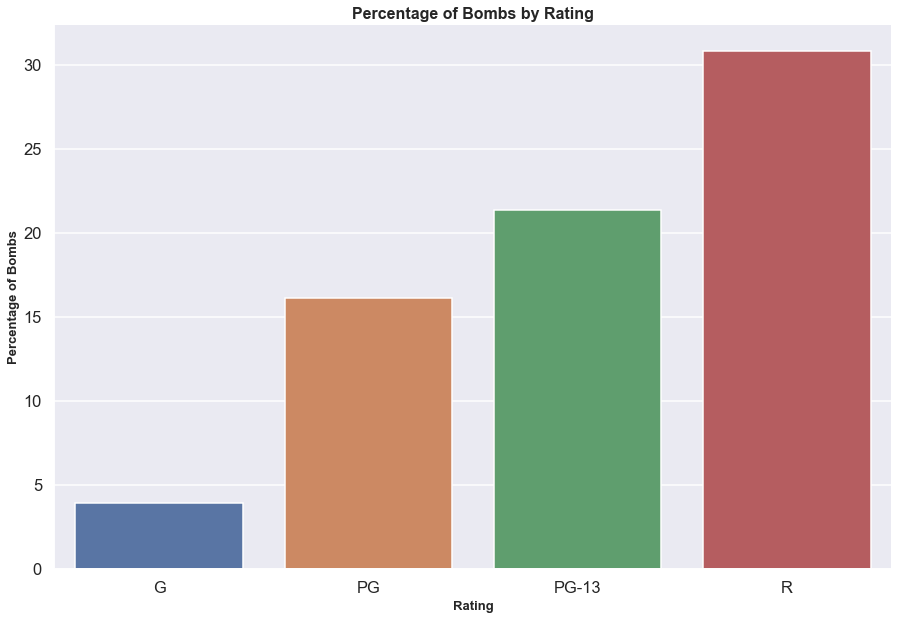

In [183]:
fig, ax=plt.subplots(figsize=(15,10))

x_values=ratings_count['title']

scatter4 = sns.barplot(x=x_values, y=mpaaproportion, data=mpaaproportion, order=[x_values[0], x_values[1], x_values[2], x_values[3]])

scatter4.set_xticklabels(['G', 'PG', 'PG-13', 'R'])

scatter4.set_ylabel('Percentage of Bombs',weight='bold',fontsize=13)
scatter4.set_xlabel('Rating', weight='bold',fontsize=13)
scatter4.set_title('Percentage of Bombs by Rating',weight='bold',fontsize=16)

sns.despine()

A pretty visual showing the proportion of failures by rating. G movies are very safe indeed!

## Trends Over Time

We want to make some plots that use the release date, so we need to get our release dates into a format that our visualizations can handle correctly

In [184]:
# converting our release_dates into ordinal format so that we can plot a regression
twobombs['date_ordinal'] = pd.to_datetime(twobombs['release_date']).apply(lambda date: date.toordinal())

C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


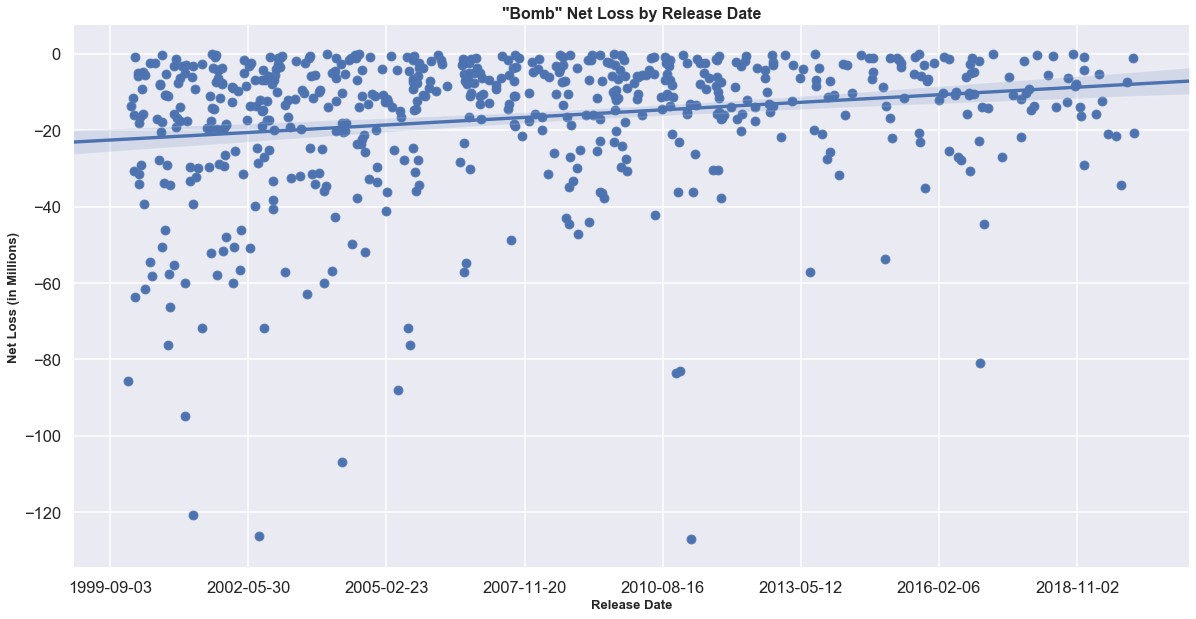

In [185]:
# scatter our bombs!

fig, ax=plt.subplots(figsize=(20,10))
data = twobombs
scatter3 = sns.scatterplot(x='date_ordinal', y='world_net', data=data, palette='bright')

ax = sns.regplot(x='date_ordinal', y="world_net", data=data, truncate=False)

new_labels = [date.fromordinal(int(item)) for item in scatter3.get_xticks()]
scatter3.set_xticklabels(new_labels)

scatter3.set_ylabel('Net Loss (in Millions)',weight='bold',fontsize=13)
scatter3.set_xlabel('Release Date', weight='bold',fontsize=13)
scatter3.set_title('"Bomb" Net Loss by Release Date',weight='bold',fontsize=16)
sns.despine()


Here we see some interesting data. The trendline for bombs when we look at release date goes distinctly upward. Are studios doing a better job of making good project choices? Let's check out the trendline for net income of ALL movies.

In [186]:
# converting our release_dates into ordinal format so that we can plot a regression
master_movies['date_ordinal'] = pd.to_datetime(master_movies['release_date']).apply(lambda date: date.toordinal())

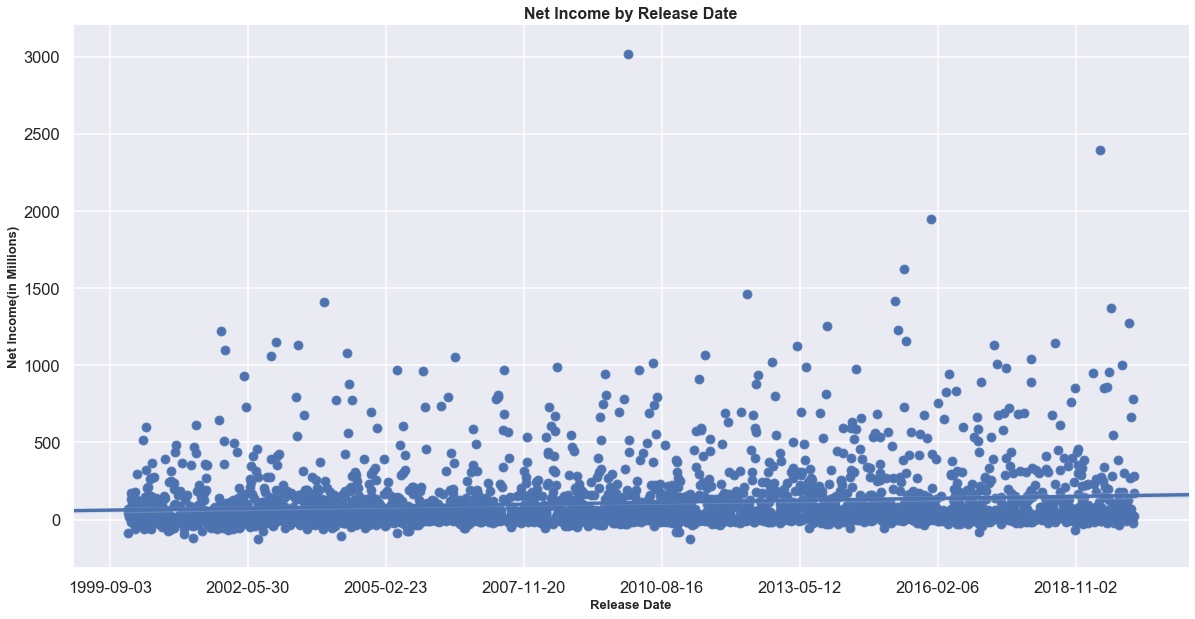

In [187]:
# scatter our bombs!

fig, ax=plt.subplots(figsize=(20,10))
data = master_movies
scatter4 = sns.scatterplot(x='date_ordinal', y='world_net', data=data, palette='bright')

ax = sns.regplot(x='date_ordinal', y="world_net", data=data, truncate=False)

new_labels = [date.fromordinal(int(item)) for item in scatter4.get_xticks()]
scatter4.set_xticklabels(new_labels)

scatter4.set_ylabel('Net Income(in Millions)',weight='bold',fontsize=13)
scatter4.set_xlabel('Release Date', weight='bold',fontsize=13)
scatter4.set_title('Net Income by Release Date',weight='bold',fontsize=16)
sns.despine()


Our trendline for overall net income over the years is nearly flat.

BOMB RATIO

In [188]:
total_films = full_financials.groupby(pd.DatetimeIndex(full_financials['release_date']).year).count()
# Our total number of full financial movies sorted  by rating. Since we are comparing on net, we can only use the list of 
# movies for which we have net income totals for an accurate proportion

total_bombs = negative_income.groupby(pd.DatetimeIndex(negative_income['release_date']).year).count()
# our negative ratings count of ALL of our negative net movies by MPAA rating

In [189]:
proportion = round(((total_bombs['title'])/(total_films['title']))*100, 2)
print(proportion)

release_date
2000    36.23
2001    36.55
2002    32.52
2003    26.57
2004    31.29
2005    28.76
2006    25.17
2007    26.79
2008    23.90
2009    28.05
2010    25.15
2011    24.20
2012    21.31
2013    13.33
2014    13.67
2015    19.70
2016    20.00
2017    14.41
2018    17.24
2019     9.65
Name: title, dtype: float64


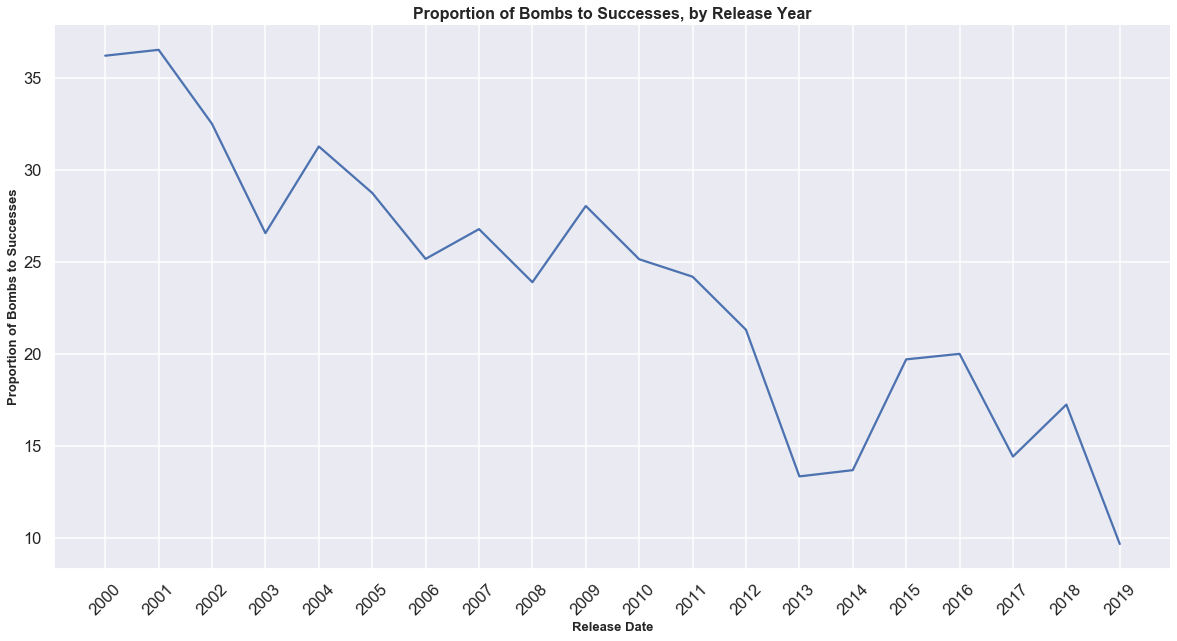

In [190]:
fig, ax=plt.subplots(figsize=(20,10))

scatter5 = sns.lineplot(x=proportion.index, y=proportion.values, data=proportion, palette='bright')


plt.xticks(np.arange(2000, 2020, step=1), rotation=45)
scatter5.set_ylabel('Proportion of Bombs to Successes',weight='bold',fontsize=13)
scatter5.set_xlabel('Release Date', weight='bold',fontsize=13)
scatter5.set_title('Proportion of Bombs to Successes, by Release Year',weight='bold',fontsize=16)
sns.despine()

Studios are improving at making movies. Back in 2000, 35% of released movies resulted in a negative net income. In 2019, this was less than 10%. That is a huge change over time, and indicative that studios are making more profitable movie decisions.

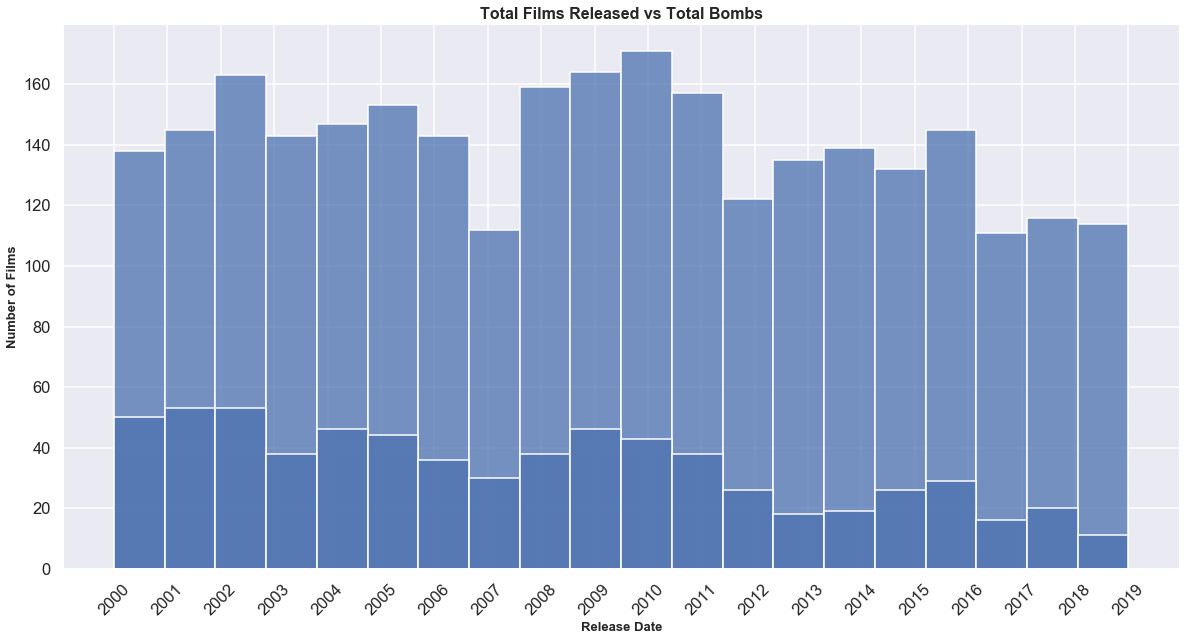

In [191]:
fig, ax=plt.subplots(figsize=(20,10))

scatter5 = sns.histplot(x=(pd.DatetimeIndex(full_financials['release_date']).year), data=full_financials, bins=20)
scatter5 = sns.histplot(x=(pd.DatetimeIndex(negative_income['release_date']).year), data=negative_income, bins=20)

plt.xticks(np.arange(2000, 2020, step=1), rotation=45)
scatter5.set_ylabel('Number of Films',weight='bold',fontsize=13)
scatter5.set_xlabel('Release Date', weight='bold',fontsize=13)
scatter5.set_title('Total Films Released vs Total Bombs',weight='bold',fontsize=16)
sns.despine()


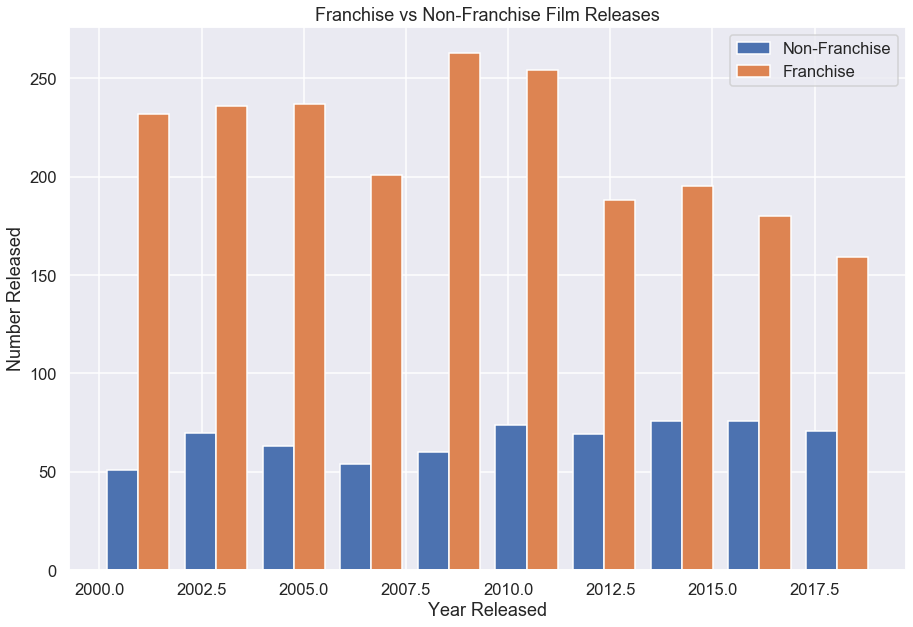

In [192]:
x_values = pd.DatetimeIndex(isfranchise['release_date']).year
x2_values = pd.DatetimeIndex(notfranchise['release_date']).year

fig, ax = plt.subplots(figsize=(15,10))


plt.hist([x_values, x2_values])

ax.set_xlabel('Year Released')  # Add an x-label to the axes.
ax.set_ylabel('Number Released')  # Add a y-label to the axes.
ax.set_title("Franchise vs Non-Franchise Film Releases", size=18)  # Add a title to the axes.
ax.legend(['Non-Franchise', 'Franchise'])  # Add a legend.


plt.show()

Non-franchise releases over time have remained pretty static. Franchise releases have actually overall gone down. Total overall movie releases have gone down due to fewer franchise releases, and the trendline of net loss has been improving, so studios have been making less bad franchise films by either picking better franchises, or working within their existing franchises.

## Director

In [193]:
# make a new series based on the director of the movie
director = cast_crew[cast_crew['category'] == 'director']

In [194]:
# checking out our mean values for this group for top domestic grossers
director.groupby(['primary_name']).mean().sort_values('dom_gross', ascending=False)
# We have 1922 different directors for our movies

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
primary_name,,,,,,,,,,,,,,,,,,,,,
Joe Russo,265.252333,558.34750,1696.5100,252.031667,1311.236333,121.47250,8.0750,606989.75,3.0,1.00,...,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.00,0.0,0.0
Anthony Russo,265.252333,558.34750,1696.5100,252.031667,1311.236333,121.47250,8.0750,606989.75,3.0,1.00,...,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.00,0.0,0.0
Angus MacLane,NaN,507.74400,1073.9360,NaN,NaN,30.77700,7.1500,222941.00,2.0,1.00,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
J.J. Abrams,199.775250,476.05925,1019.3680,276.284000,819.592750,64.03025,7.1625,395942.00,3.0,0.75,...,0.25,0.0,0.0,0.0,0.25,0.0,1.0,0.25,0.0,0.0
Jennifer Lee,156.655000,456.13950,1420.7045,299.484500,1264.049500,172.42450,7.3500,267916.50,2.0,1.00,...,0.50,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Scott Dow,2.134000,0.00000,0.0000,-2.134000,-2.134000,22.21900,4.2500,2988.00,4.0,0.00,...,0.00,0.0,0.0,0.0,0.00,0.0,1.0,0.00,0.0,0.0
Michael Winnick,8.353000,0.00000,0.0000,-8.353000,-8.353000,7.70700,4.1000,2007.00,4.0,0.00,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0
Mora Stephens,4.802000,0.00000,0.0000,-4.802000,-4.802000,11.91000,5.7000,6223.00,4.0,0.00,...,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.00,0.0,0.0


In [195]:
# Checking how many movies each director has directed.
director.groupby(['primary_name']).count().value_counts('title')
#1092 of our directors have directed only one movie

title
1    1092
2     303
3     158
4      59
5      27
6      11
7       4
8       2
dtype: int64

In [196]:
# select directors that have directed at least 2 movies, so that we know they are proven
director2 = director[director.duplicated(subset='primary_name', keep=False)]

# checking out our mean values for this group
director2.groupby(['primary_name']).mean().sort_values('dom_gross', ascending=False)
# We have 614 repeat directors

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
primary_name,,,,,,,,,,,,,,,,,,,,,
Anthony Russo,265.252333,558.347500,1696.510000,252.031667,1311.236333,121.472500,8.0750,606989.750000,3.0,1.00,...,0.00,0.0,0.0,0.0,0.00,0.000000,1.0,0.00,0.0,0.0
Joe Russo,265.252333,558.347500,1696.510000,252.031667,1311.236333,121.472500,8.0750,606989.750000,3.0,1.00,...,0.00,0.0,0.0,0.0,0.00,0.000000,1.0,0.00,0.0,0.0
J.J. Abrams,199.775250,476.059250,1019.368000,276.284000,819.592750,64.030250,7.1625,395942.000000,3.0,0.75,...,0.25,0.0,0.0,0.0,0.25,0.000000,1.0,0.25,0.0,0.0
Chris Buck,156.655000,456.139500,1420.704500,299.484500,1264.049500,172.424500,7.3500,267916.500000,2.0,1.00,...,0.50,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0
Jennifer Lee,156.655000,456.139500,1420.704500,299.484500,1264.049500,172.424500,7.3500,267916.500000,2.0,1.00,...,0.50,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kat Coiro,NaN,0.016333,0.064333,NaN,NaN,10.999333,5.7000,7205.666667,4.0,0.00,...,0.00,0.0,0.0,0.0,0.00,0.333333,0.0,0.00,0.0,0.0
Christopher Smith,NaN,0.014000,0.225500,NaN,NaN,9.960500,6.2000,23192.500000,4.0,0.00,...,0.00,0.5,0.5,0.0,0.50,0.000000,0.0,0.50,0.0,0.0
William Monahan,NaN,0.014000,4.876000,NaN,NaN,12.124500,5.5500,24450.500000,4.0,0.00,...,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.50,0.0,0.0


In [197]:
# Looking at the mean domestic gross of our top 30 directors
directortop30 = director.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
directortop30

primary_name
Anthony Russo           558.347500
Joe Russo               558.347500
Angus MacLane           507.744000
J.J. Abrams             476.059250
Jennifer Lee            456.139500
Chris Buck              456.139500
Josh Cooley             426.153000
Patty Jenkins           423.244000
Joss Whedon             398.832000
Ronnie Del Carmen       380.850000
Pete Docter             380.850000
Jared Bush              356.320000
David Slade             352.465000
Lee Unkrich             351.313500
Jon Favreau             348.809750
Yarrow Cheney           328.169000
Pierre Coffin           324.621333
Brad Bird               316.983000
Christopher Nolan       311.794750
Alfonso Cuarón          303.394000
Dan Scanlon             297.195000
Chris Renaud            296.797600
Byron Howard            295.922500
Andrew Stanton          295.011500
Rian Johnson            291.150667
Kyle Balda              290.342667
Christophe Lourdelet    282.321000
Garth Jennings          282.321000
Ryan Co

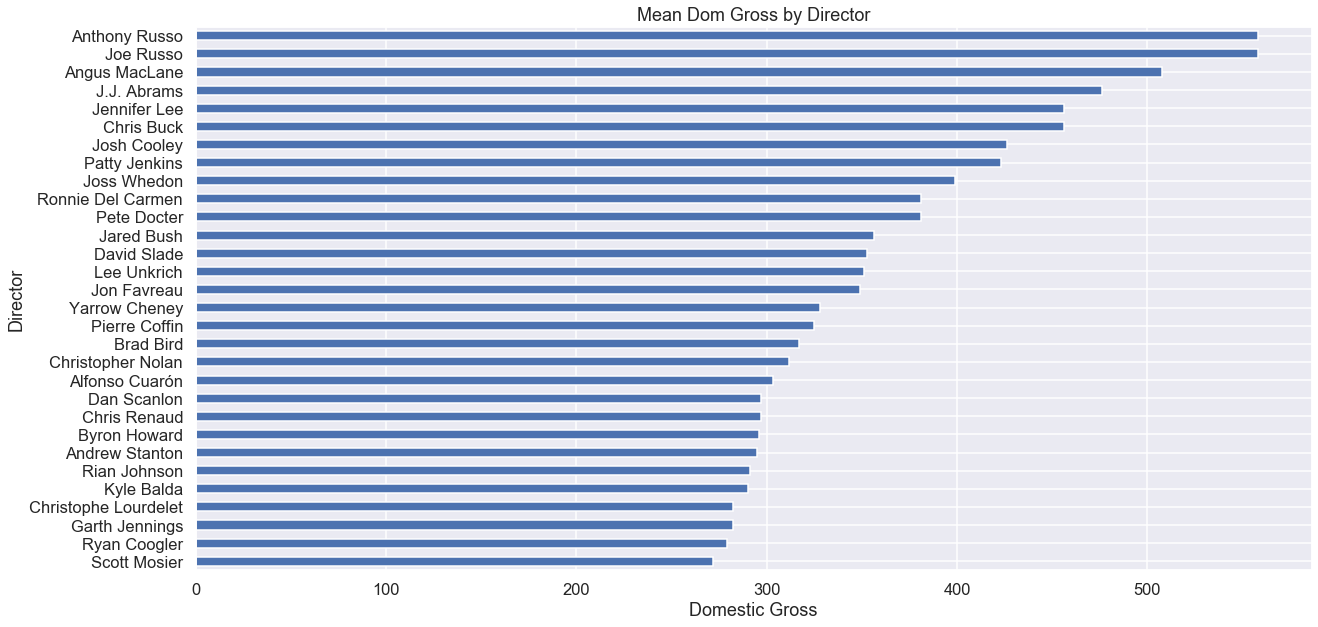

In [198]:
# Bar graph of the domestic gross of our top 30 directors
graphit = directortop30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Mean Dom Gross by Director')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

## Actors and Actresses

In [199]:
# checking out the top 30 actors in our top grossing movies
actor = cast_crew[cast_crew['category'] == 'actor']
actor30 = actor.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actor30

primary_name
Oscar Isaac          999.456
John Boyega          999.456
Domhnall Gleeson     999.456
Mark Ruffalo         842.779
Chris Hemsworth      842.779
Chris Evans          842.779
Robert Downey Jr.    842.779
Michael B. Jordan    703.235
Chadwick Boseman     703.235
Jeremy Renner        701.844
Ty Simpkins          695.999
Chris Pratt          695.999
Mark Hamill          636.236
Huck Milner          611.022
Craig T. Nelson      611.022
Donnie Yen           555.649
Diego Luna           555.649
Alan Tudyk           555.649
James Earl Jones     533.762
Chiwetel Ejiofor     533.762
Donald Glover        533.762
Seth Rogen           533.762
Josh Gad             517.541
Dan Stevens          517.541
Luke Evans           517.541
Ed O'Neill           507.744
Albert Brooks        507.744
Adam Driver          505.843
Christian Bale       504.564
Gary Oldman          504.564
Name: dom_gross, dtype: float64

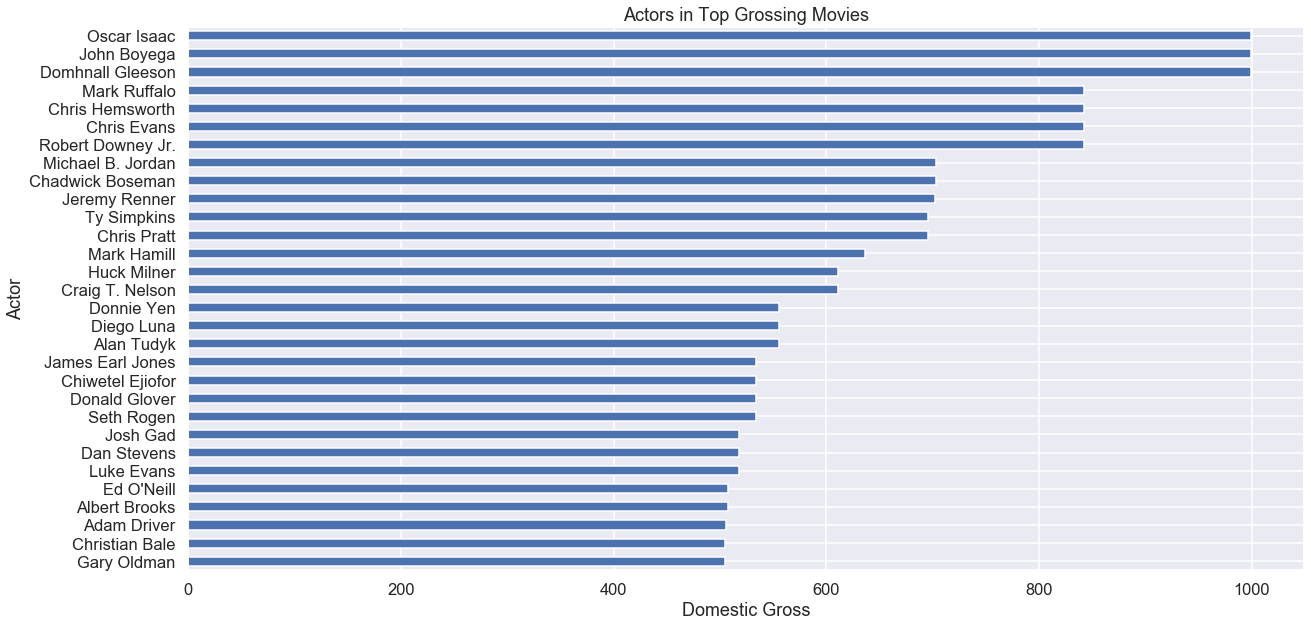

In [200]:
graphit = actor30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actors in Top Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actor')
graphit.plot();

In [201]:
# checking out the top 30 actresses in our top grossing movies
actress = cast_crew[cast_crew['category'] == 'actress']
actress30 = actress.groupby(['primary_name'])['dom_gross'].max().sort_values(ascending=False).nlargest(30)
actress30

primary_name
Daisy Ridley                 999.456
Lupita Nyong'o               703.235
Danai Gurira                 703.235
Scarlett Johansson           701.844
Judy Greer                   695.999
Bryce Dallas Howard          695.999
Holly Hunter                 611.022
Sarah Vowell                 611.022
Felicity Jones               555.649
Emma Watson                  517.541
Ellen DeGeneres              507.744
Kaitlin Olson                507.744
Billie Lourd                 505.843
Anne Hathaway                504.564
Joan Cusack                  486.719
Jennifer Lawrence            470.066
Evan Rachel Wood             468.701
Kristen Bell                 468.701
Gwyneth Paltrow              452.738
Idina Menzel                 443.578
Christina Hendricks          426.153
Gal Gadot                    423.244
Robin Wright                 423.244
Lucy Davis                   423.244
Brie Larson                  419.076
Karen Gillan                 415.013
Kristen Wiig             

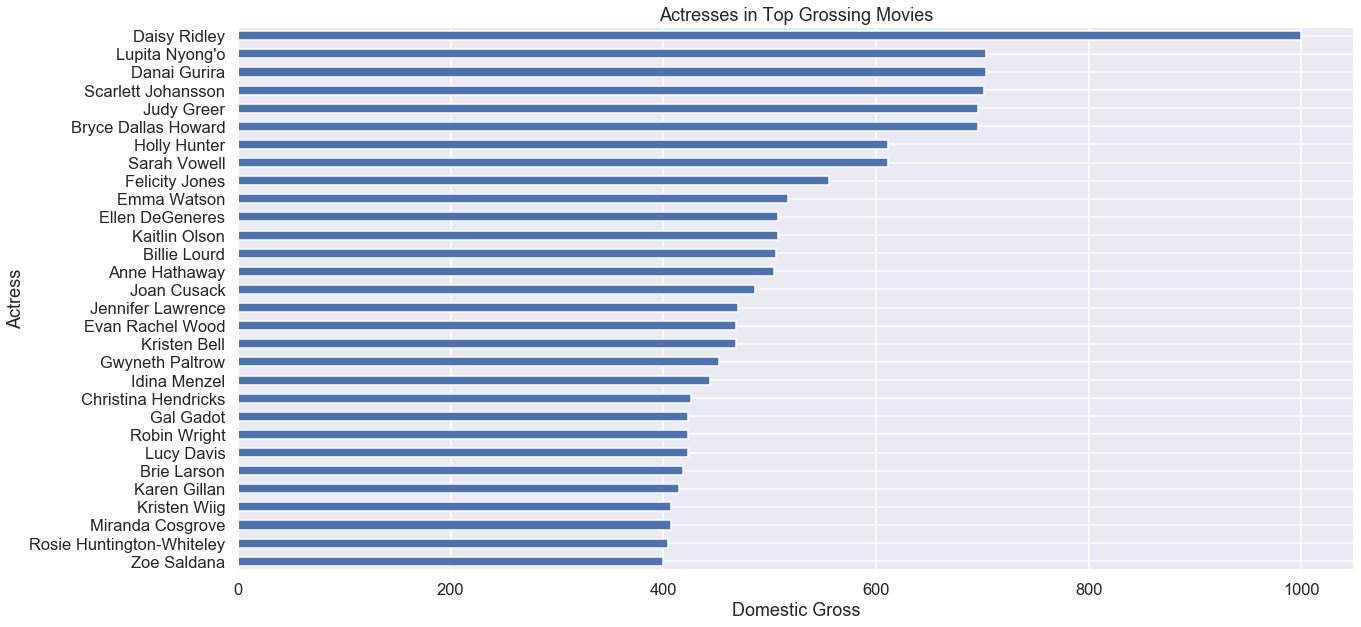

In [202]:
graphit = actress30.sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Actresses in Top Grossing Movies')
plt.xlabel('Domestic Gross')
plt.ylabel('Actress')
graphit.plot();

In [203]:
# Top 30 actors by their movies' mean domestic gross
actormean = actor.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
actormean

primary_name
Craig T. Nelson      611.022000
Huck Milner          611.022000
Ed O'Neill           507.744000
Robert Downey Jr.    393.489250
Cole Konis           381.428000
Neel Sethi           380.055000
Ty Simpkins          379.670500
Donald Glover        374.193500
Pierre Coffin        358.574000
Mena Massoud         349.100000
Marwan Kenzari       349.100000
Finn Wolfhard        337.341000
Jonathan Groff       304.113333
Donnie Yen           300.855000
John Boyega          289.205833
Ken Stott            285.987000
Mike Myers           279.991000
Alan Tudyk           277.956000
Chris Evans          275.825357
Bill Skarsgård       272.545000
Pharrell Williams    271.706000
Trey Parker          271.475000
James Earl Jones     267.633500
Rupert Grint         261.749333
Temuera Morrison     259.728000
Taylor Lautner       259.129500
David Schwimmer      243.637000
Ned Beatty           243.487000
Scott Adsit          242.422000
Ryan Potter          242.422000
Name: dom_gross, dtype: flo

In [204]:
franchiseactors = actor.loc[(cast_crew['is_franchise'] == True)].groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
franchiseactors

primary_name
Chadwick Boseman     703.235000
Huck Milner          611.022000
Craig T. Nelson      611.022000
John Boyega          565.269000
Domhnall Gleeson     562.716000
Alan Tudyk           555.649000
Oscar Isaac          534.729000
James Earl Jones     533.762000
Chris Evans          518.239286
Ed O'Neill           507.744000
Albert Brooks        507.744000
Adam Driver          505.843000
Christian Bale       504.564000
Robert Downey Jr.    502.043667
Tim Allen            486.719000
Ned Beatty           486.719000
Sterling K. Brown    468.701000
Jonathan Groff       456.139500
Guy Pearce           452.738000
Michael Gambon       437.563000
Jordan Peele         426.153000
Sebastian Stan       426.083000
Mark Ruffalo         422.594000
Rafe Spall           419.395000
Justice Smith        419.395000
Ben Mendelsohn       419.076000
Don Cheadle          409.580500
Shia LaBeouf         404.272000
Tyrese Gibson        404.272000
Rupert Grint         392.560500
Name: dom_gross, dtype: flo

In [205]:
nonfranchiseactors = actor.loc[(cast_crew['is_franchise'] == False)].groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
nonfranchiseactors

primary_name
Cole Konis             381.428000
Neel Sethi             380.055000
Mena Massoud           349.100000
Marwan Kenzari         349.100000
Pharrell Williams      271.706000
Temuera Morrison       259.728000
Ryan Potter            242.422000
Scott Adsit            242.422000
Zachary Levi           235.525000
Ben Hardy              217.537000
Gwilym Lee             217.537000
Rami Malek             217.537000
Greg Grunberg          216.152000
Benjamin Bratt         215.908000
Anthony Gonzalez       215.908000
Barry Keoghan          194.653000
Terry Crews            194.064000
Neil Patrick Harris    182.766000
Michael McDonald       176.642000
Neil Brown Jr.         172.005000
Corey Hawkins          172.005000
Winston Duke           171.904000
Ken Watanabe           171.577500
Colton Haynes          165.595000
Seth MacFarlane        164.658500
Leonardo DiCaprio      156.283778
Jackson Rathbone       154.543000
Noah Ringer            154.543000
Joel Courtney          145.702000
B

In [206]:
allfranchactors = cast_crew.loc[(cast_crew['is_franchise'] == True) & ((cast_crew['category'] == 'actor') | (cast_crew['category'] == 'actress'))].groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
allfranchactors

primary_name
Daisy Ridley           713.845000
Lupita Nyong'o         703.235000
Danai Gurira           703.235000
Chadwick Boseman       703.235000
Craig T. Nelson        611.022000
Sarah Vowell           611.022000
Huck Milner            611.022000
Holly Hunter           611.022000
John Boyega            565.269000
Domhnall Gleeson       562.716000
Bryce Dallas Howard    557.697000
Alan Tudyk             555.649000
Oscar Isaac            534.729000
James Earl Jones       533.762000
Chris Evans            518.239286
Kaitlin Olson          507.744000
Ed O'Neill             507.744000
Albert Brooks          507.744000
Ellen DeGeneres        507.744000
Billie Lourd           505.843000
Adam Driver            505.843000
Christian Bale         504.564000
Robert Downey Jr.      502.043667
Joan Cusack            486.719000
Ned Beatty             486.719000
Tim Allen              486.719000
Scarlett Johansson     470.305667
Evan Rachel Wood       468.701000
Sterling K. Brown      468.701000
J

In [207]:
notfranchiseactors = cast_crew.loc[(cast_crew['is_franchise'] == False) & ((cast_crew['category'] == 'actor') | (cast_crew['category'] == 'actress'))].groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
notfranchiseactors

primary_name
Cole Konis             381.4280
Neel Sethi             380.0550
Mena Massoud           349.1000
Naomi Scott            349.1000
Marwan Kenzari         349.1000
Pharrell Williams      271.7060
Cameron Seely          271.7060
Temuera Morrison       259.7280
Auli'i Cravalho        259.7280
Jamie Chung            242.4220
Scott Adsit            242.4220
Ryan Potter            242.4220
Zachary Levi           235.5250
Donna Murphy           235.5250
Daniella Kertesz       223.9920
Rami Malek             217.5370
Ben Hardy              217.5370
Gwilym Lee             217.5370
Greg Grunberg          216.1520
Lady Gaga              216.1520
Benjamin Bratt         215.9080
Alanna Ubach           215.9080
Anthony Gonzalez       215.9080
Ginnifer Goodwin       200.5575
Barry Keoghan          194.6530
Terry Crews            194.0640
Neil Patrick Harris    182.7660
Allison Williams       180.5980
Michael McDonald       176.6420
Neil Brown Jr.         172.0050
Name: dom_gross, dtype: flo

## Writer

In [208]:
# make a new series based on the writer of the movie
writer = cast_crew[cast_crew['category'] == 'writer']

In [209]:
# checking out our mean values for this group
writer.groupby(['primary_name']).mean().sort_values('dom_gross', ascending=False)
# We have 3983 different writers for our list of 6729 movies

,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,total_votes,rating_id,is_franchise,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
primary_name,,,,,,,,,,,,,,,,,,,,,
Joe Robert Cole,NaN,703.2350,1352.8660,NaN,NaN,109.772,7.35,532388.0,3.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Lawrence Kasdan,268.764,607.0405,1300.8125,338.2765,1032.0485,51.670,7.25,515904.5,3.0,1.0,...,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
John Knoll,208.821,555.6490,1102.6350,346.8280,893.8140,40.837,7.65,490033.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Jonathan Roberts,255.277,533.7620,1627.0340,278.4850,1371.7570,177.499,7.20,6985.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Brenda Chapman,255.277,533.7620,1627.0340,278.4850,1371.7570,177.499,7.20,6985.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Josh Malerman,19.879,0.0000,0.0000,-19.8790,-19.8790,37.664,6.75,225066.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Raul Inglis,7.037,0.0000,0.0430,-7.0370,-6.9940,8.744,5.10,3928.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Adam Mason,11.485,0.0000,2.2980,-11.4850,-9.1870,13.748,5.40,13938.0,4.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [210]:
# Checking how many movies each writer has written.
writer.groupby(['primary_name']).count().value_counts('title')
# most of our writers have only written one movie!

title
1    2036
2     347
3     152
4      68
5      36
6      17
7       7
8       5
9       2
dtype: int64

In [211]:
# Looking at the mean domestic gross of our top 30 writers
writertop30 = writer.groupby(['primary_name'])['dom_gross'].mean().sort_values(ascending=False).nlargest(30)
writertop30

primary_name
Joe Robert Cole       703.235000
Lawrence Kasdan       607.040500
John Knoll            555.649000
Jonathan Roberts      533.762000
Brenda Chapman        533.762000
Stephen Chbosky       517.541000
Victoria Strouse      507.744000
George Lucas          487.512000
Colin Trevorrow       462.619000
Andrew Stanton        456.436000
Jim Starlin           444.841000
Shane Morris          443.578000
Rashida Jones         426.153000
Valerie LaPointe      426.153000
Allan Heinberg        423.244000
Zak Penn              420.043000
Chris Van Allsburg    415.013000
Michael Arndt         411.200667
Steve Englehart       399.904000
Steve Gan             399.904000
Suzanne Collins       399.334250
Dan Abnett            381.433500
Andy Lanning          381.433500
Scott McEwen          381.428000
Jim DeFelice          381.428000
Simon Rich            380.850000
Josh Cooley           380.850000
Justin Marks          380.055000
Bill Mantlo           362.963000
Keith Giffen          362.9630

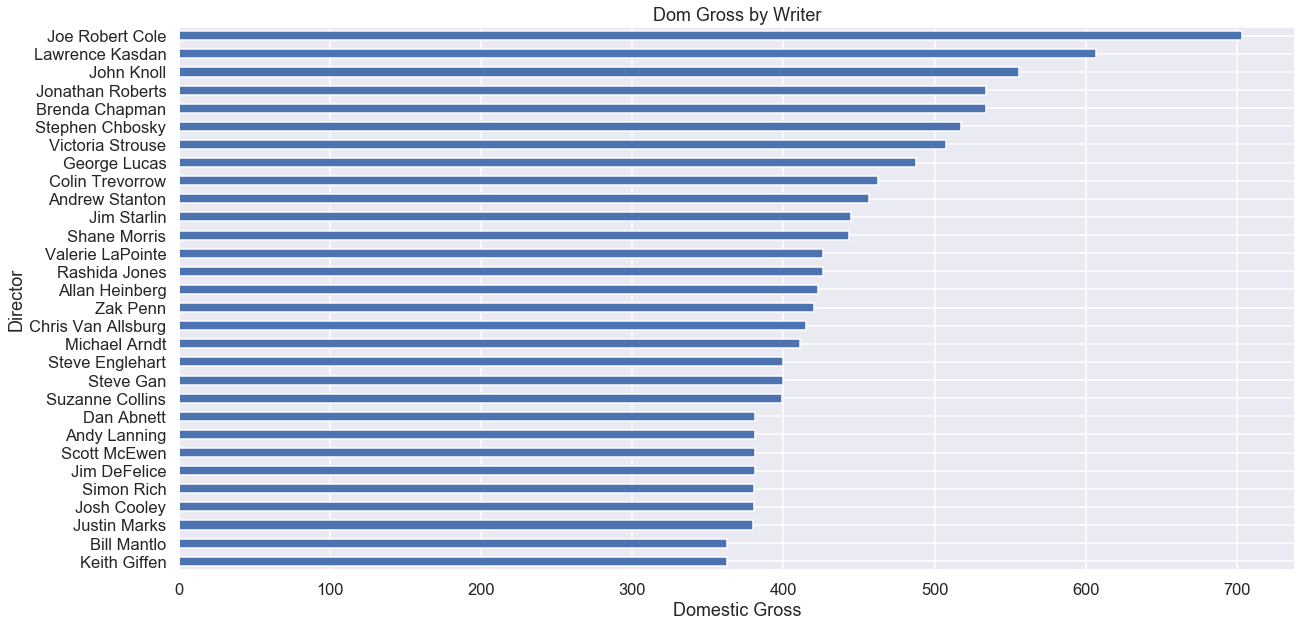

In [212]:
# Bar graph of the domestic gross of our top 30 directors
graphit = writertop30.sort_values().plot(kind='barh', figsize=(20,10))
#deaths = df.groupby(['State'])['Deaths'].sum().sort_values().plot(kind='barh', figsize=(20,10))

plt.title('Dom Gross by Writer')
plt.xlabel('Domestic Gross')
plt.ylabel('Director')
graphit.plot();

In [213]:
master_movies.sort_values('dom_gross', ascending=False).head(50)

,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,popularity,...,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,date_ordinal
id,,,,,,,,,,,,,,,,,,,,,
tt2488496,Star Wars The Force Awakens,PG-13,Walt Disney Studios Motion Pictures,NaN,261.425,999.456,2207.124,738.031,1945.699,52.273,...,False,False,False,False,False,True,False,False,False,735947
tt0499549,Avatar,PG-13,Twentieth Century Fox,Avatar,280.190,899.101,3298.964,618.911,3018.774,70.878,...,False,False,False,False,False,True,False,False,False,733751
tt4154796,Avengers Endgame,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,349.533,842.779,2746.974,493.246,2397.441,177.346,...,False,False,False,False,False,True,False,False,False,737173
tt1825683,Black Panther,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,NaN,703.235,1352.866,NaN,NaN,109.772,...,False,False,False,False,False,True,False,False,False,736738
tt0848228,The Avengers,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,247.700,701.844,1710.047,454.144,1462.347,86.260,...,False,False,False,False,False,True,False,False,False,734618
tt0369610,Jurassic World,PG-13,Universal Pictures,Jurassic Park,160.056,695.999,1782.386,535.943,1622.330,84.240,...,False,False,False,False,False,True,True,False,False,735755
tt4154756,Avengers Infinity War,PG-13,Walt Disney Studios Motion Pictures,Marvel Cinematic Universe,NaN,681.538,2056.574,NaN,NaN,214.301,...,False,False,False,False,False,True,False,False,False,736809
tt0468569,The Dark Knight,PG-13,Warner Bros.,Batman,222.687,644.267,1210.280,421.580,987.593,61.787,...,False,False,False,False,False,False,True,False,False,733239
tt2527336,Star Wars The Last Jedi,PG-13,Walt Disney Studios Motion Pictures,NaN,325.206,636.236,1367.198,311.030,1041.992,65.624,...,False,False,False,False,False,True,False,False,False,736676


## Writer/Director Teams

Do we have any writing/directing teams 

In [214]:
# make a new series with only the writing and directing personnel categories for the movie
teams = cast_crew[(cast_crew['category'] == 'writer') | (cast_crew['category'] == 'director')]

teams.loc[teams['category'] == 'writer', 'writers'] = teams['nconst']
teams.loc[teams['category'] == 'director', 'directors'] = teams['nconst']

C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Wadkins\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [215]:
teams.sort_values('index', ascending=False)

,index,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,...,Romance,Science Fiction,Thriller,War,Western,nconst,category,primary_name,writers,directors
27118,tt9896916,The Pilgrims Progress,PG,Fathom Events,NaN,NaN,1.271,3.116,NaN,NaN,...,False,False,False,False,False,nm10567937,writer,John Bunyan,nm10567937,NaN
27114,tt9896916,The Pilgrims Progress,PG,Fathom Events,NaN,NaN,1.271,3.116,NaN,NaN,...,False,False,False,False,False,nm9546685,director,Robert Fernandez,NaN,nm9546685
27105,tt9358044,Hail Satan,R,Magnolia Pictures,NaN,NaN,0.417,0.459,NaN,NaN,...,False,False,False,False,False,nm3704075,director,Penny Lane,NaN,nm3704075
27097,tt9356952,The Death Of Dick Long,R,A24,NaN,NaN,0.036,0.036,NaN,NaN,...,False,False,False,False,False,nm6067982,writer,Billy Chew,nm6067982,NaN
27096,tt9356952,The Death Of Dick Long,R,A24,NaN,NaN,0.036,0.036,NaN,NaN,...,False,False,False,False,False,nm3215397,director,Daniel Scheinert,NaN,nm3215397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,tt0365907,A Walk Among The Tombstones,R,Universal Pictures,NaN,30.503,28.660,64.094,-1.843,33.591,...,False,False,True,False,False,nm0088747,writer,Lawrence Block,nm0088747,NaN
1028,tt0365907,A Walk Among The Tombstones,R,Universal Pictures,NaN,30.503,28.660,64.094,-1.843,33.591,...,False,False,True,False,False,nm0291082,director,Scott Frank,NaN,nm0291082
965,tt0359950,The Secret Life Of Walter Mitty,PG,Twentieth Century Fox,NaN,99.621,64.462,208.245,-35.159,108.624,...,False,False,False,False,False,nm0175726,writer,Steve Conrad,nm0175726,NaN
855,tt0337692,On The Road,R,IFC Films,NaN,NaN,0.838,10.828,NaN,NaN,...,False,False,False,False,False,nm0758574,director,Walter Salles,NaN,nm0758574


In [216]:
teams.loc[(teams['writers'] == teams['directors'])]
# apparently there are no repeating teams

,index,title,mpaa_rating,studio,franchise,budget,dom_gross,world_gross,dom_net,world_net,...,Romance,Science Fiction,Thriller,War,Western,nconst,category,primary_name,writers,directors


# TO DO


Visualizations/stuff to look at:



* gross/net against studio


* gross/net by MPAA rating
* gross/net by MPAA rating and genre


* scatter with directors vs gross where size is how many movies they have directed


Do all of the functions have docstrings?
Did I follow PEP8?


## Studios

Pull out studios that have done at least 3 films, sort on net from smallest, see how a small studio can do

Check this for both franchise and non-franchise

## Director

Break out directors by Franchise/Not Franchise

Pull directors of Animation


## Actor/Actress

* Check top actors for franchises, and top actors for non-franchises
* count number of billed actors/actresses for franchises vs non-franchises

## Writer

Pull writers of animation

# Presentation Notes

* Show risk vs reward of franchise investment vs single film. Show Disney avg net per film vs small studio
* Example - Twilight
* Additional revenues from merchandising
* Minecraft? Perfect intersection of franchise and existing IP that MS already owns?
* opportunities for future work -
    * look for directors who have worked on G and PG animation films
    * look for writers that have worked on the genres we are focusing on
    * casting decisions - look at 
    * release date

In [217]:
# making a data frame showing franchise sets where there are at least 2 films in the franchise
franchsets = isfranchise[isfranchise.groupby('franchise')['franchise'].transform('size') > 1]
franchsets.groupby('franchise').count()

# We have 183 franchise sets with at least 2 entries

,title,mpaa_rating,studio,budget,dom_gross,world_gross,dom_net,world_net,popularity,user_rating,...,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
franchise,,,,,,,,,,,,,,,,,,,,,
21 Jump Street,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
300,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
47 Meters Down,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
A Dogâs Purpose,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
A Haunted House,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Winnie the Pooh,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Wreck-It Ralph,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
X-Men,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
